# Распознавание автомобильных номеров

In [1]:
from google.colab import files


In [2]:
! wget --no-check-certificate -r 'https://docs.google.com/uc?export=download&id=1E9e4LmjUJxdSgfzfLJgXKOJqtUP6-xYs' -O data.zip
! unzip -qq data.zip

will be placed in the single file you specified.

--2020-06-21 08:38:55--  https://docs.google.com/uc?export=download&id=1E9e4LmjUJxdSgfzfLJgXKOJqtUP6-xYs
Resolving docs.google.com (docs.google.com)... 74.125.195.101, 74.125.195.139, 74.125.195.100, ...
Connecting to docs.google.com (docs.google.com)|74.125.195.101|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [text/html]
Saving to: ‘data.zip’

data.zip                [ <=>                ]   3.17K  --.-KB/s    in 0s      

2020-06-21 08:38:55 (39.1 MB/s) - ‘data.zip’ saved [3248]

Loading robots.txt; please ignore errors.
--2020-06-21 08:38:55--  https://docs.google.com/robots.txt
Reusing existing connection to docs.google.com:443.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [text/plain]
Saving to: ‘data.zip’

data.zip                [ <=>                ]     567  --.-KB/s    in 0s      

2020-06-21 08:38:55 (80.9 MB/s) - ‘data.zip’ saved [567]

--2020-06-21 08:38:55--  h

In [3]:
!rm data.zip

In [18]:
import os
import gc
import json
import glob
from collections import Counter

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.path import Path
import seaborn as sns
import tqdm

import torchvision
from torchvision import models
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor
from torchvision import transforms

import PIL
from PIL import Image, ImageDraw
import cv2

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

from IPython.display import clear_output

In [5]:
torch.__version__, torch.cuda.is_available()

('1.5.0+cu101', True)

In [19]:
# Бинарный поиск для приближения предсказанной маски 4-хугольником
def simplify_contour(contour, n_corners=4):
    n_iter, max_iter = 0, 1000
    lb, ub = 0., 1.

    while True:
        n_iter += 1
        if n_iter > max_iter:
            print('simplify_contour didnt coverege')
            return None

        k = (lb + ub)/2.
        eps = k*cv2.arcLength(contour, True)
        approx = cv2.approxPolyDP(contour, eps, True)

        if len(approx) > n_corners:
            lb = (lb + ub)/2.
        elif len(approx) < n_corners:
            ub = (lb + ub)/2.
        else:
            return approx

# Отображаем 4-хугольник в прямоугольник 
# Спасибо ulebok за идею 
# И вот этим ребятам за реализацию: https://www.pyimagesearch.com/2014/08/25/4-point-opencv-getperspective-transform-example/
def four_point_transform(image, pts):
    
    rect = order_points(pts)
    
    tl, tr, br, bl = pts
    
    width_1 = np.sqrt(((br[0] - bl[0]) ** 2) + ((br[1] - bl[1]) ** 2))
    width_2 = np.sqrt(((tr[0] - tl[0]) ** 2) + ((tr[1] - tl[1]) ** 2))
    max_width = max(int(width_1), int(width_2))
    
    height_1 = np.sqrt(((tr[0] - br[0]) ** 2) + ((tr[1] - br[1]) ** 2))
    height_2 = np.sqrt(((tl[0] - bl[0]) ** 2) + ((tl[1] - bl[1]) ** 2))
    max_height = max(int(height_1), int(height_2))
    
    dst = np.array([
        [0, 0],
        [max_width, 0],
        [max_width, max_height],
        [0, max_height]], dtype = "float32")
    
    M = cv2.getPerspectiveTransform(rect, dst)
    warped = cv2.warpPerspective(image, M, (max_width, max_height))
    return warped

def order_points(pts):
    rect = np.zeros((4, 2), dtype = "float32")
    
    s = pts.sum(axis = 1)
    rect[0] = pts[np.argmin(s)]
    rect[2] = pts[np.argmax(s)]
    
    diff = np.diff(pts, axis = 1)
    rect[1] = pts[np.argmin(diff)]
    rect[3] = pts[np.argmax(diff)]
    
    return rect


# Визуализируем детекцию (4 точки, bounding box и приближенный по маске контур)
def visualize_prediction_plate(file, model, device='cuda', verbose=True, thresh=0.0, 
                               n_colors=None, id_to_name=None):
    img = Image.open(file)
    img_tensor = my_transforms(img)
    model.to(device)
    model.eval()
    with torch.no_grad():
        predictions = model([img_tensor.to(device)])
    prediction = predictions[0]
    
    if n_colors is None:
        n_colors = model.roi_heads.box_predictor.cls_score.out_features
    
    palette = sns.color_palette(None, n_colors)
    
    img = cv2.imread(file, cv2.COLOR_BGR2RGB)
    h, w = img.shape[:2]
    image = img
    
    blackImg = np.zeros(image.shape, image.dtype)
    blackImg[:,:] = (0, 0, 0)
    for i in range(len(prediction['boxes'])):
        x_min, y_min, x_max, y_max = map(int, prediction['boxes'][i].tolist())
        label = int(prediction['labels'][i].cpu())
        score = float(prediction['scores'][i].cpu())
        mask = prediction['masks'][i][0, :, :].cpu().numpy()
        name = id_to_name[label]
        color = palette[label]
        
        if verbose:
            if score > thresh:
                print ('Class: {}, Confidence: {}'.format(name, score))
        if score > thresh:            
            crop_img = image[y_min:y_max, x_min:x_max]
            print('Bounding box:')
            show_image(crop_img, figsize=(10, 2))
            
            # В разных версиях opencv этот метод возвращает разное число параметров
            # Оставил для версии colab
#             _,contours,_ = cv2.findContours((mask > 0.05).astype(np.uint8), 1, 1)
            contours,_ = cv2.findContours((mask > 0.05).astype(np.uint8), 1, 1)
            approx = simplify_contour(contours[0], n_corners=4)
            
            if approx is None:
                x0, y0 = x_min, y_min
                x1, y1 = x_max, y_min
                x2, y2 = x_min, y_max
                x3, y3 = x_max, y_max
#                 points = [[x_min, y_min], [x_min, y_max], [x_max, y_min],[x_max, y_max]]
            else:
                x0, y0 = approx[0][0][0], approx[0][0][1]
                x1, y1 = approx[1][0][0], approx[1][0][1]
                x2, y2 = approx[2][0][0], approx[2][0][1]
                x3, y3 = approx[3][0][0], approx[3][0][1]
                
            points = [[x0, y0], [x2, y2], [x1, y1],[x3, y3]]
            
            
            points = np.array(points)
            crop_mask_img = four_point_transform(img, points)
            print('Rotated img:')
            crop_mask_img = cv2.resize(crop_mask_img, (320, 64), interpolation=cv2.INTER_AREA)
            show_image(crop_mask_img, figsize=(10, 2))
            if approx is not None:
                cv2.drawContours(image, [approx], 0, (255,0,255), 3)
            image = cv2.circle(image, (x0, y0), radius=5, color=(0, 0, 255), thickness=-1)
            image = cv2.circle(image, (x1, y1), radius=5, color=(0, 0, 255), thickness=-1)
            image = cv2.circle(image, (x2, y2), radius=5, color=(0, 0, 255), thickness=-1)
            image = cv2.circle(image, (x3, y3), radius=5, color=(0, 0, 255), thickness=-1)
            
            image = cv2.rectangle(image, (x_min, y_min), (x_max, y_max), np.array(color) * 255, 2)
            
    show_image(image)
    return prediction

# Просто показать картинку. С семинара
def show_image(image, figsize=(16, 9), reverse=True):
    plt.figure(figsize=figsize)
    if reverse:
        plt.imshow(image[...,::-1])
    else:
        plt.imshow(image)
    plt.axis('off')
    plt.show()
    

# Переводит предсказания модели в текст. С семинара
def decode(pred, alphabet):
    pred = pred.permute(1, 0, 2).cpu().data.numpy()
    outputs = []
    for i in range(len(pred)):
        outputs.append(pred_to_string(pred[i], alphabet))
    return outputs

def pred_to_string(pred, alphabet):
    seq = []
    for i in range(len(pred)):
        label = np.argmax(pred[i])
        seq.append(label - 1)
    out = []
    for i in range(len(seq)):
        if len(out) == 0:
            if seq[i] != -1:
                out.append(seq[i])
        else:
            if seq[i] != -1 and seq[i] != seq[i - 1]:
                out.append(seq[i])
    out = ''.join([alphabet[c] for c in out])
    return out
    

        
def load_json(file):
    with open(file, 'r') as f:
        return json.load(f)
    
# Чтобы без проблем сериализовывать json. Без него есть нюансы
class npEncoder(json.JSONEncoder):
    def default(self, obj):
        if isinstance(obj, np.int32):
            return int(obj)
        return json.JSONEncoder.default(self, obj)

In [20]:
DATA_PATH = './data/'
TRAIN_SIZE = 0.8
BATCH_SIZE = 2
BATCH_SIZE_OCR = 16
DETECTOR_MODEL_PATH = 'detector.pt'
OCR_MODEL_PATH = 'ocr.pt'

all_marks = load_json(os.path.join(DATA_PATH, 'train.json'))
test_start = int(TRAIN_SIZE * len(all_marks))
train_marks = all_marks[:test_start]
val_marks = all_marks[test_start:]

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

1) Находим номера
a) Модель для детекции
В задании есть данные о 4 точках, которые задают номер. Эти 4 точки - почти всегда не прямоугольник, а произвольный четырехугольник. Будем предсказывать:



*   bounding box, который окружает точки (детекция)
*   маску, заполненную тем, что внутри 4-х точек (сегментация)


Поэтому, возьмем maskrcnn. Будем обучать несколько последних солев. Этого с запасом хватает.

In [21]:
def get_detector_model():
    
    model = models.detection.maskrcnn_resnet50_fpn(
        pretrained=True, 
        pretrained_backbone=True,
        progress=True, 
        num_classes=91, 
    )

    num_classes = 2
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    
    box_predictor = FastRCNNPredictor(in_features, num_classes)
    model.roi_heads.box_predictor = box_predictor
    
    mask_predictor = MaskRCNNPredictor(256, 256, num_classes)
    model.roi_heads.mask_predictor = mask_predictor

    # Заморозим все слои кроме последних
    
    for param in model.parameters():
        param.requires_grad = False
        
    for param in model.backbone.fpn.parameters():
        param.requires_grad = True

    for param in model.rpn.parameters():
        param.requires_grad = True

    for param in model.roi_heads.parameters():
        param.requires_grad = True
    
    return model

b) Датасет для детекции

In [22]:
class DetectionDataset(Dataset):
    def __init__(self, marks, img_folder, transforms=None):
        
        self.marks = marks
        self.img_folder = img_folder
        self.transforms = transforms
        
    def __getitem__(self, idx):
        item = self.marks[idx]
        img_path = f'{self.img_folder}{item["file"]}'
        img = Image.open(img_path).convert('RGB')
        w, h = img.size
        
        box_coords = item['nums']
        boxes = []
        labels = []
        masks = []
        for box in box_coords:
            points = np.array(box['box'])  
            x0, y0 = np.min(points[:, 0]), np.min(points[:, 1])
            x2, y2 = np.max(points[:, 0]), np.max(points[:, 1])
            boxes.append([x0, y0, x2, y2])
            labels.append(1)
            
            # Здесь мы наши 4 точки превращаем в маску
            # Это нужно, чтобы кроме bounding box предсказывать и, соответственно, маску :)
            nx, ny = w, h
            poly_verts = points
            x, y = np.meshgrid(np.arange(nx), np.arange(ny))
            x, y = x.flatten(), y.flatten()
            points = np.vstack((x,y)).T
            path = Path(poly_verts)
            grid = path.contains_points(points)
            grid = grid.reshape((ny,nx)).astype(int)
            masks.append(grid)
            
        boxes = torch.as_tensor(boxes)
        labels = torch.as_tensor(labels)
        masks = torch.as_tensor(masks)
        
        target = {
            'boxes': boxes,
            'labels': labels,
            'masks': masks,
        }
        
        if self.transforms is not None:
            img = self.transforms(img)
        
        return img, target
    
    
    def __len__(self):
        return len(self.marks)
    
my_transforms = transforms.Compose([
    transforms.ToTensor()
])

train_dataset = DetectionDataset(
    marks=train_marks, 
    img_folder='data/', 
    transforms=my_transforms
)
val_dataset = DetectionDataset(
    marks=val_marks, 
    img_folder='data/', 
    transforms=my_transforms
)

def collate_fn(batch):
    return tuple(zip(*batch))

train_loader = DataLoader(
    train_dataset, 
    batch_size=BATCH_SIZE, 
    drop_last=True,
    num_workers=4,
    collate_fn=collate_fn, 
)

val_loader = DataLoader(
    val_dataset, 
    batch_size=BATCH_SIZE, 
    drop_last=False,
    num_workers=4,
    collate_fn=collate_fn, 
)

c) Обучаем модель для детекции

In [23]:
torch.cuda.empty_cache()
gc.collect()
model = get_detector_model()
# model.load_state_dict(torch.load(DETECTOR_MODEL_PATH))
model.to(device);

In [24]:
import math
import torch
from torch.optim.optimizer import Optimizer
from typing import Iterable, Union, Callable, Dict, Optional, Tuple, Any
from torch import Tensor
Betas2 = Tuple[float, float]
OptFloat = Optional[float]
LossClosure = Callable[[], float]
OptLossClosure = Optional[LossClosure]
Params = Union[Iterable[Tensor], Iterable[Dict[str, Any]]]







__all__ = ('DiffGrad',)


class DiffGrad(Optimizer):
    r"""Implements DiffGrad algorithm.
    It has been proposed in `DiffGrad: An Optimization Method for
    Convolutional Neural Networks`__.
    Arguments:
        params: iterable of parameters to optimize or dicts defining
            parameter groups
        lr: learning rate (default: 1e-3)
        betas: coefficients used for computing
            running averages of gradient and its square (default: (0.9, 0.999))
        eps: term added to the denominator to improve
            numerical stability (default: 1e-8)
        weight_decay: weight decay (L2 penalty) (default: 0)
    Example:
        >>> import torch_optimizer as optim
        >>> optimizer = optim.DiffGrad(model.parameters(), lr=0.1)
        >>> optimizer.zero_grad()
        >>> loss_fn(model(input), target).backward()
        >>> optimizer.step()
    __ https://arxiv.org/abs/1909.11015
    Note:
        Reference code: https://github.com/shivram1987/diffGrad
    """

    def __init__(
        self,
        params: Params,
        lr: float = 1e-3,
        betas: Betas2 = (0.9, 0.999),
        eps: float = 1e-8,
        weight_decay: float = 0.0,
    ) -> None:
        if lr <= 0.0:
            raise ValueError('Invalid learning rate: {}'.format(lr))
        if eps < 0.0:
            raise ValueError('Invalid epsilon value: {}'.format(eps))
        if not 0.0 <= betas[0] < 1.0:
            raise ValueError(
                'Invalid beta parameter at index 0: {}'.format(betas[0])
            )
        if not 0.0 <= betas[1] < 1.0:
            raise ValueError(
                'Invalid beta parameter at index 1: {}'.format(betas[1])
            )
        if weight_decay < 0.0:
            raise ValueError(
                'Invalid weight_decay value: {}'.format(weight_decay)
            )

        defaults = dict(lr=lr, betas=betas, eps=eps, weight_decay=weight_decay)
        super(DiffGrad, self).__init__(params, defaults)

    def step(self, closure: OptLossClosure = None) -> OptFloat:
        r"""Performs a single optimization step.
        Arguments:
            closure: A closure that reevaluates the model and returns the loss.
        """
        loss = None
        if closure is not None:
            loss = closure()

        for group in self.param_groups:
            beta1, beta2 = group['betas']

            for p in group['params']:
                if p.grad is None:
                    continue
                grad = p.grad.data
                if grad.is_sparse:
                    msg = (
                        'DiffGrad does not support sparse gradients, '
                        'please consider SparseAdam instead'
                    )
                    raise RuntimeError(msg)

                state = self.state[p]

                # State initialization
                if len(state) == 0:
                    state['step'] = 0
                    # Exponential moving average of gradient values
                    state['exp_avg'] = torch.zeros_like(p)
                    # Exponential moving average of squared gradient values
                    state['exp_avg_sq'] = torch.zeros_like(p)
                    # Previous gradient
                    state['previous_grad'] = torch.zeros_like(p)

                exp_avg, exp_avg_sq, previous_grad = (
                    state['exp_avg'],
                    state['exp_avg_sq'],
                    state['previous_grad'],
                )

                state['step'] += 1

                if group['weight_decay'] != 0:
                    grad.add_(p.data, alpha=group['weight_decay'])

                # Decay the first and second moment running average coefficient
                exp_avg.mul_(beta1).add_(grad, alpha=1 - beta1)
                exp_avg_sq.mul_(beta2).addcmul_(grad, grad, value=1 - beta2)
                denom = exp_avg_sq.sqrt().add_(group['eps'])

                bias_correction1 = 1 - beta1 ** state['step']
                bias_correction2 = 1 - beta2 ** state['step']

                # compute diffgrad coefficient (dfc)
                diff = torch.abs(previous_grad - grad)
                dfc = torch.div(1.0, (1.0 + torch.exp(-diff)))
                state['previous_grad'] = grad.clone()

                # update momentum with dfc
                exp_avg1 = exp_avg * dfc

                step_size = (
                    group['lr']
                    * math.sqrt(bias_correction2)
                    / bias_correction1
                )

                p.data.addcdiv_(exp_avg1, denom, value=-step_size)

        return loss

In [26]:
optimizer = DiffGrad(model.parameters(), lr=3e-4)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=20, factor=0.5, verbose=True)

model.train()
for epoch in range(3):

    print_loss = []
    for i, (images, targets) in tqdm.tqdm(enumerate(train_loader), leave=False, position=0, total=len(train_loader)):

        images = [image.to(device) for image in images]
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        loss_dict = model(images, targets)
        losses = sum(loss_dict.values())

        losses.backward()
        optimizer.step()
        optimizer.zero_grad()
        
        print_loss.append(losses.item())
        if (i + 1) % 20 == 0:
            mean_loss = np.mean(print_loss)
            print(f'Loss: {mean_loss:.7f}')
            scheduler.step(mean_loss)
            print_loss = []

  0%|          | 0/10253 [00:00<?, ?it/s]/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2854: UserWarning: The default behavior for interpolate/upsample with float scale_factor will change in 1.6.0 to align with other frameworks/libraries, and use scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor will change "
  0%|          | 20/10253 [00:11<1:50:29,  1.54it/s]

Loss: 0.2841015


  0%|          | 40/10253 [00:21<1:17:53,  2.19it/s]

Loss: 0.2475792


  1%|          | 60/10253 [00:36<1:46:57,  1.59it/s]

Loss: 0.2167268


  1%|          | 80/10253 [00:47<1:52:25,  1.51it/s]

Loss: 0.2316028


  1%|          | 100/10253 [00:59<1:52:50,  1.50it/s]

Loss: 0.2322891


  1%|          | 120/10253 [01:08<1:20:18,  2.10it/s]

Loss: 0.2013374


  1%|▏         | 140/10253 [01:17<1:00:38,  2.78it/s]

Loss: 0.2179808


  2%|▏         | 160/10253 [01:28<2:22:54,  1.18it/s]

Loss: 0.2114488


  2%|▏         | 180/10253 [01:38<1:10:13,  2.39it/s]

Loss: 0.2378811


  2%|▏         | 200/10253 [01:47<1:06:42,  2.51it/s]

Loss: 0.2039792


  2%|▏         | 220/10253 [01:57<1:08:58,  2.42it/s]

Loss: 0.1668960


  2%|▏         | 240/10253 [02:08<2:09:08,  1.29it/s]

Loss: 0.1768090


  3%|▎         | 260/10253 [02:19<1:23:17,  2.00it/s]

Loss: 0.1899391


  3%|▎         | 280/10253 [02:29<1:18:19,  2.12it/s]

Loss: 0.1892852


  3%|▎         | 300/10253 [02:39<1:27:38,  1.89it/s]

Loss: 0.1665352


  3%|▎         | 320/10253 [02:47<1:17:51,  2.13it/s]

Loss: 0.1922177


  3%|▎         | 340/10253 [02:59<1:22:03,  2.01it/s]

Loss: 0.1900982


  4%|▎         | 360/10253 [03:10<1:10:45,  2.33it/s]

Loss: 0.1877909


  4%|▎         | 380/10253 [03:20<1:37:37,  1.69it/s]

Loss: 0.1940276


  4%|▍         | 400/10253 [03:30<1:15:41,  2.17it/s]

Loss: 0.1726940


  4%|▍         | 420/10253 [03:39<1:14:28,  2.20it/s]

Loss: 0.1880870


  4%|▍         | 440/10253 [03:48<1:25:58,  1.90it/s]

Loss: 0.1887407


  4%|▍         | 460/10253 [03:58<1:15:12,  2.17it/s]

Loss: 0.1858217


  5%|▍         | 480/10253 [04:08<1:12:25,  2.25it/s]

Loss: 0.2527717


  5%|▍         | 500/10253 [04:17<1:06:29,  2.44it/s]

Loss: 0.1875802


  5%|▌         | 520/10253 [04:27<1:15:20,  2.15it/s]

Loss: 0.1793112


  5%|▌         | 540/10253 [04:36<1:13:31,  2.20it/s]

Loss: 0.1881506


  5%|▌         | 560/10253 [04:46<1:11:35,  2.26it/s]

Loss: 0.1864366


  6%|▌         | 580/10253 [04:57<1:17:01,  2.09it/s]

Loss: 0.2056331


  6%|▌         | 600/10253 [05:07<1:23:24,  1.93it/s]

Loss: 0.1800280


  6%|▌         | 620/10253 [05:15<51:48,  3.10it/s]

Loss: 0.1987081


  6%|▌         | 640/10253 [05:25<1:09:03,  2.32it/s]

Loss: 0.1977628


  6%|▋         | 660/10253 [05:36<1:20:11,  1.99it/s]

Loss: 0.1732026


  7%|▋         | 680/10253 [05:45<1:00:48,  2.62it/s]

Loss: 0.1758608


  7%|▋         | 700/10253 [05:54<1:03:06,  2.52it/s]

Loss: 0.1754235


  7%|▋         | 720/10253 [06:04<1:14:40,  2.13it/s]

Loss: 0.1501737


  7%|▋         | 740/10253 [06:14<1:10:29,  2.25it/s]

Loss: 0.1773173


  7%|▋         | 760/10253 [06:25<1:30:32,  1.75it/s]

Loss: 0.1945142


  8%|▊         | 780/10253 [06:34<1:14:21,  2.12it/s]

Loss: 0.1669005


  8%|▊         | 800/10253 [06:44<1:15:04,  2.10it/s]

Loss: 0.1689568


  8%|▊         | 820/10253 [06:54<1:31:07,  1.73it/s]

Loss: 0.1808325


  8%|▊         | 840/10253 [07:05<1:31:08,  1.72it/s]

Loss: 0.1859555


  8%|▊         | 860/10253 [07:14<1:17:03,  2.03it/s]

Loss: 0.1693401


  9%|▊         | 880/10253 [07:25<1:09:43,  2.24it/s]

Loss: 0.1783919


  9%|▉         | 900/10253 [07:33<1:11:43,  2.17it/s]

Loss: 0.1424523


  9%|▉         | 920/10253 [07:44<1:01:05,  2.55it/s]

Loss: 0.1706224


  9%|▉         | 940/10253 [07:52<1:10:24,  2.20it/s]

Loss: 0.1726095


  9%|▉         | 960/10253 [08:03<1:11:35,  2.16it/s]

Loss: 0.1747552


 10%|▉         | 980/10253 [08:14<1:24:37,  1.83it/s]

Loss: 0.1715951


 10%|▉         | 1000/10253 [08:25<1:32:25,  1.67it/s]

Loss: 0.1467370


 10%|▉         | 1020/10253 [08:35<1:17:22,  1.99it/s]

Loss: 0.1823855


 10%|█         | 1040/10253 [08:48<1:38:12,  1.56it/s]

Loss: 0.1888168


 10%|█         | 1060/10253 [08:57<1:04:44,  2.37it/s]

Loss: 0.1750415


 11%|█         | 1080/10253 [09:07<1:14:01,  2.07it/s]

Loss: 0.1716941


 11%|█         | 1100/10253 [09:16<1:29:27,  1.71it/s]

Loss: 0.1605777


 11%|█         | 1120/10253 [09:28<1:51:58,  1.36it/s]

Loss: 0.1595833


 11%|█         | 1140/10253 [09:38<1:00:12,  2.52it/s]

Loss: 0.1608655


 11%|█▏        | 1160/10253 [09:49<1:40:20,  1.51it/s]

Loss: 0.1568063


 12%|█▏        | 1180/10253 [09:59<1:34:15,  1.60it/s]

Loss: 0.1694959


 12%|█▏        | 1200/10253 [10:10<1:05:08,  2.32it/s]

Loss: 0.1761672


 12%|█▏        | 1220/10253 [10:19<1:14:23,  2.02it/s]

Loss: 0.1909898


 12%|█▏        | 1240/10253 [10:28<1:06:25,  2.26it/s]

Loss: 0.1816398


 12%|█▏        | 1260/10253 [10:39<1:46:10,  1.41it/s]

Loss: 0.1503317


 12%|█▏        | 1280/10253 [10:49<1:22:10,  1.82it/s]

Loss: 0.1626901


 13%|█▎        | 1300/10253 [10:58<1:09:12,  2.16it/s]

Loss: 0.1613320


 13%|█▎        | 1320/10253 [11:10<1:17:49,  1.91it/s]

Loss: 0.1683589
Epoch    66: reducing learning rate of group 0 to 1.5000e-04.


 13%|█▎        | 1340/10253 [11:21<57:40,  2.58it/s]

Loss: 0.1675746


 13%|█▎        | 1360/10253 [11:32<1:05:10,  2.27it/s]

Loss: 0.1748127


 13%|█▎        | 1380/10253 [11:41<1:03:49,  2.32it/s]

Loss: 0.1564693


 14%|█▎        | 1400/10253 [11:51<51:20,  2.87it/s]

Loss: 0.1492322


 14%|█▍        | 1420/10253 [12:00<1:18:43,  1.87it/s]

Loss: 0.1697176


 14%|█▍        | 1440/10253 [12:11<1:38:25,  1.49it/s]

Loss: 0.1687202


 14%|█▍        | 1460/10253 [12:19<1:08:40,  2.13it/s]

Loss: 0.1756912


 14%|█▍        | 1480/10253 [12:30<1:01:11,  2.39it/s]

Loss: 0.1653833


 15%|█▍        | 1500/10253 [12:40<1:34:54,  1.54it/s]

Loss: 0.1633921


 15%|█▍        | 1520/10253 [12:48<1:00:51,  2.39it/s]

Loss: 0.1343891


 15%|█▌        | 1540/10253 [12:57<1:01:07,  2.38it/s]

Loss: 0.1673330


 15%|█▌        | 1560/10253 [13:10<1:39:16,  1.46it/s]

Loss: 0.1899565


 15%|█▌        | 1580/10253 [13:20<1:09:03,  2.09it/s]

Loss: 0.1506739


 16%|█▌        | 1600/10253 [13:30<1:14:59,  1.92it/s]

Loss: 0.1619206


 16%|█▌        | 1620/10253 [13:38<54:27,  2.64it/s]

Loss: 0.1425435


 16%|█▌        | 1640/10253 [13:47<59:01,  2.43it/s]

Loss: 0.1620576


 16%|█▌        | 1660/10253 [13:58<1:02:21,  2.30it/s]

Loss: 0.1683199


 16%|█▋        | 1680/10253 [14:09<1:02:19,  2.29it/s]

Loss: 0.1571551


 17%|█▋        | 1700/10253 [14:18<1:30:42,  1.57it/s]

Loss: 0.1920925


 17%|█▋        | 1720/10253 [14:30<1:20:07,  1.77it/s]

Loss: 0.1543324


 17%|█▋        | 1740/10253 [14:40<1:09:02,  2.05it/s]

Loss: 0.1798824


 17%|█▋        | 1760/10253 [14:52<1:32:43,  1.53it/s]

Loss: 0.1887936


 17%|█▋        | 1780/10253 [15:01<1:07:04,  2.11it/s]

Loss: 0.1664392


 18%|█▊        | 1800/10253 [15:11<57:56,  2.43it/s]

Loss: 0.1354888


 18%|█▊        | 1820/10253 [15:22<1:55:52,  1.21it/s]

Loss: 0.1568700


 18%|█▊        | 1840/10253 [15:30<1:08:57,  2.03it/s]

Loss: 0.1355515


 18%|█▊        | 1860/10253 [15:42<1:04:57,  2.15it/s]

Loss: 0.1647723


 18%|█▊        | 1880/10253 [15:54<1:32:09,  1.51it/s]

Loss: 0.1611979


 19%|█▊        | 1900/10253 [16:03<54:52,  2.54it/s]

Loss: 0.1431946


 19%|█▊        | 1920/10253 [16:13<1:09:13,  2.01it/s]

Loss: 0.1920984


 19%|█▉        | 1940/10253 [16:23<1:18:27,  1.77it/s]

Loss: 0.1512033
Epoch    97: reducing learning rate of group 0 to 7.5000e-05.


 19%|█▉        | 1960/10253 [16:33<1:30:20,  1.53it/s]

Loss: 0.1716939


 19%|█▉        | 1980/10253 [16:46<1:24:41,  1.63it/s]

Loss: 0.1539134


 20%|█▉        | 2000/10253 [16:56<1:00:05,  2.29it/s]

Loss: 0.1478537


 20%|█▉        | 2020/10253 [17:06<1:02:10,  2.21it/s]

Loss: 0.1426007


 20%|█▉        | 2040/10253 [17:16<1:08:11,  2.01it/s]

Loss: 0.1250072


 20%|██        | 2060/10253 [17:27<58:30,  2.33it/s]  

Loss: 0.1324770


 20%|██        | 2080/10253 [17:36<1:16:45,  1.77it/s]

Loss: 0.1641041


 20%|██        | 2100/10253 [17:47<57:12,  2.38it/s]

Loss: 0.1700255


 21%|██        | 2120/10253 [17:58<1:24:45,  1.60it/s]

Loss: 0.1526649


 21%|██        | 2140/10253 [18:07<53:37,  2.52it/s]

Loss: 0.1638009


 21%|██        | 2160/10253 [18:17<58:40,  2.30it/s]

Loss: 0.1346658


 21%|██▏       | 2180/10253 [18:28<1:05:41,  2.05it/s]

Loss: 0.1459954


 21%|██▏       | 2200/10253 [18:37<1:01:01,  2.20it/s]

Loss: 0.1713241


 22%|██▏       | 2220/10253 [18:45<56:05,  2.39it/s]

Loss: 0.1529855


 22%|██▏       | 2240/10253 [18:55<1:01:24,  2.17it/s]

Loss: 0.1474519


 22%|██▏       | 2260/10253 [19:05<50:54,  2.62it/s]

Loss: 0.1622843


 22%|██▏       | 2280/10253 [19:15<1:01:22,  2.17it/s]

Loss: 0.1749667


 22%|██▏       | 2300/10253 [19:26<1:06:52,  1.98it/s]

Loss: 0.1664154


 23%|██▎       | 2320/10253 [19:36<1:01:07,  2.16it/s]

Loss: 0.1456036


 23%|██▎       | 2340/10253 [19:45<1:03:50,  2.07it/s]

Loss: 0.1739672


 23%|██▎       | 2360/10253 [19:56<58:45,  2.24it/s]  

Loss: 0.1505855


 23%|██▎       | 2380/10253 [20:07<52:45,  2.49it/s]

Loss: 0.1466016


 23%|██▎       | 2400/10253 [20:17<1:15:27,  1.73it/s]

Loss: 0.1539558


 24%|██▎       | 2420/10253 [20:28<57:53,  2.26it/s]  

Loss: 0.1643600


 24%|██▍       | 2440/10253 [20:41<1:14:44,  1.74it/s]

Loss: 0.1438100


 24%|██▍       | 2460/10253 [20:50<1:08:22,  1.90it/s]

Loss: 0.1264361
Epoch   123: reducing learning rate of group 0 to 3.7500e-05.


 24%|██▍       | 2480/10253 [21:00<1:09:12,  1.87it/s]

Loss: 0.1492543


 24%|██▍       | 2500/10253 [21:11<1:11:10,  1.82it/s]

Loss: 0.1247417


 25%|██▍       | 2520/10253 [21:21<1:10:22,  1.83it/s]

Loss: 0.1337120


 25%|██▍       | 2540/10253 [21:30<1:27:28,  1.47it/s]

Loss: 0.1541419


 25%|██▍       | 2560/10253 [21:39<1:02:40,  2.05it/s]

Loss: 0.1507643


 25%|██▌       | 2580/10253 [21:52<57:29,  2.22it/s]  

Loss: 0.1545027


 25%|██▌       | 2600/10253 [22:01<1:11:18,  1.79it/s]

Loss: 0.1581142


 26%|██▌       | 2620/10253 [22:10<49:16,  2.58it/s]

Loss: 0.1469797


 26%|██▌       | 2640/10253 [22:19<53:00,  2.39it/s]

Loss: 0.1368733


 26%|██▌       | 2660/10253 [22:31<1:16:13,  1.66it/s]

Loss: 0.1473157


 26%|██▌       | 2680/10253 [22:40<44:47,  2.82it/s]

Loss: 0.1470695


 26%|██▋       | 2700/10253 [22:50<56:53,  2.21it/s]  

Loss: 0.1437765


 27%|██▋       | 2720/10253 [23:00<1:00:17,  2.08it/s]

Loss: 0.1597817


 27%|██▋       | 2740/10253 [23:13<56:27,  2.22it/s]  

Loss: 0.1633677


 27%|██▋       | 2760/10253 [23:26<1:10:33,  1.77it/s]

Loss: 0.1500041


 27%|██▋       | 2780/10253 [23:34<59:53,  2.08it/s]

Loss: 0.1477736


 27%|██▋       | 2800/10253 [23:44<47:56,  2.59it/s]

Loss: 0.1447122


 28%|██▊       | 2820/10253 [23:54<57:25,  2.16it/s]

Loss: 0.1471341


 28%|██▊       | 2840/10253 [24:05<54:52,  2.25it/s]

Loss: 0.1461619


 28%|██▊       | 2860/10253 [24:16<50:29,  2.44it/s]

Loss: 0.1636626


 28%|██▊       | 2880/10253 [24:28<1:18:09,  1.57it/s]

Loss: 0.1459237


 28%|██▊       | 2900/10253 [24:36<54:11,  2.26it/s]

Loss: 0.1631551


 28%|██▊       | 2920/10253 [24:47<1:02:44,  1.95it/s]

Loss: 0.1522917
Epoch   146: reducing learning rate of group 0 to 1.8750e-05.


 29%|██▊       | 2940/10253 [24:58<1:04:00,  1.90it/s]

Loss: 0.1604183


 29%|██▉       | 2960/10253 [25:09<57:47,  2.10it/s]  

Loss: 0.1389815


 29%|██▉       | 2980/10253 [25:17<44:08,  2.75it/s]

Loss: 0.1357030


 29%|██▉       | 3000/10253 [25:29<1:11:39,  1.69it/s]

Loss: 0.1315818


 29%|██▉       | 3020/10253 [25:39<58:09,  2.07it/s]  

Loss: 0.1658150


 30%|██▉       | 3040/10253 [25:52<1:08:55,  1.74it/s]

Loss: 0.1522069


 30%|██▉       | 3060/10253 [26:02<59:39,  2.01it/s]  

Loss: 0.1439769


 30%|███       | 3080/10253 [26:13<1:10:30,  1.70it/s]

Loss: 0.1346878


 30%|███       | 3100/10253 [26:24<1:19:14,  1.50it/s]

Loss: 0.1351928


 30%|███       | 3120/10253 [26:36<1:00:49,  1.95it/s]

Loss: 0.1473004


 31%|███       | 3140/10253 [26:46<55:46,  2.13it/s]

Loss: 0.1212480


 31%|███       | 3160/10253 [26:57<53:30,  2.21it/s]

Loss: 0.1457178


 31%|███       | 3180/10253 [27:07<50:01,  2.36it/s]

Loss: 0.1541963


 31%|███       | 3200/10253 [27:17<53:23,  2.20it/s]

Loss: 0.1227669


 31%|███▏      | 3220/10253 [27:29<1:19:37,  1.47it/s]

Loss: 0.1192460


 32%|███▏      | 3240/10253 [27:39<56:03,  2.09it/s]

Loss: 0.1411293


 32%|███▏      | 3260/10253 [27:51<1:09:18,  1.68it/s]

Loss: 0.1381432


 32%|███▏      | 3280/10253 [27:59<56:24,  2.06it/s]

Loss: 0.1379282


 32%|███▏      | 3300/10253 [28:08<54:13,  2.14it/s]

Loss: 0.1512684


 32%|███▏      | 3320/10253 [28:20<1:05:30,  1.76it/s]

Loss: 0.1551508


 33%|███▎      | 3340/10253 [28:29<1:01:21,  1.88it/s]

Loss: 0.1483521


 33%|███▎      | 3360/10253 [28:40<49:22,  2.33it/s]

Loss: 0.1406318


 33%|███▎      | 3380/10253 [28:51<1:20:54,  1.42it/s]

Loss: 0.1417890


 33%|███▎      | 3400/10253 [29:02<1:00:08,  1.90it/s]

Loss: 0.1331407


 33%|███▎      | 3420/10253 [29:12<54:43,  2.08it/s]  

Loss: 0.1316062


 34%|███▎      | 3440/10253 [29:22<47:54,  2.37it/s]

Loss: 0.1518558


 34%|███▎      | 3460/10253 [29:32<45:16,  2.50it/s]

Loss: 0.1392745


 34%|███▍      | 3480/10253 [29:41<56:45,  1.99it/s]  

Loss: 0.1434141


 34%|███▍      | 3500/10253 [29:50<48:43,  2.31it/s]

Loss: 0.1558874


 34%|███▍      | 3520/10253 [29:59<47:27,  2.36it/s]

Loss: 0.1585949


 35%|███▍      | 3540/10253 [30:10<46:51,  2.39it/s]

Loss: 0.1325086


 35%|███▍      | 3560/10253 [30:19<1:03:35,  1.75it/s]

Loss: 0.1588635


 35%|███▍      | 3580/10253 [30:29<1:04:59,  1.71it/s]

Loss: 0.1248499


 35%|███▌      | 3600/10253 [30:40<53:01,  2.09it/s]

Loss: 0.1390563


 35%|███▌      | 3620/10253 [30:49<46:02,  2.40it/s]

Loss: 0.1480716


 36%|███▌      | 3640/10253 [30:58<41:51,  2.63it/s]

Loss: 0.1448661
Epoch   182: reducing learning rate of group 0 to 9.3750e-06.


 36%|███▌      | 3660/10253 [31:07<50:08,  2.19it/s]

Loss: 0.1485742


 36%|███▌      | 3680/10253 [31:17<58:58,  1.86it/s]  

Loss: 0.1492019


 36%|███▌      | 3700/10253 [31:26<44:32,  2.45it/s]

Loss: 0.1499847


 36%|███▋      | 3720/10253 [31:38<58:52,  1.85it/s]  

Loss: 0.1395548


 36%|███▋      | 3740/10253 [31:49<51:56,  2.09it/s]

Loss: 0.1381410


 37%|███▋      | 3760/10253 [31:59<55:14,  1.96it/s]  

Loss: 0.1325512


 37%|███▋      | 3780/10253 [32:11<1:24:18,  1.28it/s]

Loss: 0.1481097


 37%|███▋      | 3800/10253 [32:21<53:56,  1.99it/s]

Loss: 0.1515817


 37%|███▋      | 3820/10253 [32:31<1:00:55,  1.76it/s]

Loss: 0.1262971


 37%|███▋      | 3840/10253 [32:41<42:22,  2.52it/s]

Loss: 0.1305271


 38%|███▊      | 3860/10253 [32:51<46:48,  2.28it/s]

Loss: 0.1320863


 38%|███▊      | 3880/10253 [33:00<41:33,  2.56it/s]

Loss: 0.1410156


 38%|███▊      | 3900/10253 [33:11<1:27:01,  1.22it/s]

Loss: 0.1491813


 38%|███▊      | 3920/10253 [33:21<1:08:38,  1.54it/s]

Loss: 0.1308067


 38%|███▊      | 3940/10253 [33:29<40:17,  2.61it/s]

Loss: 0.1584284


 39%|███▊      | 3960/10253 [33:40<44:30,  2.36it/s]

Loss: 0.1805029


 39%|███▉      | 3980/10253 [33:50<59:30,  1.76it/s]

Loss: 0.1504628


 39%|███▉      | 4000/10253 [34:01<55:45,  1.87it/s]

Loss: 0.1636929


 39%|███▉      | 4020/10253 [34:09<43:44,  2.37it/s]

Loss: 0.1450536


 39%|███▉      | 4040/10253 [34:18<44:08,  2.35it/s]

Loss: 0.1676967


 40%|███▉      | 4060/10253 [34:27<45:03,  2.29it/s]

Loss: 0.1458274
Epoch   203: reducing learning rate of group 0 to 4.6875e-06.


 40%|███▉      | 4080/10253 [34:38<1:00:42,  1.69it/s]

Loss: 0.1483045


 40%|███▉      | 4100/10253 [34:48<1:03:33,  1.61it/s]

Loss: 0.1229786


 40%|████      | 4120/10253 [34:57<55:20,  1.85it/s]  

Loss: 0.1406376


 40%|████      | 4140/10253 [35:07<48:29,  2.10it/s]

Loss: 0.1489490


 41%|████      | 4160/10253 [35:17<38:28,  2.64it/s]

Loss: 0.1681191


 41%|████      | 4180/10253 [35:28<58:37,  1.73it/s]  

Loss: 0.1256570


 41%|████      | 4200/10253 [35:38<1:07:38,  1.49it/s]

Loss: 0.1376320


 41%|████      | 4220/10253 [35:48<38:19,  2.62it/s]

Loss: 0.1377191


 41%|████▏     | 4240/10253 [35:58<44:09,  2.27it/s]

Loss: 0.1237088


 42%|████▏     | 4260/10253 [36:09<1:04:55,  1.54it/s]

Loss: 0.1225556


 42%|████▏     | 4280/10253 [36:20<53:06,  1.87it/s]

Loss: 0.1509145


 42%|████▏     | 4300/10253 [36:31<1:01:41,  1.61it/s]

Loss: 0.1397066


 42%|████▏     | 4320/10253 [36:41<49:09,  2.01it/s]

Loss: 0.1649358


 42%|████▏     | 4340/10253 [36:53<58:37,  1.68it/s]  

Loss: 0.1383321


 43%|████▎     | 4360/10253 [37:06<53:02,  1.85it/s]  

Loss: 0.1309717


 43%|████▎     | 4380/10253 [37:17<39:04,  2.50it/s]

Loss: 0.1458474


 43%|████▎     | 4400/10253 [37:27<56:34,  1.72it/s]

Loss: 0.1483531


 43%|████▎     | 4420/10253 [37:37<55:10,  1.76it/s]

Loss: 0.1618673


 43%|████▎     | 4440/10253 [37:48<1:04:43,  1.50it/s]

Loss: 0.1611488


 43%|████▎     | 4460/10253 [38:01<53:44,  1.80it/s]

Loss: 0.1279211


 44%|████▎     | 4480/10253 [38:10<46:09,  2.08it/s]

Loss: 0.1501293
Epoch   224: reducing learning rate of group 0 to 2.3437e-06.


 44%|████▍     | 4500/10253 [38:21<1:04:56,  1.48it/s]

Loss: 0.1453550


 44%|████▍     | 4520/10253 [38:30<44:55,  2.13it/s]

Loss: 0.1330986


 44%|████▍     | 4540/10253 [38:38<47:07,  2.02it/s]

Loss: 0.1638138


 44%|████▍     | 4560/10253 [38:50<52:43,  1.80it/s]

Loss: 0.1515327


 45%|████▍     | 4580/10253 [39:00<1:04:05,  1.48it/s]

Loss: 0.1623743


 45%|████▍     | 4600/10253 [39:09<45:45,  2.06it/s]

Loss: 0.1372313


 45%|████▌     | 4620/10253 [39:20<52:43,  1.78it/s]

Loss: 0.1502220


 45%|████▌     | 4640/10253 [39:32<1:02:25,  1.50it/s]

Loss: 0.1594343


 45%|████▌     | 4660/10253 [39:42<1:00:16,  1.55it/s]

Loss: 0.1391431


 46%|████▌     | 4680/10253 [39:52<40:47,  2.28it/s]

Loss: 0.1293219


 46%|████▌     | 4700/10253 [40:03<46:48,  1.98it/s]

Loss: 0.1283796


 46%|████▌     | 4720/10253 [40:12<48:10,  1.91it/s]

Loss: 0.1490963


 46%|████▌     | 4740/10253 [40:23<1:17:02,  1.19it/s]

Loss: 0.1627985


 46%|████▋     | 4760/10253 [40:31<36:45,  2.49it/s]

Loss: 0.1340799


 47%|████▋     | 4780/10253 [40:40<37:19,  2.44it/s]

Loss: 0.1472666


 47%|████▋     | 4800/10253 [40:53<49:01,  1.85it/s]

Loss: 0.1521288


 47%|████▋     | 4820/10253 [41:04<56:40,  1.60it/s]

Loss: 0.1543385


 47%|████▋     | 4840/10253 [41:13<44:14,  2.04it/s]

Loss: 0.1341042


 47%|████▋     | 4860/10253 [41:24<39:25,  2.28it/s]

Loss: 0.1355095


 48%|████▊     | 4880/10253 [41:36<59:22,  1.51it/s]

Loss: 0.1455042


 48%|████▊     | 4900/10253 [41:45<32:59,  2.70it/s]

Loss: 0.1438439
Epoch   245: reducing learning rate of group 0 to 1.1719e-06.


 48%|████▊     | 4920/10253 [41:54<45:04,  1.97it/s]

Loss: 0.1383570


 48%|████▊     | 4940/10253 [42:04<54:30,  1.62it/s]

Loss: 0.1535993


 48%|████▊     | 4960/10253 [42:13<40:02,  2.20it/s]

Loss: 0.1724031


 49%|████▊     | 4980/10253 [42:23<49:44,  1.77it/s]

Loss: 0.1761532


 49%|████▉     | 5000/10253 [42:33<38:05,  2.30it/s]

Loss: 0.1647609


 49%|████▉     | 5020/10253 [42:42<42:57,  2.03it/s]

Loss: 0.1286583


 49%|████▉     | 5040/10253 [42:55<52:13,  1.66it/s]  

Loss: 0.1348192


 49%|████▉     | 5060/10253 [43:07<44:24,  1.95it/s]

Loss: 0.1480802


 50%|████▉     | 5080/10253 [43:16<35:08,  2.45it/s]

Loss: 0.1417184


 50%|████▉     | 5100/10253 [43:29<51:01,  1.68it/s]

Loss: 0.1289282


 50%|████▉     | 5120/10253 [43:39<42:02,  2.03it/s]

Loss: 0.1328683


 50%|█████     | 5140/10253 [43:48<26:48,  3.18it/s]

Loss: 0.1719730


 50%|█████     | 5160/10253 [44:00<48:39,  1.74it/s]

Loss: 0.1754673


 51%|█████     | 5180/10253 [44:12<53:50,  1.57it/s]  

Loss: 0.1409004


 51%|█████     | 5200/10253 [44:22<54:38,  1.54it/s]

Loss: 0.1350037


 51%|█████     | 5220/10253 [44:34<45:21,  1.85it/s]

Loss: 0.1375853


 51%|█████     | 5240/10253 [44:45<35:50,  2.33it/s]

Loss: 0.1637199


 51%|█████▏    | 5260/10253 [44:55<39:50,  2.09it/s]

Loss: 0.1574034


 51%|█████▏    | 5280/10253 [45:06<46:32,  1.78it/s]

Loss: 0.1437500


 52%|█████▏    | 5300/10253 [45:17<38:27,  2.15it/s]

Loss: 0.1598365


 52%|█████▏    | 5320/10253 [45:28<47:17,  1.74it/s]

Loss: 0.1781429
Epoch   266: reducing learning rate of group 0 to 5.8594e-07.


 52%|█████▏    | 5340/10253 [45:39<43:02,  1.90it/s]

Loss: 0.1385953


 52%|█████▏    | 5360/10253 [45:48<39:05,  2.09it/s]

Loss: 0.1509249


 52%|█████▏    | 5380/10253 [45:58<49:33,  1.64it/s]

Loss: 0.1392261


 53%|█████▎    | 5400/10253 [46:09<58:50,  1.37it/s]

Loss: 0.1252433


 53%|█████▎    | 5420/10253 [46:18<35:49,  2.25it/s]

Loss: 0.1490754


 53%|█████▎    | 5440/10253 [46:27<37:39,  2.13it/s]

Loss: 0.1547903


 53%|█████▎    | 5460/10253 [46:39<36:15,  2.20it/s]

Loss: 0.1524252


 53%|█████▎    | 5480/10253 [46:50<30:18,  2.62it/s]

Loss: 0.1621251


 54%|█████▎    | 5500/10253 [46:58<35:42,  2.22it/s]

Loss: 0.1384953


 54%|█████▍    | 5520/10253 [47:09<35:10,  2.24it/s]

Loss: 0.1541440


 54%|█████▍    | 5540/10253 [47:18<33:52,  2.32it/s]

Loss: 0.1459872


 54%|█████▍    | 5560/10253 [47:29<45:54,  1.70it/s]

Loss: 0.1360733


 54%|█████▍    | 5580/10253 [47:42<1:00:47,  1.28it/s]

Loss: 0.1609202


 55%|█████▍    | 5600/10253 [47:53<33:57,  2.28it/s]

Loss: 0.1570343


 55%|█████▍    | 5620/10253 [48:04<47:25,  1.63it/s]

Loss: 0.1492072


 55%|█████▌    | 5640/10253 [48:14<32:20,  2.38it/s]

Loss: 0.1417077


 55%|█████▌    | 5660/10253 [48:26<46:36,  1.64it/s]

Loss: 0.1696926


 55%|█████▌    | 5680/10253 [48:36<45:16,  1.68it/s]

Loss: 0.1471745


 56%|█████▌    | 5700/10253 [48:47<59:37,  1.27it/s]

Loss: 0.1276649


 56%|█████▌    | 5720/10253 [48:55<28:24,  2.66it/s]

Loss: 0.1291163


 56%|█████▌    | 5740/10253 [49:05<38:22,  1.96it/s]

Loss: 0.1393747
Epoch   287: reducing learning rate of group 0 to 2.9297e-07.


 56%|█████▌    | 5760/10253 [49:14<35:33,  2.11it/s]

Loss: 0.1369532


 56%|█████▋    | 5780/10253 [49:25<40:34,  1.84it/s]

Loss: 0.1672181


 57%|█████▋    | 5800/10253 [49:34<31:39,  2.34it/s]

Loss: 0.1322270


 57%|█████▋    | 5820/10253 [49:44<30:23,  2.43it/s]

Loss: 0.1345238


 57%|█████▋    | 5840/10253 [49:54<30:07,  2.44it/s]

Loss: 0.1412641


 57%|█████▋    | 5860/10253 [50:04<36:18,  2.02it/s]

Loss: 0.1418021


 57%|█████▋    | 5880/10253 [50:15<35:09,  2.07it/s]

Loss: 0.1531783


 58%|█████▊    | 5900/10253 [50:26<34:52,  2.08it/s]

Loss: 0.1256590


 58%|█████▊    | 5920/10253 [50:37<28:34,  2.53it/s]

Loss: 0.1828049


 58%|█████▊    | 5940/10253 [50:46<30:40,  2.34it/s]

Loss: 0.1456729


 58%|█████▊    | 5960/10253 [50:57<40:41,  1.76it/s]

Loss: 0.1503958


 58%|█████▊    | 5980/10253 [51:05<27:43,  2.57it/s]

Loss: 0.1396683


 59%|█████▊    | 6000/10253 [51:15<37:18,  1.90it/s]

Loss: 0.1276743


 59%|█████▊    | 6020/10253 [51:25<31:51,  2.21it/s]

Loss: 0.1383657


 59%|█████▉    | 6040/10253 [51:36<34:08,  2.06it/s]

Loss: 0.1506568


 59%|█████▉    | 6060/10253 [51:46<44:14,  1.58it/s]

Loss: 0.1442341


 59%|█████▉    | 6080/10253 [51:55<34:47,  2.00it/s]

Loss: 0.1403255


 59%|█████▉    | 6100/10253 [52:09<58:51,  1.18it/s]  

Loss: 0.1215564


 60%|█████▉    | 6120/10253 [52:20<45:16,  1.52it/s]

Loss: 0.1429867


 60%|█████▉    | 6140/10253 [52:29<28:17,  2.42it/s]

Loss: 0.1447677


 60%|██████    | 6160/10253 [52:40<41:52,  1.63it/s]

Loss: 0.1467618
Epoch   308: reducing learning rate of group 0 to 1.4648e-07.


 60%|██████    | 6180/10253 [52:50<34:51,  1.95it/s]

Loss: 0.1429134


 60%|██████    | 6200/10253 [53:00<26:56,  2.51it/s]

Loss: 0.1502858


 61%|██████    | 6220/10253 [53:10<31:31,  2.13it/s]

Loss: 0.1477659


 61%|██████    | 6240/10253 [53:19<26:45,  2.50it/s]

Loss: 0.1370133


 61%|██████    | 6260/10253 [53:30<30:45,  2.16it/s]

Loss: 0.1290070


 61%|██████▏   | 6280/10253 [53:40<32:07,  2.06it/s]

Loss: 0.1434587


 61%|██████▏   | 6300/10253 [53:49<35:02,  1.88it/s]

Loss: 0.1562980


 62%|██████▏   | 6320/10253 [53:59<33:02,  1.98it/s]

Loss: 0.1435455


 62%|██████▏   | 6340/10253 [54:09<28:31,  2.29it/s]

Loss: 0.1599077


 62%|██████▏   | 6360/10253 [54:20<36:16,  1.79it/s]

Loss: 0.1491810


 62%|██████▏   | 6380/10253 [54:30<31:51,  2.03it/s]

Loss: 0.1242054


 62%|██████▏   | 6400/10253 [54:41<28:47,  2.23it/s]

Loss: 0.1467184


 63%|██████▎   | 6420/10253 [54:50<34:52,  1.83it/s]

Loss: 0.1372166


 63%|██████▎   | 6440/10253 [55:01<23:11,  2.74it/s]

Loss: 0.1292424


 63%|██████▎   | 6460/10253 [55:10<24:39,  2.56it/s]

Loss: 0.1690990


 63%|██████▎   | 6480/10253 [55:19<28:34,  2.20it/s]

Loss: 0.1300309


 63%|██████▎   | 6500/10253 [55:31<28:24,  2.20it/s]

Loss: 0.1420615


 64%|██████▎   | 6520/10253 [55:39<28:49,  2.16it/s]

Loss: 0.1367968


 64%|██████▍   | 6540/10253 [55:49<26:00,  2.38it/s]

Loss: 0.1341912


 64%|██████▍   | 6560/10253 [55:59<32:37,  1.89it/s]

Loss: 0.1143446


 64%|██████▍   | 6580/10253 [56:08<25:15,  2.42it/s]

Loss: 0.1425887


 64%|██████▍   | 6600/10253 [56:17<26:32,  2.29it/s]

Loss: 0.1378830


 65%|██████▍   | 6620/10253 [56:29<59:02,  1.03it/s]

Loss: 0.1360570


 65%|██████▍   | 6640/10253 [56:39<34:31,  1.74it/s]

Loss: 0.1331577


 65%|██████▍   | 6660/10253 [56:49<30:27,  1.97it/s]

Loss: 0.1513987


 65%|██████▌   | 6680/10253 [56:57<25:00,  2.38it/s]

Loss: 0.1496793


 65%|██████▌   | 6700/10253 [57:11<30:48,  1.92it/s]

Loss: 0.1498278


 66%|██████▌   | 6720/10253 [57:21<31:14,  1.89it/s]

Loss: 0.1265262


 66%|██████▌   | 6740/10253 [57:33<27:47,  2.11it/s]

Loss: 0.1429254


 66%|██████▌   | 6760/10253 [57:43<29:46,  1.95it/s]

Loss: 0.1491463


 66%|██████▌   | 6780/10253 [57:55<35:50,  1.62it/s]

Loss: 0.1615764


 66%|██████▋   | 6800/10253 [58:05<27:36,  2.08it/s]

Loss: 0.1372977


 67%|██████▋   | 6820/10253 [58:16<48:31,  1.18it/s]  

Loss: 0.1554524


 67%|██████▋   | 6840/10253 [58:25<22:37,  2.51it/s]

Loss: 0.1367855


 67%|██████▋   | 6860/10253 [58:36<23:23,  2.42it/s]

Loss: 0.1583831


 67%|██████▋   | 6880/10253 [58:47<33:12,  1.69it/s]

Loss: 0.1282520


 67%|██████▋   | 6900/10253 [58:58<31:17,  1.79it/s]

Loss: 0.1414557


 67%|██████▋   | 6920/10253 [59:07<20:25,  2.72it/s]

Loss: 0.1607844


 68%|██████▊   | 6940/10253 [59:17<32:14,  1.71it/s]

Loss: 0.1357311


 68%|██████▊   | 6960/10253 [59:27<22:03,  2.49it/s]

Loss: 0.1327723


 68%|██████▊   | 6980/10253 [59:37<29:36,  1.84it/s]

Loss: 0.1667713
Epoch   349: reducing learning rate of group 0 to 7.3242e-08.


 68%|██████▊   | 7000/10253 [59:46<22:05,  2.45it/s]

Loss: 0.1491744


 68%|██████▊   | 7020/10253 [1:00:00<46:12,  1.17it/s]

Loss: 0.1427760


 69%|██████▊   | 7040/10253 [1:00:11<29:05,  1.84it/s]

Loss: 0.1479949


 69%|██████▉   | 7060/10253 [1:00:21<27:33,  1.93it/s]

Loss: 0.1401529


 69%|██████▉   | 7080/10253 [1:00:34<43:43,  1.21it/s]

Loss: 0.1446153


 69%|██████▉   | 7100/10253 [1:00:46<27:18,  1.92it/s]

Loss: 0.1595466


 69%|██████▉   | 7120/10253 [1:00:57<22:43,  2.30it/s]

Loss: 0.1262304


 70%|██████▉   | 7140/10253 [1:01:07<26:17,  1.97it/s]

Loss: 0.1412677


 70%|██████▉   | 7160/10253 [1:01:17<25:29,  2.02it/s]

Loss: 0.2226467


 70%|███████   | 7180/10253 [1:01:26<22:59,  2.23it/s]

Loss: 0.1411826


 70%|███████   | 7200/10253 [1:01:36<25:08,  2.02it/s]

Loss: 0.1309338


 70%|███████   | 7220/10253 [1:01:44<21:29,  2.35it/s]

Loss: 0.1432221


 71%|███████   | 7240/10253 [1:01:54<22:30,  2.23it/s]

Loss: 0.1303581


 71%|███████   | 7260/10253 [1:02:06<28:01,  1.78it/s]

Loss: 0.1403445


 71%|███████   | 7280/10253 [1:02:16<20:11,  2.45it/s]

Loss: 0.1212011


 71%|███████   | 7300/10253 [1:02:26<30:09,  1.63it/s]

Loss: 0.1446094


 71%|███████▏  | 7320/10253 [1:02:36<28:22,  1.72it/s]

Loss: 0.1590708


 72%|███████▏  | 7340/10253 [1:02:45<21:54,  2.22it/s]

Loss: 0.1275481


 72%|███████▏  | 7360/10253 [1:02:52<15:54,  3.03it/s]

Loss: 0.1384823


 72%|███████▏  | 7380/10253 [1:03:02<31:26,  1.52it/s]

Loss: 0.1393929


 72%|███████▏  | 7400/10253 [1:03:11<19:31,  2.43it/s]

Loss: 0.1435386
Epoch   370: reducing learning rate of group 0 to 3.6621e-08.


 72%|███████▏  | 7420/10253 [1:03:20<20:09,  2.34it/s]

Loss: 0.1427523


 73%|███████▎  | 7440/10253 [1:03:31<25:54,  1.81it/s]

Loss: 0.1637620


 73%|███████▎  | 7460/10253 [1:03:41<28:11,  1.65it/s]

Loss: 0.1567004


 73%|███████▎  | 7480/10253 [1:03:52<29:09,  1.58it/s]

Loss: 0.1341792


 73%|███████▎  | 7500/10253 [1:04:01<18:24,  2.49it/s]

Loss: 0.1340501


 73%|███████▎  | 7520/10253 [1:04:09<19:03,  2.39it/s]

Loss: 0.1249219


 74%|███████▎  | 7540/10253 [1:04:18<17:24,  2.60it/s]

Loss: 0.1679413


 74%|███████▎  | 7560/10253 [1:04:27<19:48,  2.27it/s]

Loss: 0.1486224


 74%|███████▍  | 7580/10253 [1:04:37<21:28,  2.07it/s]

Loss: 0.1497801


 74%|███████▍  | 7600/10253 [1:04:48<22:00,  2.01it/s]

Loss: 0.1736124


 74%|███████▍  | 7620/10253 [1:04:56<24:47,  1.77it/s]

Loss: 0.1354110


 75%|███████▍  | 7640/10253 [1:05:05<19:51,  2.19it/s]

Loss: 0.1568776


 75%|███████▍  | 7660/10253 [1:05:15<21:37,  2.00it/s]

Loss: 0.1485467


 75%|███████▍  | 7680/10253 [1:05:24<17:45,  2.41it/s]

Loss: 0.1691728


 75%|███████▌  | 7700/10253 [1:05:34<29:15,  1.45it/s]

Loss: 0.1416083


 75%|███████▌  | 7720/10253 [1:05:45<21:30,  1.96it/s]

Loss: 0.1352779


 75%|███████▌  | 7740/10253 [1:05:55<19:20,  2.17it/s]

Loss: 0.1444354


 76%|███████▌  | 7760/10253 [1:06:06<22:02,  1.89it/s]

Loss: 0.1379179


 76%|███████▌  | 7780/10253 [1:06:15<20:49,  1.98it/s]

Loss: 0.1465669


 76%|███████▌  | 7800/10253 [1:06:27<23:52,  1.71it/s]

Loss: 0.1298135


 76%|███████▋  | 7820/10253 [1:06:35<15:47,  2.57it/s]

Loss: 0.1487719
Epoch   391: reducing learning rate of group 0 to 1.8311e-08.


 76%|███████▋  | 7840/10253 [1:06:46<26:05,  1.54it/s]

Loss: 0.1445296


 77%|███████▋  | 7860/10253 [1:06:55<21:04,  1.89it/s]

Loss: 0.1284446


 77%|███████▋  | 7880/10253 [1:07:04<20:20,  1.94it/s]

Loss: 0.1442034


 77%|███████▋  | 7900/10253 [1:07:18<19:55,  1.97it/s]

Loss: 0.1456055


 77%|███████▋  | 7920/10253 [1:07:27<17:07,  2.27it/s]

Loss: 0.1441616


 77%|███████▋  | 7940/10253 [1:07:36<21:06,  1.83it/s]

Loss: 0.1558152


 78%|███████▊  | 7960/10253 [1:07:47<25:52,  1.48it/s]

Loss: 0.1335755


 78%|███████▊  | 7980/10253 [1:07:57<14:16,  2.65it/s]

Loss: 0.1387658


 78%|███████▊  | 8000/10253 [1:08:07<25:07,  1.49it/s]

Loss: 0.1408711


 78%|███████▊  | 8020/10253 [1:08:17<15:08,  2.46it/s]

Loss: 0.1407370


 78%|███████▊  | 8040/10253 [1:08:26<16:47,  2.20it/s]

Loss: 0.1420457


 79%|███████▊  | 8060/10253 [1:08:35<13:46,  2.65it/s]

Loss: 0.1571725


 79%|███████▉  | 8080/10253 [1:08:45<19:06,  1.90it/s]

Loss: 0.1392400


 79%|███████▉  | 8100/10253 [1:08:55<14:32,  2.47it/s]

Loss: 0.1508617


 79%|███████▉  | 8120/10253 [1:09:03<14:35,  2.44it/s]

Loss: 0.1514800


 79%|███████▉  | 8140/10253 [1:09:12<13:31,  2.60it/s]

Loss: 0.1651994


 80%|███████▉  | 8160/10253 [1:09:23<17:30,  1.99it/s]

Loss: 0.1535973


 80%|███████▉  | 8180/10253 [1:09:32<16:43,  2.07it/s]

Loss: 0.1706786


 80%|███████▉  | 8200/10253 [1:09:42<18:26,  1.85it/s]

Loss: 0.1576333


 80%|████████  | 8220/10253 [1:09:52<15:10,  2.23it/s]

Loss: 0.1571232


 80%|████████  | 8240/10253 [1:10:02<14:06,  2.38it/s]

Loss: 0.1408701


 81%|████████  | 8260/10253 [1:10:10<12:46,  2.60it/s]

Loss: 0.1580653


 81%|████████  | 8280/10253 [1:10:19<13:11,  2.49it/s]

Loss: 0.1571184


 81%|████████  | 8300/10253 [1:10:30<18:34,  1.75it/s]

Loss: 0.1571012


 81%|████████  | 8320/10253 [1:10:39<15:43,  2.05it/s]

Loss: 0.1864540


 81%|████████▏ | 8340/10253 [1:10:47<12:42,  2.51it/s]

Loss: 0.1570529


 82%|████████▏ | 8360/10253 [1:10:58<20:50,  1.51it/s]

Loss: 0.1298284


 82%|████████▏ | 8380/10253 [1:11:06<10:29,  2.98it/s]

Loss: 0.1426808


 82%|████████▏ | 8400/10253 [1:11:16<27:43,  1.11it/s]

Loss: 0.1373711


 82%|████████▏ | 8420/10253 [1:11:25<14:17,  2.14it/s]

Loss: 0.1323565


 82%|████████▏ | 8440/10253 [1:11:35<12:02,  2.51it/s]

Loss: 0.1246843


 83%|████████▎ | 8460/10253 [1:11:46<14:29,  2.06it/s]

Loss: 0.1397966


 83%|████████▎ | 8480/10253 [1:11:55<17:18,  1.71it/s]

Loss: 0.1517136


 83%|████████▎ | 8500/10253 [1:12:05<13:33,  2.16it/s]

Loss: 0.1494890


 83%|████████▎ | 8520/10253 [1:12:15<12:33,  2.30it/s]

Loss: 0.1496485


 83%|████████▎ | 8540/10253 [1:12:26<16:45,  1.70it/s]

Loss: 0.1388741


 83%|████████▎ | 8560/10253 [1:12:37<15:50,  1.78it/s]

Loss: 0.1323018


 84%|████████▎ | 8580/10253 [1:12:47<12:04,  2.31it/s]

Loss: 0.1458295


 84%|████████▍ | 8600/10253 [1:12:55<09:36,  2.87it/s]

Loss: 0.1714665


 84%|████████▍ | 8620/10253 [1:13:06<14:20,  1.90it/s]

Loss: 0.1341395


 84%|████████▍ | 8640/10253 [1:13:16<14:21,  1.87it/s]

Loss: 0.1466907


 84%|████████▍ | 8660/10253 [1:13:26<12:37,  2.10it/s]

Loss: 0.1298377


 85%|████████▍ | 8680/10253 [1:13:36<12:40,  2.07it/s]

Loss: 0.2463457


 85%|████████▍ | 8700/10253 [1:13:45<12:13,  2.12it/s]

Loss: 0.1319966


 85%|████████▌ | 8720/10253 [1:13:54<12:21,  2.07it/s]

Loss: 0.1222761


 85%|████████▌ | 8740/10253 [1:14:04<09:52,  2.55it/s]

Loss: 0.1625289


 85%|████████▌ | 8760/10253 [1:14:12<09:48,  2.54it/s]

Loss: 0.1410000


 86%|████████▌ | 8780/10253 [1:14:22<12:08,  2.02it/s]

Loss: 0.1215317


 86%|████████▌ | 8800/10253 [1:14:31<10:29,  2.31it/s]

Loss: 0.1444985


 86%|████████▌ | 8820/10253 [1:14:42<11:32,  2.07it/s]

Loss: 0.1645901


 86%|████████▌ | 8840/10253 [1:14:52<10:10,  2.32it/s]

Loss: 0.1388746


 86%|████████▋ | 8860/10253 [1:15:02<10:16,  2.26it/s]

Loss: 0.1357267


 87%|████████▋ | 8880/10253 [1:15:12<14:50,  1.54it/s]

Loss: 0.1374845


 87%|████████▋ | 8900/10253 [1:15:21<10:05,  2.23it/s]

Loss: 0.1441530


 87%|████████▋ | 8920/10253 [1:15:31<09:07,  2.44it/s]

Loss: 0.1357084


 87%|████████▋ | 8940/10253 [1:15:40<08:50,  2.48it/s]

Loss: 0.1352151


 87%|████████▋ | 8960/10253 [1:15:49<08:21,  2.58it/s]

Loss: 0.1286451


 88%|████████▊ | 8980/10253 [1:15:59<10:27,  2.03it/s]

Loss: 0.1440806


 88%|████████▊ | 9000/10253 [1:16:07<08:08,  2.57it/s]

Loss: 0.1593710


 88%|████████▊ | 9020/10253 [1:16:17<08:07,  2.53it/s]

Loss: 0.1426130


 88%|████████▊ | 9040/10253 [1:16:27<09:20,  2.16it/s]

Loss: 0.1451090


 88%|████████▊ | 9060/10253 [1:16:38<08:28,  2.34it/s]

Loss: 0.1512979


 89%|████████▊ | 9080/10253 [1:16:48<07:41,  2.54it/s]

Loss: 0.1505537


 89%|████████▉ | 9100/10253 [1:16:58<08:21,  2.30it/s]

Loss: 0.1322257


 89%|████████▉ | 9120/10253 [1:17:08<09:43,  1.94it/s]

Loss: 0.1251207


 89%|████████▉ | 9140/10253 [1:17:18<08:11,  2.26it/s]

Loss: 0.1242528


 89%|████████▉ | 9160/10253 [1:17:28<08:27,  2.15it/s]

Loss: 0.1470137


 90%|████████▉ | 9180/10253 [1:17:37<07:38,  2.34it/s]

Loss: 0.1357621


 90%|████████▉ | 9200/10253 [1:17:48<07:28,  2.35it/s]

Loss: 0.1353755


 90%|████████▉ | 9220/10253 [1:17:59<07:58,  2.16it/s]

Loss: 0.1360473


 90%|█████████ | 9240/10253 [1:18:09<08:56,  1.89it/s]

Loss: 0.1521501


 90%|█████████ | 9260/10253 [1:18:17<06:22,  2.60it/s]

Loss: 0.1591469


 91%|█████████ | 9280/10253 [1:18:27<06:58,  2.33it/s]

Loss: 0.1563838


 91%|█████████ | 9300/10253 [1:18:38<10:56,  1.45it/s]

Loss: 0.1486371


 91%|█████████ | 9320/10253 [1:18:47<08:31,  1.82it/s]

Loss: 0.1467036


 91%|█████████ | 9340/10253 [1:18:57<08:31,  1.78it/s]

Loss: 0.1574118


 91%|█████████▏| 9360/10253 [1:19:08<09:50,  1.51it/s]

Loss: 0.1713490


 91%|█████████▏| 9380/10253 [1:19:17<05:32,  2.63it/s]

Loss: 0.1503380


 92%|█████████▏| 9400/10253 [1:19:27<06:14,  2.28it/s]

Loss: 0.1258731


 92%|█████████▏| 9420/10253 [1:19:38<08:52,  1.56it/s]

Loss: 0.1677450


 92%|█████████▏| 9440/10253 [1:19:49<05:47,  2.34it/s]

Loss: 0.1357679


 92%|█████████▏| 9460/10253 [1:19:58<05:54,  2.24it/s]

Loss: 0.1567361


 92%|█████████▏| 9480/10253 [1:20:08<06:12,  2.08it/s]

Loss: 0.1563938


 93%|█████████▎| 9500/10253 [1:20:17<07:26,  1.69it/s]

Loss: 0.1388205


 93%|█████████▎| 9520/10253 [1:20:27<09:18,  1.31it/s]

Loss: 0.1578755


 93%|█████████▎| 9540/10253 [1:20:36<07:02,  1.69it/s]

Loss: 0.1405093


 93%|█████████▎| 9560/10253 [1:20:47<05:24,  2.13it/s]

Loss: 0.1385275


 93%|█████████▎| 9580/10253 [1:20:58<06:12,  1.81it/s]

Loss: 0.1553895


 94%|█████████▎| 9600/10253 [1:21:07<04:10,  2.60it/s]

Loss: 0.1667394


 94%|█████████▍| 9620/10253 [1:21:18<04:12,  2.51it/s]

Loss: 0.1327043


 94%|█████████▍| 9640/10253 [1:21:26<04:35,  2.22it/s]

Loss: 0.1612340


 94%|█████████▍| 9660/10253 [1:21:36<05:52,  1.68it/s]

Loss: 0.1627723


 94%|█████████▍| 9680/10253 [1:21:46<03:40,  2.59it/s]

Loss: 0.1543439


 95%|█████████▍| 9700/10253 [1:21:56<04:40,  1.97it/s]

Loss: 0.1613349


 95%|█████████▍| 9720/10253 [1:22:07<04:59,  1.78it/s]

Loss: 0.1625242


 95%|█████████▍| 9740/10253 [1:22:16<03:32,  2.41it/s]

Loss: 0.1373880


 95%|█████████▌| 9760/10253 [1:22:28<04:37,  1.78it/s]

Loss: 0.1630032


 95%|█████████▌| 9780/10253 [1:22:36<02:59,  2.64it/s]

Loss: 0.1283851


 96%|█████████▌| 9800/10253 [1:22:45<02:56,  2.57it/s]

Loss: 0.1271407


 96%|█████████▌| 9820/10253 [1:22:57<07:33,  1.05s/it]

Loss: 0.1490136


 96%|█████████▌| 9840/10253 [1:23:08<03:35,  1.92it/s]

Loss: 0.1360793


 96%|█████████▌| 9860/10253 [1:23:17<02:57,  2.21it/s]

Loss: 0.1610158


 96%|█████████▋| 9880/10253 [1:23:26<02:39,  2.34it/s]

Loss: 0.1444433


 97%|█████████▋| 9900/10253 [1:23:37<03:06,  1.89it/s]

Loss: 0.1400576


 97%|█████████▋| 9920/10253 [1:23:46<02:34,  2.15it/s]

Loss: 0.1553442


 97%|█████████▋| 9940/10253 [1:23:55<02:41,  1.94it/s]

Loss: 0.1321924


 97%|█████████▋| 9960/10253 [1:24:05<02:09,  2.26it/s]

Loss: 0.1556311


 97%|█████████▋| 9980/10253 [1:24:13<02:18,  1.97it/s]

Loss: 0.1469510


 98%|█████████▊| 10000/10253 [1:24:24<02:25,  1.74it/s]

Loss: 0.1372668


 98%|█████████▊| 10020/10253 [1:24:36<01:48,  2.15it/s]

Loss: 0.1479382


 98%|█████████▊| 10040/10253 [1:24:45<02:03,  1.73it/s]

Loss: 0.1409831


 98%|█████████▊| 10060/10253 [1:24:55<01:38,  1.97it/s]

Loss: 0.1592485


 98%|█████████▊| 10080/10253 [1:25:04<01:07,  2.56it/s]

Loss: 0.1357206


 99%|█████████▊| 10100/10253 [1:25:13<01:12,  2.12it/s]

Loss: 0.1389168


 99%|█████████▊| 10120/10253 [1:25:23<01:01,  2.16it/s]

Loss: 0.1225025


 99%|█████████▉| 10140/10253 [1:25:34<01:06,  1.70it/s]

Loss: 0.1596755


 99%|█████████▉| 10160/10253 [1:25:46<01:03,  1.46it/s]

Loss: 0.1566012


 99%|█████████▉| 10180/10253 [1:25:56<00:33,  2.20it/s]

Loss: 0.1473448


 99%|█████████▉| 10200/10253 [1:26:04<00:22,  2.31it/s]

Loss: 0.1452310


100%|█████████▉| 10220/10253 [1:26:14<00:15,  2.19it/s]

Loss: 0.1348146


100%|█████████▉| 10240/10253 [1:26:23<00:05,  2.28it/s]

Loss: 0.1508140


  0%|          | 20/10253 [00:10<1:22:40,  2.06it/s]

Loss: 0.1590583


  0%|          | 40/10253 [00:21<1:13:43,  2.31it/s]

Loss: 0.1461615


  1%|          | 60/10253 [00:34<1:35:33,  1.78it/s]

Loss: 0.1511283


  1%|          | 80/10253 [00:46<2:14:21,  1.26it/s]

Loss: 0.1540552


  1%|          | 100/10253 [00:56<1:43:02,  1.64it/s]

Loss: 0.1538448


  1%|          | 120/10253 [01:05<1:19:08,  2.13it/s]

Loss: 0.1338190


  1%|▏         | 140/10253 [01:13<1:02:13,  2.71it/s]

Loss: 0.1335268


  2%|▏         | 160/10253 [01:23<2:20:55,  1.19it/s]

Loss: 0.1262532


  2%|▏         | 180/10253 [01:33<1:06:58,  2.51it/s]

Loss: 0.1586721


  2%|▏         | 200/10253 [01:41<1:04:34,  2.59it/s]

Loss: 0.1440641


  2%|▏         | 220/10253 [01:50<1:10:20,  2.38it/s]

Loss: 0.1194754


  2%|▏         | 240/10253 [02:01<1:45:05,  1.59it/s]

Loss: 0.1352591


  3%|▎         | 260/10253 [02:11<1:17:21,  2.15it/s]

Loss: 0.1271708


  3%|▎         | 280/10253 [02:21<1:04:29,  2.58it/s]

Loss: 0.1465207


  3%|▎         | 300/10253 [02:30<1:15:28,  2.20it/s]

Loss: 0.1232149


  3%|▎         | 320/10253 [02:38<1:18:00,  2.12it/s]

Loss: 0.1272285


  3%|▎         | 340/10253 [02:49<1:22:02,  2.01it/s]

Loss: 0.1413366


  4%|▎         | 360/10253 [02:59<1:06:26,  2.48it/s]

Loss: 0.1320285


  4%|▎         | 380/10253 [03:09<1:34:30,  1.74it/s]

Loss: 0.1330188


  4%|▍         | 400/10253 [03:18<1:07:36,  2.43it/s]

Loss: 0.1297168


  4%|▍         | 420/10253 [03:27<1:10:33,  2.32it/s]

Loss: 0.1354694


  4%|▍         | 440/10253 [03:35<1:19:25,  2.06it/s]

Loss: 0.1335544


  4%|▍         | 460/10253 [03:46<1:58:58,  1.37it/s]

Loss: 0.1291620


  5%|▍         | 480/10253 [03:54<1:18:51,  2.07it/s]

Loss: 0.1700085


  5%|▍         | 500/10253 [04:03<1:05:00,  2.50it/s]

Loss: 0.1294675


  5%|▌         | 520/10253 [04:12<1:08:38,  2.36it/s]

Loss: 0.1362038


  5%|▌         | 540/10253 [04:21<1:13:24,  2.21it/s]

Loss: 0.1450104


  5%|▌         | 560/10253 [04:31<1:05:37,  2.46it/s]

Loss: 0.1359461


  6%|▌         | 580/10253 [04:40<1:09:14,  2.33it/s]

Loss: 0.1399252


  6%|▌         | 600/10253 [04:50<1:17:26,  2.08it/s]

Loss: 0.1310132


  6%|▌         | 620/10253 [04:57<51:56,  3.09it/s]

Loss: 0.1568129


  6%|▌         | 640/10253 [05:06<1:04:06,  2.50it/s]

Loss: 0.1552131


  6%|▋         | 660/10253 [05:17<1:11:03,  2.25it/s]

Loss: 0.1350643


  7%|▋         | 680/10253 [05:26<57:04,  2.80it/s]

Loss: 0.1264003


  7%|▋         | 700/10253 [05:34<57:39,  2.76it/s]  

Loss: 0.1407078


  7%|▋         | 720/10253 [05:43<1:15:24,  2.11it/s]

Loss: 0.1252024


  7%|▋         | 740/10253 [05:52<1:09:01,  2.30it/s]

Loss: 0.1380173


  7%|▋         | 760/10253 [06:02<1:15:58,  2.08it/s]

Loss: 0.1527079


  8%|▊         | 780/10253 [06:11<1:09:51,  2.26it/s]

Loss: 0.1369074


  8%|▊         | 800/10253 [06:20<1:06:21,  2.37it/s]

Loss: 0.1465254


  8%|▊         | 820/10253 [06:30<1:16:23,  2.06it/s]

Loss: 0.1504481


  8%|▊         | 840/10253 [06:39<1:09:37,  2.25it/s]

Loss: 0.1378538


  8%|▊         | 860/10253 [06:48<1:06:27,  2.36it/s]

Loss: 0.1317361


  9%|▊         | 880/10253 [06:58<1:14:50,  2.09it/s]

Loss: 0.1377309


  9%|▉         | 900/10253 [07:07<1:01:29,  2.54it/s]

Loss: 0.1193161


  9%|▉         | 920/10253 [07:16<1:05:48,  2.36it/s]

Loss: 0.1397204


  9%|▉         | 940/10253 [07:24<1:10:09,  2.21it/s]

Loss: 0.1498665


  9%|▉         | 960/10253 [07:34<1:08:29,  2.26it/s]

Loss: 0.1421435


 10%|▉         | 980/10253 [07:44<57:08,  2.71it/s]

Loss: 0.1376288


 10%|▉         | 1000/10253 [07:54<1:08:50,  2.24it/s]

Loss: 0.1236635


 10%|▉         | 1020/10253 [08:04<1:10:56,  2.17it/s]

Loss: 0.1394779


 10%|█         | 1040/10253 [08:16<1:29:21,  1.72it/s]

Loss: 0.1353560


 10%|█         | 1060/10253 [08:24<58:59,  2.60it/s]  

Loss: 0.1352933


 11%|█         | 1080/10253 [08:34<1:07:42,  2.26it/s]

Loss: 0.1242333


 11%|█         | 1100/10253 [08:43<1:27:07,  1.75it/s]

Loss: 0.1226767


 11%|█         | 1120/10253 [08:54<1:50:52,  1.37it/s]

Loss: 0.1264404


 11%|█         | 1140/10253 [09:03<58:08,  2.61it/s]  

Loss: 0.1343249


 11%|█▏        | 1160/10253 [09:13<1:12:35,  2.09it/s]

Loss: 0.1311063


 12%|█▏        | 1180/10253 [09:23<1:18:08,  1.94it/s]

Loss: 0.1344577


 12%|█▏        | 1200/10253 [09:33<57:08,  2.64it/s]  

Loss: 0.1347438


 12%|█▏        | 1220/10253 [09:42<1:14:36,  2.02it/s]

Loss: 0.1400846


 12%|█▏        | 1240/10253 [09:50<1:03:52,  2.35it/s]

Loss: 0.1433895


 12%|█▏        | 1260/10253 [10:00<1:03:48,  2.35it/s]

Loss: 0.1308942


 12%|█▏        | 1280/10253 [10:10<1:37:20,  1.54it/s]

Loss: 0.1302498


 13%|█▎        | 1300/10253 [10:19<1:14:14,  2.01it/s]

Loss: 0.1302568


 13%|█▎        | 1320/10253 [10:30<1:33:22,  1.59it/s]

Loss: 0.1363292


 13%|█▎        | 1340/10253 [10:39<54:16,  2.74it/s]

Loss: 0.1373285


 13%|█▎        | 1360/10253 [10:50<1:04:11,  2.31it/s]

Loss: 0.1485703


 13%|█▎        | 1380/10253 [10:58<58:09,  2.54it/s]  

Loss: 0.1384347


 14%|█▎        | 1400/10253 [11:08<47:08,  3.13it/s]

Loss: 0.1329244


 14%|█▍        | 1420/10253 [11:16<1:08:58,  2.13it/s]

Loss: 0.1509370


 14%|█▍        | 1440/10253 [11:26<1:25:31,  1.72it/s]

Loss: 0.1401934


 14%|█▍        | 1460/10253 [11:35<1:04:38,  2.27it/s]

Loss: 0.1586156


 14%|█▍        | 1480/10253 [11:44<1:00:17,  2.43it/s]

Loss: 0.1433439


 15%|█▍        | 1500/10253 [11:53<1:19:52,  1.83it/s]

Loss: 0.1438149


 15%|█▍        | 1520/10253 [12:01<57:33,  2.53it/s]

Loss: 0.1215850


 15%|█▌        | 1540/10253 [12:11<2:01:34,  1.19it/s]

Loss: 0.1390500


 15%|█▌        | 1560/10253 [12:22<1:35:36,  1.52it/s]

Loss: 0.1621090


 15%|█▌        | 1580/10253 [12:31<1:02:21,  2.32it/s]

Loss: 0.1389370


 16%|█▌        | 1600/10253 [12:41<1:36:11,  1.50it/s]

Loss: 0.1365752


 16%|█▌        | 1620/10253 [12:49<59:37,  2.41it/s]

Loss: 0.1302679


 16%|█▌        | 1640/10253 [12:58<1:15:42,  1.90it/s]

Loss: 0.1339816


 16%|█▌        | 1660/10253 [13:08<1:03:22,  2.26it/s]

Loss: 0.1585839


 16%|█▋        | 1680/10253 [13:17<51:43,  2.76it/s]

Loss: 0.1442096


 17%|█▋        | 1700/10253 [13:27<1:03:53,  2.23it/s]

Loss: 0.1675018


 17%|█▋        | 1720/10253 [13:38<1:11:38,  1.99it/s]

Loss: 0.1359449


 17%|█▋        | 1740/10253 [13:48<1:06:24,  2.14it/s]

Loss: 0.1617960


 17%|█▋        | 1760/10253 [13:58<1:08:35,  2.06it/s]

Loss: 0.1446331


 17%|█▋        | 1780/10253 [14:07<1:03:49,  2.21it/s]

Loss: 0.1448468


 18%|█▊        | 1800/10253 [14:17<58:14,  2.42it/s]

Loss: 0.1257311


 18%|█▊        | 1820/10253 [14:27<1:41:35,  1.38it/s]

Loss: 0.1408960


 18%|█▊        | 1840/10253 [14:35<1:04:37,  2.17it/s]

Loss: 0.1306756


 18%|█▊        | 1860/10253 [14:46<1:03:45,  2.19it/s]

Loss: 0.1452802


 18%|█▊        | 1880/10253 [14:58<1:22:34,  1.69it/s]

Loss: 0.1417094


 19%|█▊        | 1900/10253 [15:07<56:38,  2.46it/s]  

Loss: 0.1319013


 19%|█▊        | 1920/10253 [15:16<1:15:22,  1.84it/s]

Loss: 0.1662015


 19%|█▉        | 1940/10253 [15:25<1:10:23,  1.97it/s]

Loss: 0.1322612


 19%|█▉        | 1960/10253 [15:34<1:01:52,  2.23it/s]

Loss: 0.1610088


 19%|█▉        | 1980/10253 [15:46<1:14:10,  1.86it/s]

Loss: 0.1362967


 20%|█▉        | 2000/10253 [15:56<1:06:38,  2.06it/s]

Loss: 0.1373621


 20%|█▉        | 2020/10253 [16:05<59:39,  2.30it/s]  

Loss: 0.1356489


 20%|█▉        | 2040/10253 [16:15<58:56,  2.32it/s]  

Loss: 0.1190682


 20%|██        | 2060/10253 [16:25<57:04,  2.39it/s]  

Loss: 0.1260883


 20%|██        | 2080/10253 [16:33<1:11:30,  1.90it/s]

Loss: 0.1564958


 20%|██        | 2100/10253 [16:43<55:09,  2.46it/s]

Loss: 0.1516316


 21%|██        | 2120/10253 [16:53<1:04:09,  2.11it/s]

Loss: 0.1359635


 21%|██        | 2140/10253 [17:03<51:41,  2.62it/s]

Loss: 0.1564909


 21%|██        | 2160/10253 [17:12<57:34,  2.34it/s]  

Loss: 0.1251363


 21%|██▏       | 2180/10253 [17:22<1:04:58,  2.07it/s]

Loss: 0.1397785


 21%|██▏       | 2200/10253 [17:30<56:06,  2.39it/s]

Loss: 0.1578673


 22%|██▏       | 2220/10253 [17:38<52:31,  2.55it/s]

Loss: 0.1342787


 22%|██▏       | 2240/10253 [17:47<54:35,  2.45it/s]

Loss: 0.1342051


 22%|██▏       | 2260/10253 [17:56<49:17,  2.70it/s]

Loss: 0.1465442


 22%|██▏       | 2280/10253 [18:05<56:01,  2.37it/s]

Loss: 0.1616188


 22%|██▏       | 2300/10253 [18:16<1:07:32,  1.96it/s]

Loss: 0.1471372


 23%|██▎       | 2320/10253 [18:25<1:08:14,  1.94it/s]

Loss: 0.1395561


 23%|██▎       | 2340/10253 [18:34<54:39,  2.41it/s]

Loss: 0.1608439


 23%|██▎       | 2360/10253 [18:44<56:00,  2.35it/s]

Loss: 0.1321137


 23%|██▎       | 2380/10253 [18:54<51:01,  2.57it/s]

Loss: 0.1370682


 23%|██▎       | 2400/10253 [19:04<1:09:01,  1.90it/s]

Loss: 0.1352532


 24%|██▎       | 2420/10253 [19:14<58:03,  2.25it/s]  

Loss: 0.1529791


 24%|██▍       | 2440/10253 [19:25<1:23:07,  1.57it/s]

Loss: 0.1347685


 24%|██▍       | 2460/10253 [19:35<58:15,  2.23it/s]  

Loss: 0.1154572


 24%|██▍       | 2480/10253 [19:44<1:03:40,  2.03it/s]

Loss: 0.1437599


 24%|██▍       | 2500/10253 [19:54<1:08:35,  1.88it/s]

Loss: 0.1185313


 25%|██▍       | 2520/10253 [20:03<55:13,  2.33it/s]

Loss: 0.1285930


 25%|██▍       | 2540/10253 [20:12<1:19:37,  1.61it/s]

Loss: 0.1409000


 25%|██▍       | 2560/10253 [20:21<1:01:35,  2.08it/s]

Loss: 0.1422865


 25%|██▌       | 2580/10253 [20:32<57:22,  2.23it/s]  

Loss: 0.1437480


 25%|██▌       | 2600/10253 [20:41<56:14,  2.27it/s]  

Loss: 0.1464348


 26%|██▌       | 2620/10253 [20:50<46:41,  2.73it/s]

Loss: 0.1386807


 26%|██▌       | 2640/10253 [20:58<51:38,  2.46it/s]

Loss: 0.1328739


 26%|██▌       | 2660/10253 [21:09<1:10:05,  1.81it/s]

Loss: 0.1447741


 26%|██▌       | 2680/10253 [21:18<44:11,  2.86it/s]

Loss: 0.1394400


 26%|██▋       | 2700/10253 [21:27<55:07,  2.28it/s]  

Loss: 0.1368754


 27%|██▋       | 2720/10253 [21:37<58:37,  2.14it/s]  

Loss: 0.1537157


 27%|██▋       | 2740/10253 [21:49<56:14,  2.23it/s]

Loss: 0.1551228


 27%|██▋       | 2760/10253 [22:01<1:08:21,  1.83it/s]

Loss: 0.1447003


 27%|██▋       | 2780/10253 [22:09<57:11,  2.18it/s]

Loss: 0.1424567


 27%|██▋       | 2800/10253 [22:18<48:08,  2.58it/s]

Loss: 0.1372152


 28%|██▊       | 2820/10253 [22:28<51:32,  2.40it/s]

Loss: 0.1450609


 28%|██▊       | 2840/10253 [22:37<49:21,  2.50it/s]

Loss: 0.1367112


 28%|██▊       | 2860/10253 [22:48<48:58,  2.52it/s]

Loss: 0.1514524


 28%|██▊       | 2880/10253 [22:59<1:11:21,  1.72it/s]

Loss: 0.1408401


 28%|██▊       | 2900/10253 [23:08<59:51,  2.05it/s]  

Loss: 0.1581603


 28%|██▊       | 2920/10253 [23:17<53:53,  2.27it/s]  

Loss: 0.1454266


 29%|██▊       | 2940/10253 [23:27<1:01:38,  1.98it/s]

Loss: 0.1589205


 29%|██▉       | 2960/10253 [23:37<55:46,  2.18it/s]  

Loss: 0.1356014


 29%|██▉       | 2980/10253 [23:45<40:33,  2.99it/s]

Loss: 0.1370545


 29%|██▉       | 3000/10253 [23:56<1:07:23,  1.79it/s]

Loss: 0.1281158


 29%|██▉       | 3020/10253 [24:05<54:27,  2.21it/s]

Loss: 0.1562722


 30%|██▉       | 3040/10253 [24:17<1:11:09,  1.69it/s]

Loss: 0.1520929


 30%|██▉       | 3060/10253 [24:26<53:55,  2.22it/s]

Loss: 0.1422621


 30%|███       | 3080/10253 [24:36<1:04:19,  1.86it/s]

Loss: 0.1315534


 30%|███       | 3100/10253 [24:47<56:26,  2.11it/s]

Loss: 0.1341791


 30%|███       | 3120/10253 [24:57<56:43,  2.10it/s]  

Loss: 0.1418393


 31%|███       | 3140/10253 [25:08<57:59,  2.04it/s]

Loss: 0.1191857


 31%|███       | 3160/10253 [25:18<58:08,  2.03it/s]

Loss: 0.1436655


 31%|███       | 3180/10253 [25:27<47:32,  2.48it/s]

Loss: 0.1517374


 31%|███       | 3200/10253 [25:36<44:47,  2.62it/s]

Loss: 0.1220268


 31%|███▏      | 3220/10253 [25:47<1:08:34,  1.71it/s]

Loss: 0.1171187


 32%|███▏      | 3240/10253 [25:56<49:02,  2.38it/s]

Loss: 0.1396388


 32%|███▏      | 3260/10253 [26:08<1:00:32,  1.93it/s]

Loss: 0.1345318


 32%|███▏      | 3280/10253 [26:16<1:03:10,  1.84it/s]

Loss: 0.1367532


 32%|███▏      | 3300/10253 [26:25<1:12:31,  1.60it/s]

Loss: 0.1467365


 32%|███▏      | 3320/10253 [26:35<1:00:35,  1.91it/s]

Loss: 0.1491844


 33%|███▎      | 3340/10253 [26:44<49:34,  2.32it/s]

Loss: 0.1448946


 33%|███▎      | 3360/10253 [26:55<1:07:15,  1.71it/s]

Loss: 0.1354927


 33%|███▎      | 3380/10253 [27:05<1:19:03,  1.45it/s]

Loss: 0.1394574


 33%|███▎      | 3400/10253 [27:14<47:56,  2.38it/s]

Loss: 0.1291974


 33%|███▎      | 3420/10253 [27:24<51:44,  2.20it/s]

Loss: 0.1295444


 34%|███▎      | 3440/10253 [27:34<47:44,  2.38it/s]

Loss: 0.1510348


 34%|███▎      | 3460/10253 [27:43<43:27,  2.61it/s]

Loss: 0.1346761


 34%|███▍      | 3480/10253 [27:52<53:09,  2.12it/s]  

Loss: 0.1359700


 34%|███▍      | 3500/10253 [28:01<48:04,  2.34it/s]

Loss: 0.1481806


 34%|███▍      | 3520/10253 [28:09<43:42,  2.57it/s]

Loss: 0.1531112


 35%|███▍      | 3540/10253 [28:19<44:01,  2.54it/s]

Loss: 0.1323974


 35%|███▍      | 3560/10253 [28:27<49:51,  2.24it/s]

Loss: 0.1539931


 35%|███▍      | 3580/10253 [28:37<1:10:52,  1.57it/s]

Loss: 0.1195150


 35%|███▌      | 3600/10253 [28:47<59:59,  1.85it/s]

Loss: 0.1337766


 35%|███▌      | 3620/10253 [28:56<43:35,  2.54it/s]

Loss: 0.1435468


 36%|███▌      | 3640/10253 [29:04<39:06,  2.82it/s]

Loss: 0.1396625


 36%|███▌      | 3660/10253 [29:12<44:28,  2.47it/s]

Loss: 0.1440953


 36%|███▌      | 3680/10253 [29:22<55:15,  1.98it/s]

Loss: 0.1475577


 36%|███▌      | 3700/10253 [29:31<42:29,  2.57it/s]

Loss: 0.1460703


 36%|███▋      | 3720/10253 [29:42<47:47,  2.28it/s]

Loss: 0.1347991


 36%|███▋      | 3740/10253 [29:51<48:56,  2.22it/s]

Loss: 0.1336046


 37%|███▋      | 3760/10253 [30:01<49:22,  2.19it/s]

Loss: 0.1318690


 37%|███▋      | 3780/10253 [30:12<1:15:54,  1.42it/s]

Loss: 0.1429937


 37%|███▋      | 3800/10253 [30:21<53:33,  2.01it/s]

Loss: 0.1490613


 37%|███▋      | 3820/10253 [30:30<49:49,  2.15it/s]

Loss: 0.1261665


 37%|███▋      | 3840/10253 [30:39<40:06,  2.67it/s]

Loss: 0.1278414


 38%|███▊      | 3860/10253 [30:48<42:37,  2.50it/s]

Loss: 0.1312359


 38%|███▊      | 3880/10253 [30:56<38:45,  2.74it/s]

Loss: 0.1382649


 38%|███▊      | 3900/10253 [31:07<1:23:20,  1.27it/s]

Loss: 0.1461121


 38%|███▊      | 3920/10253 [31:16<1:05:28,  1.61it/s]

Loss: 0.1271550


 38%|███▊      | 3940/10253 [31:24<37:21,  2.82it/s]

Loss: 0.1550896


 39%|███▊      | 3960/10253 [31:34<45:17,  2.32it/s]

Loss: 0.1751385


 39%|███▉      | 3980/10253 [31:44<1:20:03,  1.31it/s]

Loss: 0.1475363


 39%|███▉      | 4000/10253 [31:54<48:27,  2.15it/s]

Loss: 0.1585982


 39%|███▉      | 4020/10253 [32:01<41:37,  2.50it/s]

Loss: 0.1415005


 39%|███▉      | 4040/10253 [32:09<37:58,  2.73it/s]

Loss: 0.1663062


 40%|███▉      | 4060/10253 [32:19<47:01,  2.20it/s]

Loss: 0.1443546


 40%|███▉      | 4080/10253 [32:28<51:20,  2.00it/s]

Loss: 0.1484661


 40%|███▉      | 4100/10253 [32:38<1:00:01,  1.71it/s]

Loss: 0.1225705


 40%|████      | 4120/10253 [32:47<51:06,  2.00it/s]  

Loss: 0.1372460


 40%|████      | 4140/10253 [32:56<47:24,  2.15it/s]

Loss: 0.1480926


 41%|████      | 4160/10253 [33:06<35:38,  2.85it/s]

Loss: 0.1666721


 41%|████      | 4180/10253 [33:16<59:05,  1.71it/s]  

Loss: 0.1221291


 41%|████      | 4200/10253 [33:25<1:06:24,  1.52it/s]

Loss: 0.1368934


 41%|████      | 4220/10253 [33:35<35:55,  2.80it/s]

Loss: 0.1351318


 41%|████▏     | 4240/10253 [33:45<43:20,  2.31it/s]

Loss: 0.1231257


 42%|████▏     | 4260/10253 [33:54<53:15,  1.88it/s]  

Loss: 0.1205258


 42%|████▏     | 4280/10253 [34:04<49:16,  2.02it/s]

Loss: 0.1519381


 42%|████▏     | 4300/10253 [34:15<48:56,  2.03it/s]

Loss: 0.1377827


 42%|████▏     | 4320/10253 [34:25<1:01:15,  1.61it/s]

Loss: 0.1621382


 42%|████▏     | 4340/10253 [34:36<56:43,  1.74it/s]  

Loss: 0.1385394


 43%|████▎     | 4360/10253 [34:48<49:19,  1.99it/s]

Loss: 0.1331206


 43%|████▎     | 4380/10253 [34:58<36:36,  2.67it/s]

Loss: 0.1463281


 43%|████▎     | 4400/10253 [35:07<55:33,  1.76it/s]

Loss: 0.1476076


 43%|████▎     | 4420/10253 [35:16<42:35,  2.28it/s]

Loss: 0.1569584


 43%|████▎     | 4440/10253 [35:26<59:18,  1.63it/s]  

Loss: 0.1583580


 43%|████▎     | 4460/10253 [35:38<48:01,  2.01it/s]

Loss: 0.1282238


 44%|████▎     | 4480/10253 [35:47<41:03,  2.34it/s]

Loss: 0.1476229


 44%|████▍     | 4500/10253 [35:56<53:50,  1.78it/s]

Loss: 0.1422631


 44%|████▍     | 4520/10253 [36:04<40:38,  2.35it/s]

Loss: 0.1314160


 44%|████▍     | 4540/10253 [36:12<39:58,  2.38it/s]

Loss: 0.1621068


 44%|████▍     | 4560/10253 [36:23<48:10,  1.97it/s]

Loss: 0.1526582


 45%|████▍     | 4580/10253 [36:32<45:01,  2.10it/s]

Loss: 0.1615868


 45%|████▍     | 4600/10253 [36:41<45:14,  2.08it/s]

Loss: 0.1357582


 45%|████▌     | 4620/10253 [36:51<44:40,  2.10it/s]

Loss: 0.1492028


 45%|████▌     | 4640/10253 [37:01<1:02:27,  1.50it/s]

Loss: 0.1597528


 45%|████▌     | 4660/10253 [37:11<54:35,  1.71it/s]

Loss: 0.1378620


 46%|████▌     | 4680/10253 [37:20<38:20,  2.42it/s]

Loss: 0.1291923


 46%|████▌     | 4700/10253 [37:30<42:26,  2.18it/s]

Loss: 0.1275317


 46%|████▌     | 4720/10253 [37:38<44:54,  2.05it/s]

Loss: 0.1483268


 46%|████▌     | 4740/10253 [37:49<1:14:28,  1.23it/s]

Loss: 0.1603497


 46%|████▋     | 4760/10253 [37:56<36:02,  2.54it/s]

Loss: 0.1349866


 47%|████▋     | 4780/10253 [38:04<34:48,  2.62it/s]

Loss: 0.1469964


 47%|████▋     | 4800/10253 [38:16<43:25,  2.09it/s]

Loss: 0.1502404


 47%|████▋     | 4820/10253 [38:25<48:25,  1.87it/s]

Loss: 0.1506766


 47%|████▋     | 4840/10253 [38:34<39:39,  2.27it/s]

Loss: 0.1323913


 47%|████▋     | 4860/10253 [38:44<41:17,  2.18it/s]

Loss: 0.1358763


 48%|████▊     | 4880/10253 [38:55<46:42,  1.92it/s]

Loss: 0.1485864


 48%|████▊     | 4900/10253 [39:04<33:03,  2.70it/s]

Loss: 0.1417124


 48%|████▊     | 4920/10253 [39:12<39:34,  2.25it/s]

Loss: 0.1393226


 48%|████▊     | 4940/10253 [39:21<51:22,  1.72it/s]

Loss: 0.1544203


 48%|████▊     | 4960/10253 [39:30<36:10,  2.44it/s]

Loss: 0.1700270


 49%|████▊     | 4980/10253 [39:40<57:32,  1.53it/s]

Loss: 0.1741265


 49%|████▉     | 5000/10253 [39:47<33:40,  2.60it/s]

Loss: 0.1662119


 49%|████▉     | 5020/10253 [39:57<43:02,  2.03it/s]

Loss: 0.1283944


 49%|████▉     | 5040/10253 [40:08<43:27,  2.00it/s]

Loss: 0.1342457


 49%|████▉     | 5060/10253 [40:19<39:03,  2.22it/s]

Loss: 0.1487017


 50%|████▉     | 5080/10253 [40:28<37:02,  2.33it/s]

Loss: 0.1400448


 50%|████▉     | 5100/10253 [40:40<58:47,  1.46it/s]

Loss: 0.1308039


 50%|████▉     | 5120/10253 [40:50<43:51,  1.95it/s]

Loss: 0.1332657


 50%|█████     | 5140/10253 [40:58<27:08,  3.14it/s]

Loss: 0.1715885


 50%|█████     | 5160/10253 [41:09<41:51,  2.03it/s]

Loss: 0.1721600


 51%|█████     | 5180/10253 [41:19<38:47,  2.18it/s]

Loss: 0.1394416


 51%|█████     | 5200/10253 [41:29<49:34,  1.70it/s]

Loss: 0.1363386


 51%|█████     | 5220/10253 [41:40<41:21,  2.03it/s]

Loss: 0.1371548


 51%|█████     | 5240/10253 [41:50<33:06,  2.52it/s]

Loss: 0.1652153


 51%|█████▏    | 5260/10253 [41:59<34:41,  2.40it/s]

Loss: 0.1550326


 51%|█████▏    | 5280/10253 [42:09<41:16,  2.01it/s]

Loss: 0.1418897


 52%|█████▏    | 5300/10253 [42:20<36:15,  2.28it/s]

Loss: 0.1594612


 52%|█████▏    | 5320/10253 [42:30<39:58,  2.06it/s]

Loss: 0.1758834


 52%|█████▏    | 5340/10253 [42:40<36:24,  2.25it/s]

Loss: 0.1371902


 52%|█████▏    | 5360/10253 [42:49<41:50,  1.95it/s]

Loss: 0.1515749


 52%|█████▏    | 5380/10253 [42:58<44:13,  1.84it/s]

Loss: 0.1391001


 53%|█████▎    | 5400/10253 [43:07<36:48,  2.20it/s]

Loss: 0.1242500


 53%|█████▎    | 5420/10253 [43:16<32:08,  2.51it/s]

Loss: 0.1481552


 53%|█████▎    | 5440/10253 [43:25<38:07,  2.10it/s]

Loss: 0.1547133


 53%|█████▎    | 5460/10253 [43:36<35:59,  2.22it/s]

Loss: 0.1506146


 53%|█████▎    | 5480/10253 [43:45<27:00,  2.95it/s]

Loss: 0.1623728


 54%|█████▎    | 5500/10253 [43:53<33:20,  2.38it/s]

Loss: 0.1392291


 54%|█████▍    | 5520/10253 [44:03<35:02,  2.25it/s]

Loss: 0.1529508


 54%|█████▍    | 5540/10253 [44:12<37:53,  2.07it/s]

Loss: 0.1470237


 54%|█████▍    | 5560/10253 [44:22<43:19,  1.81it/s]

Loss: 0.1359491


 54%|█████▍    | 5580/10253 [44:33<55:50,  1.39it/s]

Loss: 0.1602366


 55%|█████▍    | 5600/10253 [44:44<38:45,  2.00it/s]

Loss: 0.1581628


 55%|█████▍    | 5620/10253 [44:54<33:27,  2.31it/s]

Loss: 0.1497123


 55%|█████▌    | 5640/10253 [45:03<32:29,  2.37it/s]

Loss: 0.1408212


 55%|█████▌    | 5660/10253 [45:13<42:27,  1.80it/s]

Loss: 0.1694463


 55%|█████▌    | 5680/10253 [45:23<34:26,  2.21it/s]

Loss: 0.1462246


 56%|█████▌    | 5700/10253 [45:32<56:07,  1.35it/s]

Loss: 0.1276446


 56%|█████▌    | 5720/10253 [45:40<25:54,  2.92it/s]

Loss: 0.1283226


 56%|█████▌    | 5740/10253 [45:49<27:28,  2.74it/s]

Loss: 0.1388246


 56%|█████▌    | 5760/10253 [45:58<31:23,  2.39it/s]

Loss: 0.1379340


 56%|█████▋    | 5780/10253 [46:07<32:49,  2.27it/s]

Loss: 0.1665078


 57%|█████▋    | 5800/10253 [46:16<27:42,  2.68it/s]

Loss: 0.1313768


 57%|█████▋    | 5820/10253 [46:25<29:37,  2.49it/s]

Loss: 0.1356377


 57%|█████▋    | 5840/10253 [46:35<37:00,  1.99it/s]

Loss: 0.1419387


 57%|█████▋    | 5860/10253 [46:44<31:43,  2.31it/s]

Loss: 0.1409114


 57%|█████▋    | 5880/10253 [46:54<32:39,  2.23it/s]

Loss: 0.1541887


 58%|█████▊    | 5900/10253 [47:04<30:36,  2.37it/s]

Loss: 0.1245581


 58%|█████▊    | 5920/10253 [47:14<27:23,  2.64it/s]

Loss: 0.1834514


 58%|█████▊    | 5940/10253 [47:23<26:18,  2.73it/s]

Loss: 0.1442982


 58%|█████▊    | 5960/10253 [47:32<34:53,  2.05it/s]

Loss: 0.1491238


 58%|█████▊    | 5980/10253 [47:40<25:33,  2.79it/s]

Loss: 0.1406844


 59%|█████▊    | 6000/10253 [47:50<31:31,  2.25it/s]

Loss: 0.1269812


 59%|█████▊    | 6020/10253 [47:59<29:00,  2.43it/s]

Loss: 0.1381185


 59%|█████▉    | 6040/10253 [48:09<30:04,  2.33it/s]

Loss: 0.1481698


 59%|█████▉    | 6060/10253 [48:18<37:20,  1.87it/s]

Loss: 0.1447038


 59%|█████▉    | 6080/10253 [48:27<29:15,  2.38it/s]

Loss: 0.1422513


 59%|█████▉    | 6100/10253 [48:39<50:16,  1.38it/s]  

Loss: 0.1231166


 60%|█████▉    | 6120/10253 [48:49<40:46,  1.69it/s]

Loss: 0.1426269


 60%|█████▉    | 6140/10253 [48:58<26:09,  2.62it/s]

Loss: 0.1442678


 60%|██████    | 6160/10253 [49:09<44:08,  1.55it/s]

Loss: 0.1458523


 60%|██████    | 6180/10253 [49:18<35:12,  1.93it/s]

Loss: 0.1435164


 60%|██████    | 6200/10253 [49:27<25:45,  2.62it/s]

Loss: 0.1515532


 61%|██████    | 6220/10253 [49:37<29:34,  2.27it/s]

Loss: 0.1465906


 61%|██████    | 6240/10253 [49:45<25:34,  2.61it/s]

Loss: 0.1388643


 61%|██████    | 6260/10253 [49:55<28:50,  2.31it/s]

Loss: 0.1281501


 61%|██████▏   | 6280/10253 [50:05<32:47,  2.02it/s]

Loss: 0.1439822


 61%|██████▏   | 6300/10253 [50:13<29:33,  2.23it/s]

Loss: 0.1561934


 62%|██████▏   | 6320/10253 [50:22<32:06,  2.04it/s]

Loss: 0.1429232


 62%|██████▏   | 6340/10253 [50:32<28:13,  2.31it/s]

Loss: 0.1586947


 62%|██████▏   | 6360/10253 [50:42<35:22,  1.83it/s]

Loss: 0.1498183


 62%|██████▏   | 6380/10253 [50:51<29:28,  2.19it/s]

Loss: 0.1248628


 62%|██████▏   | 6400/10253 [51:01<26:44,  2.40it/s]

Loss: 0.1464095


 63%|██████▎   | 6420/10253 [51:10<29:43,  2.15it/s]

Loss: 0.1368159


 63%|██████▎   | 6440/10253 [51:20<23:59,  2.65it/s]

Loss: 0.1271624


 63%|██████▎   | 6460/10253 [51:28<22:24,  2.82it/s]

Loss: 0.1688188


 63%|██████▎   | 6480/10253 [51:38<27:00,  2.33it/s]

Loss: 0.1297322


 63%|██████▎   | 6500/10253 [51:48<26:19,  2.38it/s]

Loss: 0.1424074


 64%|██████▎   | 6520/10253 [51:56<26:09,  2.38it/s]

Loss: 0.1374550


 64%|██████▍   | 6540/10253 [52:05<24:15,  2.55it/s]

Loss: 0.1341639


 64%|██████▍   | 6560/10253 [52:14<28:32,  2.16it/s]

Loss: 0.1128606


 64%|██████▍   | 6580/10253 [52:23<24:28,  2.50it/s]

Loss: 0.1442703


 64%|██████▍   | 6600/10253 [52:32<23:30,  2.59it/s]

Loss: 0.1366873


 65%|██████▍   | 6620/10253 [52:42<47:21,  1.28it/s]

Loss: 0.1365007


 65%|██████▍   | 6640/10253 [52:51<32:35,  1.85it/s]

Loss: 0.1316654


 65%|██████▍   | 6660/10253 [53:01<31:36,  1.89it/s]

Loss: 0.1520963


 65%|██████▌   | 6680/10253 [53:09<23:42,  2.51it/s]

Loss: 0.1492665


 65%|██████▌   | 6700/10253 [53:22<28:38,  2.07it/s]

Loss: 0.1486721


 66%|██████▌   | 6720/10253 [53:32<39:10,  1.50it/s]

Loss: 0.1258547


 66%|██████▌   | 6740/10253 [53:42<25:51,  2.26it/s]

Loss: 0.1423324


 66%|██████▌   | 6760/10253 [53:52<26:18,  2.21it/s]

Loss: 0.1494317


 66%|██████▌   | 6780/10253 [54:03<26:25,  2.19it/s]

Loss: 0.1611337


 66%|██████▋   | 6800/10253 [54:12<26:15,  2.19it/s]

Loss: 0.1377910


 67%|██████▋   | 6820/10253 [54:23<45:53,  1.25it/s]

Loss: 0.1540165


 67%|██████▋   | 6840/10253 [54:32<22:22,  2.54it/s]

Loss: 0.1367432


 67%|██████▋   | 6860/10253 [54:42<21:38,  2.61it/s]

Loss: 0.1598520


 67%|██████▋   | 6880/10253 [54:52<32:37,  1.72it/s]

Loss: 0.1292893


 67%|██████▋   | 6900/10253 [55:02<29:37,  1.89it/s]

Loss: 0.1393584


 67%|██████▋   | 6920/10253 [55:11<19:01,  2.92it/s]

Loss: 0.1562446


 68%|██████▊   | 6940/10253 [55:20<28:07,  1.96it/s]

Loss: 0.1354991


 68%|██████▊   | 6960/10253 [55:30<20:03,  2.74it/s]

Loss: 0.1328163


 68%|██████▊   | 6980/10253 [55:39<29:04,  1.88it/s]

Loss: 0.1665473


 68%|██████▊   | 7000/10253 [55:49<22:27,  2.41it/s]

Loss: 0.1494624


 68%|██████▊   | 7020/10253 [56:01<43:54,  1.23it/s]

Loss: 0.1444107


 69%|██████▊   | 7040/10253 [56:11<24:48,  2.16it/s]

Loss: 0.1480592


 69%|██████▉   | 7060/10253 [56:21<26:46,  1.99it/s]

Loss: 0.1384108


 69%|██████▉   | 7080/10253 [56:32<36:10,  1.46it/s]

Loss: 0.1432614


 69%|██████▉   | 7100/10253 [56:44<27:36,  1.90it/s]

Loss: 0.1591893


 69%|██████▉   | 7120/10253 [56:55<23:51,  2.19it/s]

Loss: 0.1265978


 70%|██████▉   | 7140/10253 [57:05<22:56,  2.26it/s]

Loss: 0.1392569


 70%|██████▉   | 7160/10253 [57:15<25:06,  2.05it/s]

Loss: 0.2255441


 70%|███████   | 7180/10253 [57:24<22:31,  2.27it/s]

Loss: 0.1403620


 70%|███████   | 7200/10253 [57:33<23:51,  2.13it/s]

Loss: 0.1293178


 70%|███████   | 7220/10253 [57:41<20:55,  2.42it/s]

Loss: 0.1430040


 71%|███████   | 7240/10253 [57:50<21:29,  2.34it/s]

Loss: 0.1297788


 71%|███████   | 7260/10253 [58:02<25:34,  1.95it/s]

Loss: 0.1414196


 71%|███████   | 7280/10253 [58:12<20:25,  2.43it/s]

Loss: 0.1201520


 71%|███████   | 7300/10253 [58:21<22:44,  2.16it/s]

Loss: 0.1445403


 71%|███████▏  | 7320/10253 [58:31<27:31,  1.78it/s]

Loss: 0.1605030


 72%|███████▏  | 7340/10253 [58:40<22:32,  2.15it/s]

Loss: 0.1273012


 72%|███████▏  | 7360/10253 [58:46<15:46,  3.06it/s]

Loss: 0.1378417


 72%|███████▏  | 7380/10253 [58:56<26:23,  1.81it/s]

Loss: 0.1408110


 72%|███████▏  | 7400/10253 [59:04<19:27,  2.44it/s]

Loss: 0.1426227


 72%|███████▏  | 7420/10253 [59:14<19:58,  2.36it/s]

Loss: 0.1432219


 73%|███████▎  | 7440/10253 [59:24<25:17,  1.85it/s]

Loss: 0.1638329


 73%|███████▎  | 7460/10253 [59:34<27:19,  1.70it/s]

Loss: 0.1576045


 73%|███████▎  | 7480/10253 [59:45<28:53,  1.60it/s]

Loss: 0.1348908


 73%|███████▎  | 7500/10253 [59:53<18:10,  2.52it/s]

Loss: 0.1334261


 73%|███████▎  | 7520/10253 [1:00:02<18:21,  2.48it/s]

Loss: 0.1243967


 74%|███████▎  | 7540/10253 [1:00:10<17:00,  2.66it/s]

Loss: 0.1682823


 74%|███████▎  | 7560/10253 [1:00:19<21:16,  2.11it/s]

Loss: 0.1472876


 74%|███████▍  | 7580/10253 [1:00:29<19:00,  2.34it/s]

Loss: 0.1499965


 74%|███████▍  | 7600/10253 [1:00:40<23:06,  1.91it/s]

Loss: 0.1743056


 74%|███████▍  | 7620/10253 [1:00:49<24:12,  1.81it/s]

Loss: 0.1347025


 75%|███████▍  | 7640/10253 [1:00:57<19:36,  2.22it/s]

Loss: 0.1556814


 75%|███████▍  | 7660/10253 [1:01:07<19:17,  2.24it/s]

Loss: 0.1482354


 75%|███████▍  | 7680/10253 [1:01:16<16:59,  2.52it/s]

Loss: 0.1695185


 75%|███████▌  | 7700/10253 [1:01:26<24:25,  1.74it/s]

Loss: 0.1418050


 75%|███████▌  | 7720/10253 [1:01:35<19:19,  2.18it/s]

Loss: 0.1342683


 75%|███████▌  | 7740/10253 [1:01:45<18:52,  2.22it/s]

Loss: 0.1466046


 76%|███████▌  | 7760/10253 [1:01:55<20:52,  1.99it/s]

Loss: 0.1386797


 76%|███████▌  | 7780/10253 [1:02:04<14:44,  2.80it/s]

Loss: 0.1472447


 76%|███████▌  | 7800/10253 [1:02:14<22:16,  1.84it/s]

Loss: 0.1285304


 76%|███████▋  | 7820/10253 [1:02:22<15:03,  2.69it/s]

Loss: 0.1490942


 76%|███████▋  | 7840/10253 [1:02:32<19:53,  2.02it/s]

Loss: 0.1440115


 77%|███████▋  | 7860/10253 [1:02:41<19:31,  2.04it/s]

Loss: 0.1295714


 77%|███████▋  | 7880/10253 [1:02:50<17:09,  2.30it/s]

Loss: 0.1449439


 77%|███████▋  | 7900/10253 [1:03:02<22:51,  1.72it/s]

Loss: 0.1454856


 77%|███████▋  | 7920/10253 [1:03:11<15:41,  2.48it/s]

Loss: 0.1448355


 77%|███████▋  | 7940/10253 [1:03:20<19:07,  2.02it/s]

Loss: 0.1557472


 78%|███████▊  | 7960/10253 [1:03:31<19:47,  1.93it/s]

Loss: 0.1328906


 78%|███████▊  | 7980/10253 [1:03:40<15:25,  2.46it/s]

Loss: 0.1376395


 78%|███████▊  | 8000/10253 [1:03:51<24:26,  1.54it/s]

Loss: 0.1413785


 78%|███████▊  | 8020/10253 [1:04:01<15:56,  2.33it/s]

Loss: 0.1402176


 78%|███████▊  | 8040/10253 [1:04:09<15:43,  2.35it/s]

Loss: 0.1421004


 79%|███████▊  | 8060/10253 [1:04:18<14:34,  2.51it/s]

Loss: 0.1564344


 79%|███████▉  | 8080/10253 [1:04:28<16:35,  2.18it/s]

Loss: 0.1385598


 79%|███████▉  | 8100/10253 [1:04:38<14:08,  2.54it/s]

Loss: 0.1492822


 79%|███████▉  | 8120/10253 [1:04:46<14:49,  2.40it/s]

Loss: 0.1513662


 79%|███████▉  | 8140/10253 [1:04:55<13:41,  2.57it/s]

Loss: 0.1640128


 80%|███████▉  | 8160/10253 [1:05:06<18:51,  1.85it/s]

Loss: 0.1537342


 80%|███████▉  | 8180/10253 [1:05:15<15:09,  2.28it/s]

Loss: 0.1705078


 80%|███████▉  | 8200/10253 [1:05:25<18:53,  1.81it/s]

Loss: 0.1584291


 80%|████████  | 8220/10253 [1:05:34<14:44,  2.30it/s]

Loss: 0.1566246


 80%|████████  | 8240/10253 [1:05:45<13:41,  2.45it/s]

Loss: 0.1398893


 81%|████████  | 8260/10253 [1:05:52<12:28,  2.66it/s]

Loss: 0.1581920


 81%|████████  | 8280/10253 [1:06:01<14:20,  2.29it/s]

Loss: 0.1575828


 81%|████████  | 8300/10253 [1:06:12<18:36,  1.75it/s]

Loss: 0.1570244


 81%|████████  | 8320/10253 [1:06:21<14:24,  2.24it/s]

Loss: 0.1866426


 81%|████████▏ | 8340/10253 [1:06:29<14:47,  2.16it/s]

Loss: 0.1574098


 82%|████████▏ | 8360/10253 [1:06:40<20:28,  1.54it/s]

Loss: 0.1303787


 82%|████████▏ | 8380/10253 [1:06:47<11:34,  2.70it/s]

Loss: 0.1421716


 82%|████████▏ | 8400/10253 [1:06:57<22:53,  1.35it/s]

Loss: 0.1374448


 82%|████████▏ | 8420/10253 [1:07:06<12:17,  2.49it/s]

Loss: 0.1313982


 82%|████████▏ | 8440/10253 [1:07:16<12:40,  2.38it/s]

Loss: 0.1247036


 83%|████████▎ | 8460/10253 [1:07:27<12:52,  2.32it/s]

Loss: 0.1394237


 83%|████████▎ | 8480/10253 [1:07:36<16:53,  1.75it/s]

Loss: 0.1516673


 83%|████████▎ | 8500/10253 [1:07:46<13:59,  2.09it/s]

Loss: 0.1492988


 83%|████████▎ | 8520/10253 [1:07:56<12:40,  2.28it/s]

Loss: 0.1505653


 83%|████████▎ | 8540/10253 [1:08:07<14:58,  1.91it/s]

Loss: 0.1399271


 83%|████████▎ | 8560/10253 [1:08:18<13:16,  2.13it/s]

Loss: 0.1333991


 84%|████████▎ | 8580/10253 [1:08:27<11:47,  2.37it/s]

Loss: 0.1449757


 84%|████████▍ | 8600/10253 [1:08:36<09:55,  2.78it/s]

Loss: 0.1701858


 84%|████████▍ | 8620/10253 [1:08:46<13:17,  2.05it/s]

Loss: 0.1344534


 84%|████████▍ | 8640/10253 [1:08:56<13:47,  1.95it/s]

Loss: 0.1462394


 84%|████████▍ | 8660/10253 [1:09:07<13:16,  2.00it/s]

Loss: 0.1292543


 85%|████████▍ | 8680/10253 [1:09:16<12:40,  2.07it/s]

Loss: 0.2495248


 85%|████████▍ | 8700/10253 [1:09:24<10:52,  2.38it/s]

Loss: 0.1322512


 85%|████████▌ | 8720/10253 [1:09:34<12:01,  2.13it/s]

Loss: 0.1233974


 85%|████████▌ | 8740/10253 [1:09:43<09:24,  2.68it/s]

Loss: 0.1640056


 85%|████████▌ | 8760/10253 [1:09:52<10:07,  2.46it/s]

Loss: 0.1432413


 86%|████████▌ | 8780/10253 [1:10:01<11:17,  2.17it/s]

Loss: 0.1214378


 86%|████████▌ | 8800/10253 [1:10:10<10:46,  2.25it/s]

Loss: 0.1446658


 86%|████████▌ | 8820/10253 [1:10:21<09:58,  2.40it/s]

Loss: 0.1636304


 86%|████████▌ | 8840/10253 [1:10:31<10:51,  2.17it/s]

Loss: 0.1388018


 86%|████████▋ | 8860/10253 [1:10:40<09:37,  2.41it/s]

Loss: 0.1347330


 87%|████████▋ | 8880/10253 [1:10:50<14:37,  1.56it/s]

Loss: 0.1360007


 87%|████████▋ | 8900/10253 [1:10:59<09:21,  2.41it/s]

Loss: 0.1461379


 87%|████████▋ | 8920/10253 [1:11:09<10:46,  2.06it/s]

Loss: 0.1357780


 87%|████████▋ | 8940/10253 [1:11:18<09:06,  2.40it/s]

Loss: 0.1362674


 87%|████████▋ | 8960/10253 [1:11:28<08:04,  2.67it/s]

Loss: 0.1291772


 88%|████████▊ | 8980/10253 [1:11:37<09:38,  2.20it/s]

Loss: 0.1445397


 88%|████████▊ | 9000/10253 [1:11:46<09:20,  2.24it/s]

Loss: 0.1591786


 88%|████████▊ | 9020/10253 [1:11:55<08:32,  2.41it/s]

Loss: 0.1430167


 88%|████████▊ | 9040/10253 [1:12:06<14:20,  1.41it/s]

Loss: 0.1455892


 88%|████████▊ | 9060/10253 [1:12:18<13:14,  1.50it/s]

Loss: 0.1523151


 89%|████████▊ | 9080/10253 [1:12:27<08:29,  2.30it/s]

Loss: 0.1506068


 89%|████████▉ | 9100/10253 [1:12:37<08:12,  2.34it/s]

Loss: 0.1329332


 89%|████████▉ | 9120/10253 [1:12:47<09:07,  2.07it/s]

Loss: 0.1242099


 89%|████████▉ | 9140/10253 [1:12:57<08:42,  2.13it/s]

Loss: 0.1240659


 89%|████████▉ | 9160/10253 [1:13:07<08:47,  2.07it/s]

Loss: 0.1465486


 90%|████████▉ | 9180/10253 [1:13:16<08:07,  2.20it/s]

Loss: 0.1349487


 90%|████████▉ | 9200/10253 [1:13:27<07:08,  2.46it/s]

Loss: 0.1364671


 90%|████████▉ | 9220/10253 [1:13:39<08:44,  1.97it/s]

Loss: 0.1374502


 90%|█████████ | 9240/10253 [1:13:49<09:05,  1.86it/s]

Loss: 0.1514436


 90%|█████████ | 9260/10253 [1:13:57<06:17,  2.63it/s]

Loss: 0.1579780


 91%|█████████ | 9280/10253 [1:14:06<06:32,  2.48it/s]

Loss: 0.1573422


 91%|█████████ | 9300/10253 [1:14:17<11:12,  1.42it/s]

Loss: 0.1497449


 91%|█████████ | 9320/10253 [1:14:27<09:16,  1.68it/s]

Loss: 0.1460967


 91%|█████████ | 9340/10253 [1:14:36<06:18,  2.42it/s]

Loss: 0.1577716


 91%|█████████▏| 9360/10253 [1:14:46<07:18,  2.04it/s]

Loss: 0.1700622


 91%|█████████▏| 9380/10253 [1:14:57<05:21,  2.72it/s]

Loss: 0.1493076


 92%|█████████▏| 9400/10253 [1:15:06<07:16,  1.95it/s]

Loss: 0.1264682


 92%|█████████▏| 9420/10253 [1:15:16<06:07,  2.26it/s]

Loss: 0.1668126


 92%|█████████▏| 9440/10253 [1:15:26<07:02,  1.92it/s]

Loss: 0.1359045


 92%|█████████▏| 9460/10253 [1:15:35<05:57,  2.22it/s]

Loss: 0.1569847


 92%|█████████▏| 9480/10253 [1:15:44<06:11,  2.08it/s]

Loss: 0.1566823


 93%|█████████▎| 9500/10253 [1:15:53<06:22,  1.97it/s]

Loss: 0.1373190


 93%|█████████▎| 9520/10253 [1:16:02<08:20,  1.46it/s]

Loss: 0.1582022


 93%|█████████▎| 9540/10253 [1:16:12<07:07,  1.67it/s]

Loss: 0.1388763


 93%|█████████▎| 9560/10253 [1:16:22<05:34,  2.07it/s]

Loss: 0.1398868


 93%|█████████▎| 9580/10253 [1:16:33<05:26,  2.06it/s]

Loss: 0.1547178


 94%|█████████▎| 9600/10253 [1:16:42<04:08,  2.63it/s]

Loss: 0.1665946


 94%|█████████▍| 9620/10253 [1:16:52<04:08,  2.55it/s]

Loss: 0.1340491


 94%|█████████▍| 9640/10253 [1:17:01<04:17,  2.38it/s]

Loss: 0.1608993


 94%|█████████▍| 9660/10253 [1:17:12<04:50,  2.04it/s]

Loss: 0.1632221


 94%|█████████▍| 9680/10253 [1:17:21<03:27,  2.77it/s]

Loss: 0.1550880


 95%|█████████▍| 9700/10253 [1:17:31<04:51,  1.89it/s]

Loss: 0.1624538


 95%|█████████▍| 9720/10253 [1:17:41<04:19,  2.05it/s]

Loss: 0.1619292


 95%|█████████▍| 9740/10253 [1:17:50<03:28,  2.46it/s]

Loss: 0.1362251


 95%|█████████▌| 9760/10253 [1:18:02<04:19,  1.90it/s]

Loss: 0.1614036


 95%|█████████▌| 9780/10253 [1:18:11<02:55,  2.70it/s]

Loss: 0.1271542


 96%|█████████▌| 9800/10253 [1:18:20<03:02,  2.48it/s]

Loss: 0.1285786


 96%|█████████▌| 9820/10253 [1:18:31<04:32,  1.59it/s]

Loss: 0.1488278


 96%|█████████▌| 9840/10253 [1:18:43<03:12,  2.15it/s]

Loss: 0.1356668


 96%|█████████▌| 9860/10253 [1:18:51<02:55,  2.24it/s]

Loss: 0.1609453


 96%|█████████▋| 9880/10253 [1:19:01<02:54,  2.13it/s]

Loss: 0.1436076


 97%|█████████▋| 9900/10253 [1:19:11<03:25,  1.72it/s]

Loss: 0.1401436


 97%|█████████▋| 9920/10253 [1:19:21<02:53,  1.92it/s]

Loss: 0.1553935


 97%|█████████▋| 9940/10253 [1:19:30<02:44,  1.90it/s]

Loss: 0.1329575


 97%|█████████▋| 9960/10253 [1:19:40<02:06,  2.31it/s]

Loss: 0.1561060


 97%|█████████▋| 9980/10253 [1:19:49<02:08,  2.12it/s]

Loss: 0.1462071


 98%|█████████▊| 10000/10253 [1:19:59<02:18,  1.83it/s]

Loss: 0.1380082


 98%|█████████▊| 10020/10253 [1:20:11<01:50,  2.10it/s]

Loss: 0.1479983


 98%|█████████▊| 10040/10253 [1:20:21<02:08,  1.66it/s]

Loss: 0.1408325


 98%|█████████▊| 10060/10253 [1:20:31<01:52,  1.72it/s]

Loss: 0.1595180


 98%|█████████▊| 10080/10253 [1:20:39<01:12,  2.37it/s]

Loss: 0.1357611


 99%|█████████▊| 10100/10253 [1:20:48<01:18,  1.96it/s]

Loss: 0.1415915


 99%|█████████▊| 10120/10253 [1:20:58<00:59,  2.24it/s]

Loss: 0.1236515


 99%|█████████▉| 10140/10253 [1:21:09<01:02,  1.80it/s]

Loss: 0.1620454


 99%|█████████▉| 10160/10253 [1:21:20<00:49,  1.87it/s]

Loss: 0.1578179


 99%|█████████▉| 10180/10253 [1:21:31<00:34,  2.12it/s]

Loss: 0.1483818


 99%|█████████▉| 10200/10253 [1:21:39<00:21,  2.45it/s]

Loss: 0.1453186


100%|█████████▉| 10220/10253 [1:21:48<00:15,  2.17it/s]

Loss: 0.1333182


100%|█████████▉| 10240/10253 [1:21:58<00:06,  2.09it/s]

Loss: 0.1511704


  0%|          | 20/10253 [00:10<1:40:19,  1.70it/s]

Loss: 0.1583003


  0%|          | 40/10253 [00:20<1:15:25,  2.26it/s]

Loss: 0.1471328


  1%|          | 60/10253 [00:33<1:39:28,  1.71it/s]

Loss: 0.1512108


  1%|          | 80/10253 [00:44<1:29:04,  1.90it/s]

Loss: 0.1529230


  1%|          | 100/10253 [00:55<1:15:21,  2.25it/s]

Loss: 0.1536882


  1%|          | 120/10253 [01:04<1:15:38,  2.23it/s]

Loss: 0.1346216


  1%|▏         | 140/10253 [01:12<1:10:06,  2.40it/s]

Loss: 0.1332967


  2%|▏         | 160/10253 [01:22<2:08:09,  1.31it/s]

Loss: 0.1268417


  2%|▏         | 180/10253 [01:32<1:08:29,  2.45it/s]

Loss: 0.1573635


  2%|▏         | 200/10253 [01:40<1:00:52,  2.75it/s]

Loss: 0.1448193


  2%|▏         | 220/10253 [01:49<1:08:58,  2.42it/s]

Loss: 0.1212877


  2%|▏         | 240/10253 [02:00<1:51:39,  1.49it/s]

Loss: 0.1366799


  3%|▎         | 260/10253 [02:10<1:17:38,  2.15it/s]

Loss: 0.1269256


  3%|▎         | 280/10253 [02:19<1:14:52,  2.22it/s]

Loss: 0.1472686


  3%|▎         | 300/10253 [02:29<1:17:54,  2.13it/s]

Loss: 0.1238200


  3%|▎         | 320/10253 [02:37<1:14:22,  2.23it/s]

Loss: 0.1264755


  3%|▎         | 340/10253 [02:47<1:20:00,  2.07it/s]

Loss: 0.1420941


  4%|▎         | 360/10253 [02:57<1:05:16,  2.53it/s]

Loss: 0.1321089


  4%|▎         | 380/10253 [03:07<1:09:43,  2.36it/s]

Loss: 0.1340424


  4%|▍         | 400/10253 [03:16<1:04:54,  2.53it/s]

Loss: 0.1294852


  4%|▍         | 420/10253 [03:25<1:13:32,  2.23it/s]

Loss: 0.1361391


  4%|▍         | 440/10253 [03:34<1:19:05,  2.07it/s]

Loss: 0.1333883


  4%|▍         | 460/10253 [03:44<1:13:27,  2.22it/s]

Loss: 0.1303568


  5%|▍         | 480/10253 [03:53<1:20:32,  2.02it/s]

Loss: 0.1721774


  5%|▍         | 500/10253 [04:02<1:12:33,  2.24it/s]

Loss: 0.1283228


  5%|▌         | 520/10253 [04:11<1:09:08,  2.35it/s]

Loss: 0.1369421


  5%|▌         | 540/10253 [04:20<1:27:43,  1.85it/s]

Loss: 0.1450541


  5%|▌         | 560/10253 [04:29<1:05:57,  2.45it/s]

Loss: 0.1349396


  6%|▌         | 580/10253 [04:39<1:12:07,  2.24it/s]

Loss: 0.1397259


  6%|▌         | 600/10253 [04:48<1:16:58,  2.09it/s]

Loss: 0.1317582


  6%|▌         | 620/10253 [04:56<51:52,  3.09it/s]

Loss: 0.1571730


  6%|▌         | 640/10253 [05:05<1:07:55,  2.36it/s]

Loss: 0.1555158


  6%|▋         | 660/10253 [05:16<1:19:10,  2.02it/s]

Loss: 0.1356397


  7%|▋         | 680/10253 [05:24<55:23,  2.88it/s]

Loss: 0.1266438


  7%|▋         | 700/10253 [05:33<57:34,  2.77it/s]  

Loss: 0.1418644


  7%|▋         | 720/10253 [05:42<1:12:31,  2.19it/s]

Loss: 0.1254009


  7%|▋         | 740/10253 [05:51<1:12:07,  2.20it/s]

Loss: 0.1375182


  7%|▋         | 760/10253 [06:01<1:17:13,  2.05it/s]

Loss: 0.1534480


  8%|▊         | 780/10253 [06:10<1:11:06,  2.22it/s]

Loss: 0.1365012


  8%|▊         | 800/10253 [06:19<1:06:18,  2.38it/s]

Loss: 0.1461698


  8%|▊         | 820/10253 [06:28<1:02:29,  2.52it/s]

Loss: 0.1524486


  8%|▊         | 840/10253 [06:39<1:19:50,  1.96it/s]

Loss: 0.1390447


  8%|▊         | 860/10253 [06:47<1:04:25,  2.43it/s]

Loss: 0.1327886


  9%|▊         | 880/10253 [06:57<1:13:52,  2.11it/s]

Loss: 0.1392479


  9%|▉         | 900/10253 [07:06<1:08:57,  2.26it/s]

Loss: 0.1182054


  9%|▉         | 920/10253 [07:15<57:59,  2.68it/s]  

Loss: 0.1404517


  9%|▉         | 940/10253 [07:23<1:06:35,  2.33it/s]

Loss: 0.1476628


  9%|▉         | 960/10253 [07:34<1:11:52,  2.15it/s]

Loss: 0.1430022


 10%|▉         | 980/10253 [07:43<1:00:38,  2.55it/s]

Loss: 0.1373958


 10%|▉         | 1000/10253 [07:53<1:08:25,  2.25it/s]

Loss: 0.1259735


 10%|▉         | 1020/10253 [08:03<1:33:06,  1.65it/s]

Loss: 0.1412030


 10%|█         | 1040/10253 [08:15<1:57:56,  1.30it/s]

Loss: 0.1368629


 10%|█         | 1060/10253 [08:23<1:02:33,  2.45it/s]

Loss: 0.1351280


 11%|█         | 1080/10253 [08:32<1:05:45,  2.32it/s]

Loss: 0.1244249


 11%|█         | 1100/10253 [08:42<1:23:34,  1.83it/s]

Loss: 0.1216679


 11%|█         | 1120/10253 [08:52<1:24:11,  1.81it/s]

Loss: 0.1267102


 11%|█         | 1140/10253 [09:02<56:17,  2.70it/s]  

Loss: 0.1332873


 11%|█▏        | 1160/10253 [09:12<1:09:44,  2.17it/s]

Loss: 0.1297231


 12%|█▏        | 1180/10253 [09:22<1:24:15,  1.79it/s]

Loss: 0.1342514


 12%|█▏        | 1200/10253 [09:32<56:51,  2.65it/s]

Loss: 0.1342353


 12%|█▏        | 1220/10253 [09:41<1:20:15,  1.88it/s]

Loss: 0.1388194


 12%|█▏        | 1240/10253 [09:49<1:00:16,  2.49it/s]

Loss: 0.1431128


 12%|█▏        | 1260/10253 [09:58<58:18,  2.57it/s]  

Loss: 0.1305567


 12%|█▏        | 1280/10253 [10:09<1:24:05,  1.78it/s]

Loss: 0.1291259


 13%|█▎        | 1300/10253 [10:18<1:12:50,  2.05it/s]

Loss: 0.1305655


 13%|█▎        | 1320/10253 [10:28<1:16:42,  1.94it/s]

Loss: 0.1362089


 13%|█▎        | 1340/10253 [10:38<57:58,  2.56it/s]

Loss: 0.1376845


 13%|█▎        | 1360/10253 [10:49<1:25:37,  1.73it/s]

Loss: 0.1475298


 13%|█▎        | 1380/10253 [10:57<1:04:15,  2.30it/s]

Loss: 0.1399446


 14%|█▎        | 1400/10253 [11:07<46:32,  3.17it/s]

Loss: 0.1326593


 14%|█▍        | 1420/10253 [11:15<1:16:52,  1.92it/s]

Loss: 0.1515440


 14%|█▍        | 1440/10253 [11:24<1:22:26,  1.78it/s]

Loss: 0.1407092


 14%|█▍        | 1460/10253 [11:33<1:02:43,  2.34it/s]

Loss: 0.1585905


 14%|█▍        | 1480/10253 [11:43<1:00:22,  2.42it/s]

Loss: 0.1426303


 15%|█▍        | 1500/10253 [11:52<1:13:22,  1.99it/s]

Loss: 0.1454322


 15%|█▍        | 1520/10253 [12:00<56:52,  2.56it/s]

Loss: 0.1209485


 15%|█▌        | 1540/10253 [12:10<2:03:55,  1.17it/s]

Loss: 0.1393729


 15%|█▌        | 1560/10253 [12:20<1:43:45,  1.40it/s]

Loss: 0.1623789


 15%|█▌        | 1580/10253 [12:30<1:03:20,  2.28it/s]

Loss: 0.1384116


 16%|█▌        | 1600/10253 [12:40<1:36:09,  1.50it/s]

Loss: 0.1371505


 16%|█▌        | 1620/10253 [12:47<59:11,  2.43it/s]

Loss: 0.1301943


 16%|█▌        | 1640/10253 [12:57<1:09:54,  2.05it/s]

Loss: 0.1347899


 16%|█▌        | 1660/10253 [13:06<1:01:35,  2.32it/s]

Loss: 0.1574688


 16%|█▋        | 1680/10253 [13:16<56:56,  2.51it/s]

Loss: 0.1440351


 17%|█▋        | 1700/10253 [13:26<1:35:47,  1.49it/s]

Loss: 0.1661500


 17%|█▋        | 1720/10253 [13:36<1:11:13,  2.00it/s]

Loss: 0.1359256


 17%|█▋        | 1740/10253 [13:46<1:01:20,  2.31it/s]

Loss: 0.1619688


 17%|█▋        | 1760/10253 [13:57<1:15:00,  1.89it/s]

Loss: 0.1448274


 17%|█▋        | 1780/10253 [14:06<1:03:43,  2.22it/s]

Loss: 0.1446580


 18%|█▊        | 1800/10253 [14:15<56:52,  2.48it/s]

Loss: 0.1270836


 18%|█▊        | 1820/10253 [14:26<1:33:13,  1.51it/s]

Loss: 0.1397370


 18%|█▊        | 1840/10253 [14:34<1:08:18,  2.05it/s]

Loss: 0.1311151


 18%|█▊        | 1860/10253 [14:45<1:25:16,  1.64it/s]

Loss: 0.1439973


 18%|█▊        | 1880/10253 [14:56<1:11:14,  1.96it/s]

Loss: 0.1418158


 19%|█▊        | 1900/10253 [15:05<55:24,  2.51it/s]  

Loss: 0.1310803


 19%|█▊        | 1920/10253 [15:15<1:18:37,  1.77it/s]

Loss: 0.1685584


 19%|█▉        | 1940/10253 [15:23<1:11:39,  1.93it/s]

Loss: 0.1324360


 19%|█▉        | 1960/10253 [15:32<1:01:04,  2.26it/s]

Loss: 0.1601635


 19%|█▉        | 1980/10253 [15:44<1:15:23,  1.83it/s]

Loss: 0.1355609


 20%|█▉        | 2000/10253 [15:54<1:04:13,  2.14it/s]

Loss: 0.1376752


 20%|█▉        | 2020/10253 [16:03<1:04:26,  2.13it/s]

Loss: 0.1341796


 20%|█▉        | 2040/10253 [16:13<56:16,  2.43it/s]

Loss: 0.1192743


 20%|██        | 2060/10253 [16:23<56:39,  2.41it/s]  

Loss: 0.1256555


 20%|██        | 2080/10253 [16:32<1:12:14,  1.89it/s]

Loss: 0.1557090


 20%|██        | 2100/10253 [16:41<54:09,  2.51it/s]

Loss: 0.1536137


 21%|██        | 2120/10253 [16:51<1:01:22,  2.21it/s]

Loss: 0.1363875


 21%|██        | 2140/10253 [17:01<50:14,  2.69it/s]

Loss: 0.1562043


 21%|██        | 2160/10253 [17:10<58:49,  2.29it/s]

Loss: 0.1251286


 21%|██▏       | 2180/10253 [17:20<1:03:02,  2.13it/s]

Loss: 0.1396540


 21%|██▏       | 2200/10253 [17:28<55:58,  2.40it/s]

Loss: 0.1565668


 22%|██▏       | 2220/10253 [17:36<51:59,  2.58it/s]

Loss: 0.1336875


 22%|██▏       | 2240/10253 [17:46<57:14,  2.33it/s]

Loss: 0.1342304


 22%|██▏       | 2260/10253 [17:54<47:56,  2.78it/s]

Loss: 0.1483792


 22%|██▏       | 2280/10253 [18:04<1:18:51,  1.69it/s]

Loss: 0.1603819


 22%|██▏       | 2300/10253 [18:14<1:07:32,  1.96it/s]

Loss: 0.1461859


 23%|██▎       | 2320/10253 [18:24<1:11:18,  1.85it/s]

Loss: 0.1388274


 23%|██▎       | 2340/10253 [18:32<1:01:32,  2.14it/s]

Loss: 0.1622279


 23%|██▎       | 2360/10253 [18:43<56:44,  2.32it/s]

Loss: 0.1327107


 23%|██▎       | 2380/10253 [18:53<49:23,  2.66it/s]

Loss: 0.1365497


 23%|██▎       | 2400/10253 [19:03<1:12:11,  1.81it/s]

Loss: 0.1350002


 24%|██▎       | 2420/10253 [19:13<58:37,  2.23it/s]  

Loss: 0.1532171


 24%|██▍       | 2440/10253 [19:24<1:26:50,  1.50it/s]

Loss: 0.1352530


 24%|██▍       | 2460/10253 [19:34<1:05:08,  1.99it/s]

Loss: 0.1167368


 24%|██▍       | 2480/10253 [19:43<1:02:03,  2.09it/s]

Loss: 0.1448646


 24%|██▍       | 2500/10253 [19:53<1:02:07,  2.08it/s]

Loss: 0.1178774


 25%|██▍       | 2520/10253 [20:02<56:26,  2.28it/s]

Loss: 0.1295085


 25%|██▍       | 2540/10253 [20:11<1:20:02,  1.61it/s]

Loss: 0.1422241


 25%|██▍       | 2560/10253 [20:19<1:02:56,  2.04it/s]

Loss: 0.1430635


 25%|██▌       | 2580/10253 [20:31<1:00:11,  2.12it/s]

Loss: 0.1441456


 25%|██▌       | 2600/10253 [20:40<1:06:10,  1.93it/s]

Loss: 0.1465520


 26%|██▌       | 2620/10253 [20:49<47:35,  2.67it/s]

Loss: 0.1388360


 26%|██▌       | 2640/10253 [20:57<48:26,  2.62it/s]

Loss: 0.1339569


 26%|██▌       | 2660/10253 [21:08<1:04:58,  1.95it/s]

Loss: 0.1432007


 26%|██▌       | 2680/10253 [21:16<44:33,  2.83it/s]

Loss: 0.1401240


 26%|██▋       | 2700/10253 [21:25<1:01:29,  2.05it/s]

Loss: 0.1371883


 27%|██▋       | 2720/10253 [21:36<57:42,  2.18it/s]  

Loss: 0.1525761


 27%|██▋       | 2740/10253 [21:48<53:51,  2.32it/s]

Loss: 0.1562133


 27%|██▋       | 2760/10253 [22:00<1:06:06,  1.89it/s]

Loss: 0.1444569


 27%|██▋       | 2780/10253 [22:08<54:06,  2.30it/s]

Loss: 0.1419767


 27%|██▋       | 2800/10253 [22:17<45:31,  2.73it/s]

Loss: 0.1379662


 28%|██▊       | 2820/10253 [22:27<52:38,  2.35it/s]

Loss: 0.1453331


 28%|██▊       | 2840/10253 [22:37<53:48,  2.30it/s]

Loss: 0.1366235


 28%|██▊       | 2860/10253 [22:47<52:22,  2.35it/s]

Loss: 0.1506454


 28%|██▊       | 2880/10253 [22:58<1:13:47,  1.67it/s]

Loss: 0.1402678


 28%|██▊       | 2900/10253 [23:07<1:05:48,  1.86it/s]

Loss: 0.1575708


 28%|██▊       | 2920/10253 [23:16<58:09,  2.10it/s]

Loss: 0.1463114


 29%|██▊       | 2940/10253 [23:27<59:39,  2.04it/s]  

Loss: 0.1577490


 29%|██▉       | 2960/10253 [23:37<53:19,  2.28it/s]

Loss: 0.1350454


 29%|██▉       | 2980/10253 [23:44<41:05,  2.95it/s]

Loss: 0.1370264


 29%|██▉       | 3000/10253 [23:55<1:00:05,  2.01it/s]

Loss: 0.1290775


 29%|██▉       | 3020/10253 [24:05<1:00:57,  1.98it/s]

Loss: 0.1562900


 30%|██▉       | 3040/10253 [24:17<1:06:08,  1.82it/s]

Loss: 0.1519886


 30%|██▉       | 3060/10253 [24:26<53:02,  2.26it/s]

Loss: 0.1407071


 30%|███       | 3080/10253 [24:36<1:02:04,  1.93it/s]

Loss: 0.1313690


 30%|███       | 3100/10253 [24:47<1:00:27,  1.97it/s]

Loss: 0.1339464


 30%|███       | 3120/10253 [24:57<58:06,  2.05it/s]  

Loss: 0.1425738


 31%|███       | 3140/10253 [25:07<55:42,  2.13it/s]

Loss: 0.1185759


 31%|███       | 3160/10253 [25:17<48:02,  2.46it/s]

Loss: 0.1436790


 31%|███       | 3180/10253 [25:27<51:35,  2.29it/s]

Loss: 0.1511412


 31%|███       | 3200/10253 [25:36<45:59,  2.56it/s]

Loss: 0.1231134


 31%|███▏      | 3220/10253 [25:47<1:18:33,  1.49it/s]

Loss: 0.1167744


 32%|███▏      | 3240/10253 [25:56<53:10,  2.20it/s]

Loss: 0.1410947


 32%|███▏      | 3260/10253 [26:08<1:04:20,  1.81it/s]

Loss: 0.1349348


 32%|███▏      | 3280/10253 [26:16<1:08:24,  1.70it/s]

Loss: 0.1351884


 32%|███▏      | 3300/10253 [26:25<52:56,  2.19it/s]

Loss: 0.1480692


 32%|███▏      | 3320/10253 [26:36<1:03:49,  1.81it/s]

Loss: 0.1501298


 33%|███▎      | 3340/10253 [26:44<54:48,  2.10it/s]

Loss: 0.1450696


 33%|███▎      | 3360/10253 [26:54<49:09,  2.34it/s]

Loss: 0.1352327


 33%|███▎      | 3380/10253 [27:04<1:13:23,  1.56it/s]

Loss: 0.1396700


 33%|███▎      | 3400/10253 [27:14<46:30,  2.46it/s]

Loss: 0.1296323


 33%|███▎      | 3420/10253 [27:24<57:46,  1.97it/s]

Loss: 0.1299247


 34%|███▎      | 3440/10253 [27:34<47:59,  2.37it/s]

Loss: 0.1518106


 34%|███▎      | 3460/10253 [27:43<44:23,  2.55it/s]

Loss: 0.1341790


 34%|███▍      | 3480/10253 [27:52<49:46,  2.27it/s]

Loss: 0.1360785


 34%|███▍      | 3500/10253 [28:01<49:09,  2.29it/s]

Loss: 0.1486037


 34%|███▍      | 3520/10253 [28:09<44:45,  2.51it/s]

Loss: 0.1528762


 35%|███▍      | 3540/10253 [28:19<44:04,  2.54it/s]

Loss: 0.1312027


 35%|███▍      | 3560/10253 [28:27<55:20,  2.02it/s]

Loss: 0.1543361


 35%|███▍      | 3580/10253 [28:38<50:19,  2.21it/s]

Loss: 0.1195573


 35%|███▌      | 3600/10253 [28:48<1:01:25,  1.81it/s]

Loss: 0.1334897


 35%|███▌      | 3620/10253 [28:57<43:25,  2.55it/s]

Loss: 0.1446018


 36%|███▌      | 3640/10253 [29:04<40:20,  2.73it/s]

Loss: 0.1396777


 36%|███▌      | 3660/10253 [29:13<45:40,  2.41it/s]

Loss: 0.1446482


 36%|███▌      | 3680/10253 [29:23<56:06,  1.95it/s]  

Loss: 0.1487595


 36%|███▌      | 3700/10253 [29:31<41:43,  2.62it/s]

Loss: 0.1469448


 36%|███▋      | 3720/10253 [29:43<51:40,  2.11it/s]

Loss: 0.1344588


 36%|███▋      | 3740/10253 [29:52<49:09,  2.21it/s]

Loss: 0.1320500


 37%|███▋      | 3760/10253 [30:02<49:47,  2.17it/s]

Loss: 0.1311849


 37%|███▋      | 3780/10253 [30:12<1:13:00,  1.48it/s]

Loss: 0.1437735


 37%|███▋      | 3800/10253 [30:21<51:15,  2.10it/s]

Loss: 0.1497769


 37%|███▋      | 3820/10253 [30:31<49:37,  2.16it/s]

Loss: 0.1263615


 37%|███▋      | 3840/10253 [30:40<40:06,  2.66it/s]

Loss: 0.1285848


 38%|███▊      | 3860/10253 [30:49<41:19,  2.58it/s]

Loss: 0.1301475


 38%|███▊      | 3880/10253 [30:57<45:13,  2.35it/s]

Loss: 0.1380028


 38%|███▊      | 3900/10253 [31:07<1:23:03,  1.27it/s]

Loss: 0.1458344


 38%|███▊      | 3920/10253 [31:16<1:01:57,  1.70it/s]

Loss: 0.1268956


 38%|███▊      | 3940/10253 [31:24<38:30,  2.73it/s]

Loss: 0.1552254


 39%|███▊      | 3960/10253 [31:34<41:48,  2.51it/s]

Loss: 0.1746548


 39%|███▉      | 3980/10253 [31:45<1:17:14,  1.35it/s]

Loss: 0.1481133


 39%|███▉      | 4000/10253 [31:54<56:17,  1.85it/s]

Loss: 0.1581117


 39%|███▉      | 4020/10253 [32:01<38:45,  2.68it/s]

Loss: 0.1414329


 39%|███▉      | 4040/10253 [32:09<37:14,  2.78it/s]

Loss: 0.1657222


 40%|███▉      | 4060/10253 [32:19<48:06,  2.15it/s]

Loss: 0.1444009


 40%|███▉      | 4080/10253 [32:29<56:08,  1.83it/s]  

Loss: 0.1467683


 40%|███▉      | 4100/10253 [32:39<54:51,  1.87it/s]

Loss: 0.1221314


 40%|████      | 4120/10253 [32:47<43:22,  2.36it/s]

Loss: 0.1379269


 40%|████      | 4140/10253 [32:58<1:17:26,  1.32it/s]

Loss: 0.1485686


 41%|████      | 4160/10253 [33:07<37:06,  2.74it/s]

Loss: 0.1671931


 41%|████      | 4180/10253 [33:16<57:36,  1.76it/s]  

Loss: 0.1232657


 41%|████      | 4200/10253 [33:26<1:17:55,  1.29it/s]

Loss: 0.1367882


 41%|████      | 4220/10253 [33:36<35:50,  2.81it/s]

Loss: 0.1340288


 41%|████▏     | 4240/10253 [33:45<51:33,  1.94it/s]

Loss: 0.1222760


 42%|████▏     | 4260/10253 [33:54<56:15,  1.78it/s]  

Loss: 0.1200894


 42%|████▏     | 4280/10253 [34:05<48:48,  2.04it/s]

Loss: 0.1517883


 42%|████▏     | 4300/10253 [34:16<48:13,  2.06it/s]

Loss: 0.1381362


 42%|████▏     | 4320/10253 [34:25<47:18,  2.09it/s]

Loss: 0.1618375


 42%|████▏     | 4340/10253 [34:36<53:44,  1.83it/s]  

Loss: 0.1370930


 43%|████▎     | 4360/10253 [34:48<45:14,  2.17it/s]

Loss: 0.1312773


 43%|████▎     | 4380/10253 [34:58<36:21,  2.69it/s]

Loss: 0.1466699


 43%|████▎     | 4400/10253 [35:07<54:23,  1.79it/s]

Loss: 0.1475151


 43%|████▎     | 4420/10253 [35:16<47:31,  2.05it/s]

Loss: 0.1589604


 43%|████▎     | 4440/10253 [35:27<58:15,  1.66it/s]  

Loss: 0.1579921


 43%|████▎     | 4460/10253 [35:39<47:54,  2.02it/s]

Loss: 0.1278002


 44%|████▎     | 4480/10253 [35:48<45:24,  2.12it/s]

Loss: 0.1474183


 44%|████▍     | 4500/10253 [35:57<59:23,  1.61it/s]

Loss: 0.1425517


 44%|████▍     | 4520/10253 [36:05<41:32,  2.30it/s]

Loss: 0.1314382


 44%|████▍     | 4540/10253 [36:13<44:50,  2.12it/s]

Loss: 0.1619446


 44%|████▍     | 4560/10253 [36:24<49:02,  1.94it/s]

Loss: 0.1512764


 45%|████▍     | 4580/10253 [36:33<47:42,  1.98it/s]

Loss: 0.1620299


 45%|████▍     | 4600/10253 [36:42<44:24,  2.12it/s]

Loss: 0.1363042


 45%|████▌     | 4620/10253 [36:52<41:51,  2.24it/s]

Loss: 0.1489691


 45%|████▌     | 4640/10253 [37:03<46:25,  2.01it/s]

Loss: 0.1590740


 45%|████▌     | 4660/10253 [37:12<54:35,  1.71it/s]  

Loss: 0.1390918


 46%|████▌     | 4680/10253 [37:22<1:00:31,  1.53it/s]

Loss: 0.1287052


 46%|████▌     | 4700/10253 [37:31<37:05,  2.49it/s]

Loss: 0.1270362


 46%|████▌     | 4720/10253 [37:40<43:31,  2.12it/s]

Loss: 0.1485300


 46%|████▌     | 4740/10253 [37:50<1:16:02,  1.21it/s]

Loss: 0.1612338


 46%|████▋     | 4760/10253 [37:58<33:52,  2.70it/s]

Loss: 0.1346594


 47%|████▋     | 4780/10253 [38:06<37:58,  2.40it/s]

Loss: 0.1460753


 47%|████▋     | 4800/10253 [38:18<44:30,  2.04it/s]

Loss: 0.1505185


 47%|████▋     | 4820/10253 [38:27<40:33,  2.23it/s]

Loss: 0.1514286


 47%|████▋     | 4840/10253 [38:36<41:24,  2.18it/s]

Loss: 0.1323484


 47%|████▋     | 4860/10253 [38:46<41:21,  2.17it/s]

Loss: 0.1351433


 48%|████▊     | 4880/10253 [38:57<54:31,  1.64it/s]

Loss: 0.1463544


 48%|████▊     | 4900/10253 [39:05<30:31,  2.92it/s]

Loss: 0.1419261


 48%|████▊     | 4920/10253 [39:14<42:55,  2.07it/s]

Loss: 0.1400173


 48%|████▊     | 4940/10253 [39:22<52:53,  1.67it/s]

Loss: 0.1522129


 48%|████▊     | 4960/10253 [39:32<35:10,  2.51it/s]

Loss: 0.1700825


 49%|████▊     | 4980/10253 [39:41<52:46,  1.67it/s]

Loss: 0.1746077


 49%|████▉     | 5000/10253 [39:49<33:00,  2.65it/s]

Loss: 0.1633755


 49%|████▉     | 5020/10253 [39:59<44:47,  1.95it/s]

Loss: 0.1281368


 49%|████▉     | 5040/10253 [40:10<41:40,  2.08it/s]

Loss: 0.1342389


 49%|████▉     | 5060/10253 [40:21<41:09,  2.10it/s]

Loss: 0.1489307


 50%|████▉     | 5080/10253 [40:30<37:20,  2.31it/s]

Loss: 0.1403414


 50%|████▉     | 5100/10253 [40:42<58:54,  1.46it/s]

Loss: 0.1293568


 50%|████▉     | 5120/10253 [40:52<39:18,  2.18it/s]

Loss: 0.1324932


 50%|█████     | 5140/10253 [41:00<25:48,  3.30it/s]

Loss: 0.1708173


 50%|█████     | 5160/10253 [41:11<42:53,  1.98it/s]

Loss: 0.1718805


 51%|█████     | 5180/10253 [41:22<39:08,  2.16it/s]

Loss: 0.1395773


 51%|█████     | 5200/10253 [41:31<49:50,  1.69it/s]

Loss: 0.1364433


 51%|█████     | 5220/10253 [41:42<41:34,  2.02it/s]

Loss: 0.1372299


 51%|█████     | 5240/10253 [41:52<38:36,  2.16it/s]

Loss: 0.1661774


 51%|█████▏    | 5260/10253 [42:02<36:09,  2.30it/s]

Loss: 0.1547128


 51%|█████▏    | 5280/10253 [42:12<39:46,  2.08it/s]

Loss: 0.1438384


 52%|█████▏    | 5300/10253 [42:22<35:56,  2.30it/s]

Loss: 0.1594760


 52%|█████▏    | 5320/10253 [42:33<51:46,  1.59it/s]

Loss: 0.1753057


 52%|█████▏    | 5340/10253 [42:42<36:49,  2.22it/s]

Loss: 0.1382970


 52%|█████▏    | 5360/10253 [42:52<40:27,  2.02it/s]

Loss: 0.1522901


 52%|█████▏    | 5380/10253 [43:01<47:15,  1.72it/s]

Loss: 0.1378968


 53%|█████▎    | 5400/10253 [43:11<40:32,  1.99it/s]

Loss: 0.1243364


 53%|█████▎    | 5420/10253 [43:20<34:25,  2.34it/s]

Loss: 0.1482147


 53%|█████▎    | 5440/10253 [43:28<33:09,  2.42it/s]

Loss: 0.1551693


 53%|█████▎    | 5460/10253 [43:39<39:14,  2.04it/s]

Loss: 0.1517157


 53%|█████▎    | 5480/10253 [43:48<30:33,  2.60it/s]

Loss: 0.1607916


 54%|█████▎    | 5500/10253 [43:56<28:01,  2.83it/s]

Loss: 0.1390286


 54%|█████▍    | 5520/10253 [44:07<36:01,  2.19it/s]

Loss: 0.1522233


 54%|█████▍    | 5540/10253 [44:16<35:45,  2.20it/s]

Loss: 0.1467264


 54%|█████▍    | 5560/10253 [44:26<40:35,  1.93it/s]

Loss: 0.1352479


 54%|█████▍    | 5580/10253 [44:37<47:06,  1.65it/s]

Loss: 0.1597358


 55%|█████▍    | 5600/10253 [44:48<36:19,  2.14it/s]

Loss: 0.1576476


 55%|█████▍    | 5620/10253 [44:58<34:22,  2.25it/s]

Loss: 0.1487694


 55%|█████▌    | 5640/10253 [45:07<31:03,  2.48it/s]

Loss: 0.1401650


 55%|█████▌    | 5660/10253 [45:17<43:32,  1.76it/s]

Loss: 0.1714170


 55%|█████▌    | 5680/10253 [45:27<41:05,  1.85it/s]

Loss: 0.1456955


 56%|█████▌    | 5700/10253 [45:36<52:50,  1.44it/s]

Loss: 0.1275834


 56%|█████▌    | 5720/10253 [45:44<27:05,  2.79it/s]

Loss: 0.1288270


 56%|█████▌    | 5740/10253 [45:53<28:04,  2.68it/s]

Loss: 0.1405185


 56%|█████▌    | 5760/10253 [46:02<33:09,  2.26it/s]

Loss: 0.1372100


 56%|█████▋    | 5780/10253 [46:12<43:18,  1.72it/s]

Loss: 0.1663649


 57%|█████▋    | 5800/10253 [46:21<27:19,  2.72it/s]

Loss: 0.1316446


 57%|█████▋    | 5820/10253 [46:30<28:17,  2.61it/s]

Loss: 0.1350783


 57%|█████▋    | 5840/10253 [46:39<36:52,  1.99it/s]

Loss: 0.1413586


 57%|█████▋    | 5860/10253 [46:48<31:47,  2.30it/s]

Loss: 0.1403168


 57%|█████▋    | 5880/10253 [46:58<32:07,  2.27it/s]

Loss: 0.1542836


 58%|█████▊    | 5900/10253 [47:08<31:44,  2.29it/s]

Loss: 0.1259998


 58%|█████▊    | 5920/10253 [47:19<27:03,  2.67it/s]

Loss: 0.1830199


 58%|█████▊    | 5940/10253 [47:27<29:05,  2.47it/s]

Loss: 0.1445504


 58%|█████▊    | 5960/10253 [47:38<42:32,  1.68it/s]

Loss: 0.1520770


 58%|█████▊    | 5980/10253 [47:45<24:25,  2.92it/s]

Loss: 0.1410132


 59%|█████▊    | 6000/10253 [47:55<31:25,  2.26it/s]

Loss: 0.1272410


 59%|█████▊    | 6020/10253 [48:04<30:31,  2.31it/s]

Loss: 0.1380467


 59%|█████▉    | 6040/10253 [48:14<30:46,  2.28it/s]

Loss: 0.1484914


 59%|█████▉    | 6060/10253 [48:23<37:37,  1.86it/s]

Loss: 0.1455184


 59%|█████▉    | 6080/10253 [48:32<32:22,  2.15it/s]

Loss: 0.1413415


 59%|█████▉    | 6100/10253 [48:44<38:37,  1.79it/s]

Loss: 0.1213470


 60%|█████▉    | 6120/10253 [48:55<32:11,  2.14it/s]

Loss: 0.1441052


 60%|█████▉    | 6140/10253 [49:04<27:08,  2.53it/s]

Loss: 0.1438600


 60%|██████    | 6160/10253 [49:14<42:03,  1.62it/s]

Loss: 0.1471735


 60%|██████    | 6180/10253 [49:23<34:03,  1.99it/s]

Loss: 0.1431316


 60%|██████    | 6200/10253 [49:33<25:11,  2.68it/s]

Loss: 0.1509831


 61%|██████    | 6220/10253 [49:43<28:17,  2.38it/s]

Loss: 0.1468241


 61%|██████    | 6240/10253 [49:51<26:20,  2.54it/s]

Loss: 0.1384232


 61%|██████    | 6260/10253 [50:01<32:13,  2.06it/s]

Loss: 0.1301030


 61%|██████▏   | 6280/10253 [50:11<40:28,  1.64it/s]

Loss: 0.1446129


 61%|██████▏   | 6300/10253 [50:19<28:07,  2.34it/s]

Loss: 0.1553174


 62%|██████▏   | 6320/10253 [50:27<33:22,  1.96it/s]

Loss: 0.1429374


 62%|██████▏   | 6340/10253 [50:37<28:10,  2.31it/s]

Loss: 0.1592137


 62%|██████▏   | 6360/10253 [50:47<32:55,  1.97it/s]

Loss: 0.1492108


 62%|██████▏   | 6380/10253 [50:58<38:17,  1.69it/s]

Loss: 0.1235022


 62%|██████▏   | 6400/10253 [51:07<27:09,  2.36it/s]

Loss: 0.1455901


 63%|██████▎   | 6420/10253 [51:16<30:49,  2.07it/s]

Loss: 0.1364420


 63%|██████▎   | 6440/10253 [51:26<23:58,  2.65it/s]

Loss: 0.1280704


 63%|██████▎   | 6460/10253 [51:35<21:53,  2.89it/s]

Loss: 0.1699245


 63%|██████▎   | 6480/10253 [51:44<26:19,  2.39it/s]

Loss: 0.1283563


 63%|██████▎   | 6500/10253 [51:54<26:48,  2.33it/s]

Loss: 0.1423534


 64%|██████▎   | 6520/10253 [52:02<25:47,  2.41it/s]

Loss: 0.1376892


 64%|██████▍   | 6540/10253 [52:11<24:22,  2.54it/s]

Loss: 0.1348684


 64%|██████▍   | 6560/10253 [52:20<27:15,  2.26it/s]

Loss: 0.1138067


 64%|██████▍   | 6580/10253 [52:29<24:14,  2.53it/s]

Loss: 0.1434806


 64%|██████▍   | 6600/10253 [52:38<26:05,  2.33it/s]

Loss: 0.1372145


 65%|██████▍   | 6620/10253 [52:48<54:57,  1.10it/s]

Loss: 0.1365409


 65%|██████▍   | 6640/10253 [52:58<28:15,  2.13it/s]

Loss: 0.1319994


 65%|██████▍   | 6660/10253 [53:07<26:15,  2.28it/s]

Loss: 0.1518677


 65%|██████▌   | 6680/10253 [53:15<24:33,  2.43it/s]

Loss: 0.1498737


 65%|██████▌   | 6700/10253 [53:28<24:34,  2.41it/s]

Loss: 0.1493586


 66%|██████▌   | 6720/10253 [53:37<24:35,  2.39it/s]

Loss: 0.1245246


 66%|██████▌   | 6740/10253 [53:48<25:45,  2.27it/s]

Loss: 0.1435687


 66%|██████▌   | 6760/10253 [53:58<27:44,  2.10it/s]

Loss: 0.1493015


 66%|██████▌   | 6780/10253 [54:09<27:58,  2.07it/s]

Loss: 0.1614337


 66%|██████▋   | 6800/10253 [54:19<26:08,  2.20it/s]

Loss: 0.1361902


 67%|██████▋   | 6820/10253 [54:30<38:52,  1.47it/s]

Loss: 0.1536619


 67%|██████▋   | 6840/10253 [54:38<21:36,  2.63it/s]

Loss: 0.1378476


 67%|██████▋   | 6860/10253 [54:48<21:18,  2.65it/s]

Loss: 0.1591533


 67%|██████▋   | 6880/10253 [54:59<30:05,  1.87it/s]

Loss: 0.1278841


 67%|██████▋   | 6900/10253 [55:08<28:56,  1.93it/s]

Loss: 0.1408090


 67%|██████▋   | 6920/10253 [55:17<19:20,  2.87it/s]

Loss: 0.1599505


 68%|██████▊   | 6940/10253 [55:26<36:28,  1.51it/s]

Loss: 0.1356154


 68%|██████▊   | 6960/10253 [55:35<21:23,  2.57it/s]

Loss: 0.1325753


 68%|██████▊   | 6980/10253 [55:44<27:26,  1.99it/s]

Loss: 0.1668849


 68%|██████▊   | 7000/10253 [55:53<21:03,  2.58it/s]

Loss: 0.1501920


 68%|██████▊   | 7020/10253 [56:06<45:15,  1.19it/s]

Loss: 0.1428879


 69%|██████▊   | 7040/10253 [56:15<22:25,  2.39it/s]

Loss: 0.1479195


 69%|██████▉   | 7060/10253 [56:26<26:36,  2.00it/s]

Loss: 0.1386753


 69%|██████▉   | 7080/10253 [56:37<40:31,  1.30it/s]

Loss: 0.1435260


 69%|██████▉   | 7100/10253 [56:48<25:49,  2.03it/s]

Loss: 0.1599288


 69%|██████▉   | 7120/10253 [56:58<22:11,  2.35it/s]

Loss: 0.1269839


 70%|██████▉   | 7140/10253 [57:07<21:41,  2.39it/s]

Loss: 0.1393413


 70%|██████▉   | 7160/10253 [57:17<25:38,  2.01it/s]

Loss: 0.2228645


 70%|███████   | 7180/10253 [57:26<21:25,  2.39it/s]

Loss: 0.1400003


 70%|███████   | 7200/10253 [57:34<21:09,  2.41it/s]

Loss: 0.1306770


 70%|███████   | 7220/10253 [57:42<20:36,  2.45it/s]

Loss: 0.1428969


 71%|███████   | 7240/10253 [57:51<21:07,  2.38it/s]

Loss: 0.1292793


 71%|███████   | 7260/10253 [58:03<24:11,  2.06it/s]

Loss: 0.1405895


 71%|███████   | 7280/10253 [58:13<19:47,  2.50it/s]

Loss: 0.1203693


 71%|███████   | 7300/10253 [58:22<33:28,  1.47it/s]

Loss: 0.1440693


 71%|███████▏  | 7320/10253 [58:33<28:50,  1.69it/s]

Loss: 0.1584841


 72%|███████▏  | 7340/10253 [58:41<22:33,  2.15it/s]

Loss: 0.1276337


 72%|███████▏  | 7360/10253 [58:48<15:56,  3.03it/s]

Loss: 0.1377811


 72%|███████▏  | 7380/10253 [58:57<26:53,  1.78it/s]

Loss: 0.1393202


 72%|███████▏  | 7400/10253 [59:06<18:58,  2.51it/s]

Loss: 0.1429676


 72%|███████▏  | 7420/10253 [59:16<19:51,  2.38it/s]

Loss: 0.1428311


 73%|███████▎  | 7440/10253 [59:26<25:58,  1.81it/s]

Loss: 0.1630860


 73%|███████▎  | 7460/10253 [59:36<26:27,  1.76it/s]

Loss: 0.1559561


 73%|███████▎  | 7480/10253 [59:47<28:20,  1.63it/s]

Loss: 0.1343570


 73%|███████▎  | 7500/10253 [59:56<18:23,  2.50it/s]

Loss: 0.1340830


 73%|███████▎  | 7520/10253 [1:00:04<17:51,  2.55it/s]

Loss: 0.1250811


 74%|███████▎  | 7540/10253 [1:00:13<17:31,  2.58it/s]

Loss: 0.1661179


 74%|███████▎  | 7560/10253 [1:00:21<20:08,  2.23it/s]

Loss: 0.1462874


 74%|███████▍  | 7580/10253 [1:00:31<18:00,  2.47it/s]

Loss: 0.1501058


 74%|███████▍  | 7600/10253 [1:00:42<22:48,  1.94it/s]

Loss: 0.1748882


 74%|███████▍  | 7620/10253 [1:00:50<21:07,  2.08it/s]

Loss: 0.1362559


 75%|███████▍  | 7640/10253 [1:01:00<19:02,  2.29it/s]

Loss: 0.1548519


 75%|███████▍  | 7660/10253 [1:01:09<19:27,  2.22it/s]

Loss: 0.1477185


 75%|███████▍  | 7680/10253 [1:01:18<17:08,  2.50it/s]

Loss: 0.1688485


 75%|███████▌  | 7700/10253 [1:01:28<23:45,  1.79it/s]

Loss: 0.1409452


 75%|███████▌  | 7720/10253 [1:01:38<19:45,  2.14it/s]

Loss: 0.1340912


 75%|███████▌  | 7740/10253 [1:01:47<17:54,  2.34it/s]

Loss: 0.1456461


 76%|███████▌  | 7760/10253 [1:01:58<20:39,  2.01it/s]

Loss: 0.1369015


 76%|███████▌  | 7780/10253 [1:02:06<18:58,  2.17it/s]

Loss: 0.1472408


 76%|███████▌  | 7800/10253 [1:02:16<18:53,  2.16it/s]

Loss: 0.1284429


 76%|███████▋  | 7820/10253 [1:02:24<15:15,  2.66it/s]

Loss: 0.1492498


 76%|███████▋  | 7840/10253 [1:02:34<20:28,  1.96it/s]

Loss: 0.1445874


 77%|███████▋  | 7860/10253 [1:02:43<20:24,  1.95it/s]

Loss: 0.1290702


 77%|███████▋  | 7880/10253 [1:02:52<16:59,  2.33it/s]

Loss: 0.1442252


 77%|███████▋  | 7900/10253 [1:03:04<19:53,  1.97it/s]

Loss: 0.1450534


 77%|███████▋  | 7920/10253 [1:03:13<15:45,  2.47it/s]

Loss: 0.1431046


 77%|███████▋  | 7940/10253 [1:03:22<19:00,  2.03it/s]

Loss: 0.1554899


 78%|███████▊  | 7960/10253 [1:03:33<24:26,  1.56it/s]

Loss: 0.1339666


 78%|███████▊  | 7980/10253 [1:03:43<14:04,  2.69it/s]

Loss: 0.1390724


 78%|███████▊  | 8000/10253 [1:03:53<18:35,  2.02it/s]

Loss: 0.1399937


 78%|███████▊  | 8020/10253 [1:04:03<16:53,  2.20it/s]

Loss: 0.1407103


 78%|███████▊  | 8040/10253 [1:04:11<16:01,  2.30it/s]

Loss: 0.1424639


 79%|███████▊  | 8060/10253 [1:04:21<15:48,  2.31it/s]

Loss: 0.1546561


 79%|███████▉  | 8080/10253 [1:04:30<18:06,  2.00it/s]

Loss: 0.1382392


 79%|███████▉  | 8100/10253 [1:04:40<14:25,  2.49it/s]

Loss: 0.1500277


 79%|███████▉  | 8120/10253 [1:04:48<14:19,  2.48it/s]

Loss: 0.1522041


 79%|███████▉  | 8140/10253 [1:04:58<13:30,  2.61it/s]

Loss: 0.1662445


 80%|███████▉  | 8160/10253 [1:05:08<16:24,  2.13it/s]

Loss: 0.1543520


 80%|███████▉  | 8180/10253 [1:05:17<17:21,  1.99it/s]

Loss: 0.1707026


 80%|███████▉  | 8200/10253 [1:05:27<18:54,  1.81it/s]

Loss: 0.1581044


 80%|████████  | 8220/10253 [1:05:36<15:24,  2.20it/s]

Loss: 0.1558301


 80%|████████  | 8240/10253 [1:05:46<13:32,  2.48it/s]

Loss: 0.1403181


 81%|████████  | 8260/10253 [1:05:54<12:06,  2.74it/s]

Loss: 0.1579359


 81%|████████  | 8280/10253 [1:06:03<13:41,  2.40it/s]

Loss: 0.1564209


 81%|████████  | 8300/10253 [1:06:14<18:10,  1.79it/s]

Loss: 0.1563920


 81%|████████  | 8320/10253 [1:06:23<15:48,  2.04it/s]

Loss: 0.1866874


 81%|████████▏ | 8340/10253 [1:06:32<14:35,  2.19it/s]

Loss: 0.1578641


 82%|████████▏ | 8360/10253 [1:06:42<21:11,  1.49it/s]

Loss: 0.1294086


 82%|████████▏ | 8380/10253 [1:06:50<11:16,  2.77it/s]

Loss: 0.1419171


 82%|████████▏ | 8400/10253 [1:07:00<25:06,  1.23it/s]

Loss: 0.1385981


 82%|████████▏ | 8420/10253 [1:07:09<13:33,  2.25it/s]

Loss: 0.1323450


 82%|████████▏ | 8440/10253 [1:07:19<11:58,  2.52it/s]

Loss: 0.1240445


 83%|████████▎ | 8460/10253 [1:07:30<22:15,  1.34it/s]

Loss: 0.1402275


 83%|████████▎ | 8480/10253 [1:07:39<17:00,  1.74it/s]

Loss: 0.1512546


 83%|████████▎ | 8500/10253 [1:07:49<14:27,  2.02it/s]

Loss: 0.1497821


 83%|████████▎ | 8520/10253 [1:07:58<12:17,  2.35it/s]

Loss: 0.1492115


 83%|████████▎ | 8540/10253 [1:08:10<14:00,  2.04it/s]

Loss: 0.1386600


 83%|████████▎ | 8560/10253 [1:08:21<13:24,  2.10it/s]

Loss: 0.1332539


 84%|████████▎ | 8580/10253 [1:08:30<10:55,  2.55it/s]

Loss: 0.1442002


 84%|████████▍ | 8600/10253 [1:08:39<10:17,  2.68it/s]

Loss: 0.1715393


 84%|████████▍ | 8620/10253 [1:08:48<12:50,  2.12it/s]

Loss: 0.1345810


 84%|████████▍ | 8640/10253 [1:08:59<13:17,  2.02it/s]

Loss: 0.1453467


 84%|████████▍ | 8660/10253 [1:09:09<14:45,  1.80it/s]

Loss: 0.1289972


 85%|████████▍ | 8680/10253 [1:09:18<11:29,  2.28it/s]

Loss: 0.2498638


 85%|████████▍ | 8700/10253 [1:09:27<11:28,  2.26it/s]

Loss: 0.1323781


 85%|████████▌ | 8720/10253 [1:09:36<12:21,  2.07it/s]

Loss: 0.1250320


 85%|████████▌ | 8740/10253 [1:09:45<09:33,  2.64it/s]

Loss: 0.1639978


 85%|████████▌ | 8760/10253 [1:09:54<09:44,  2.55it/s]

Loss: 0.1417572


 86%|████████▌ | 8780/10253 [1:10:03<10:36,  2.31it/s]

Loss: 0.1208657


 86%|████████▌ | 8800/10253 [1:10:13<10:12,  2.37it/s]

Loss: 0.1452704


 86%|████████▌ | 8820/10253 [1:10:23<10:17,  2.32it/s]

Loss: 0.1648116


 86%|████████▌ | 8840/10253 [1:10:33<10:09,  2.32it/s]

Loss: 0.1392143


 86%|████████▋ | 8860/10253 [1:10:42<09:51,  2.36it/s]

Loss: 0.1361015


 87%|████████▋ | 8880/10253 [1:10:52<15:23,  1.49it/s]

Loss: 0.1377867


 87%|████████▋ | 8900/10253 [1:11:01<10:04,  2.24it/s]

Loss: 0.1441328


 87%|████████▋ | 8920/10253 [1:11:11<09:55,  2.24it/s]

Loss: 0.1347277


 87%|████████▋ | 8940/10253 [1:11:20<09:06,  2.40it/s]

Loss: 0.1366199


 87%|████████▋ | 8960/10253 [1:11:30<09:25,  2.29it/s]

Loss: 0.1284312


 88%|████████▊ | 8980/10253 [1:11:39<11:42,  1.81it/s]

Loss: 0.1448845


 88%|████████▊ | 9000/10253 [1:11:48<08:34,  2.43it/s]

Loss: 0.1588585


 88%|████████▊ | 9020/10253 [1:11:58<09:03,  2.27it/s]

Loss: 0.1419767


 88%|████████▊ | 9040/10253 [1:12:08<09:30,  2.13it/s]

Loss: 0.1451137


 88%|████████▊ | 9060/10253 [1:12:19<10:06,  1.97it/s]

Loss: 0.1515724


 89%|████████▊ | 9080/10253 [1:12:29<07:37,  2.57it/s]

Loss: 0.1511596


 89%|████████▉ | 9100/10253 [1:12:39<07:54,  2.43it/s]

Loss: 0.1315542


 89%|████████▉ | 9120/10253 [1:12:49<09:48,  1.93it/s]

Loss: 0.1246102


 89%|████████▉ | 9140/10253 [1:12:59<08:18,  2.23it/s]

Loss: 0.1237411


 89%|████████▉ | 9160/10253 [1:13:08<07:52,  2.31it/s]

Loss: 0.1449158


 90%|████████▉ | 9180/10253 [1:13:17<08:31,  2.10it/s]

Loss: 0.1346650


 90%|████████▉ | 9200/10253 [1:13:28<07:26,  2.36it/s]

Loss: 0.1364147


 90%|████████▉ | 9220/10253 [1:13:40<09:34,  1.80it/s]

Loss: 0.1366854


 90%|█████████ | 9240/10253 [1:13:49<08:12,  2.06it/s]

Loss: 0.1515636


 90%|█████████ | 9260/10253 [1:13:57<06:23,  2.59it/s]

Loss: 0.1586197


 91%|█████████ | 9280/10253 [1:14:07<07:10,  2.26it/s]

Loss: 0.1558628


 91%|█████████ | 9300/10253 [1:14:18<11:58,  1.33it/s]

Loss: 0.1486725


 91%|█████████ | 9320/10253 [1:14:28<08:36,  1.81it/s]

Loss: 0.1460621


 91%|█████████ | 9340/10253 [1:14:37<06:18,  2.41it/s]

Loss: 0.1570124


 91%|█████████▏| 9360/10253 [1:14:48<09:33,  1.56it/s]

Loss: 0.1707935


 91%|█████████▏| 9380/10253 [1:14:57<05:46,  2.52it/s]

Loss: 0.1491991


 92%|█████████▏| 9400/10253 [1:15:07<07:38,  1.86it/s]

Loss: 0.1253758


 92%|█████████▏| 9420/10253 [1:15:16<06:04,  2.29it/s]

Loss: 0.1666363


 92%|█████████▏| 9440/10253 [1:15:27<07:23,  1.83it/s]

Loss: 0.1365286


 92%|█████████▏| 9460/10253 [1:15:36<05:44,  2.30it/s]

Loss: 0.1580477


 92%|█████████▏| 9480/10253 [1:15:45<05:57,  2.16it/s]

Loss: 0.1558003


 93%|█████████▎| 9500/10253 [1:15:54<06:44,  1.86it/s]

Loss: 0.1388080


 93%|█████████▎| 9520/10253 [1:16:03<08:45,  1.40it/s]

Loss: 0.1567821


 93%|█████████▎| 9540/10253 [1:16:13<07:08,  1.66it/s]

Loss: 0.1383820


 93%|█████████▎| 9560/10253 [1:16:23<05:25,  2.13it/s]

Loss: 0.1395266


 93%|█████████▎| 9580/10253 [1:16:33<05:21,  2.09it/s]

Loss: 0.1558774


 94%|█████████▎| 9600/10253 [1:16:43<04:08,  2.63it/s]

Loss: 0.1675098


 94%|█████████▍| 9620/10253 [1:16:53<04:10,  2.53it/s]

Loss: 0.1341692


 94%|█████████▍| 9640/10253 [1:17:02<04:15,  2.40it/s]

Loss: 0.1602592


 94%|█████████▍| 9660/10253 [1:17:12<05:06,  1.93it/s]

Loss: 0.1625912


 94%|█████████▍| 9680/10253 [1:17:22<03:21,  2.84it/s]

Loss: 0.1554136


 95%|█████████▍| 9700/10253 [1:17:32<05:27,  1.69it/s]

Loss: 0.1624250


 95%|█████████▍| 9720/10253 [1:17:42<04:42,  1.89it/s]

Loss: 0.1626084


 95%|█████████▍| 9740/10253 [1:17:52<04:12,  2.03it/s]

Loss: 0.1372046


 95%|█████████▌| 9760/10253 [1:18:04<04:26,  1.85it/s]

Loss: 0.1618491


 95%|█████████▌| 9780/10253 [1:18:12<02:57,  2.67it/s]

Loss: 0.1272205


 96%|█████████▌| 9800/10253 [1:18:21<02:59,  2.53it/s]

Loss: 0.1271221


 96%|█████████▌| 9820/10253 [1:18:33<07:22,  1.02s/it]

Loss: 0.1488009


 96%|█████████▌| 9840/10253 [1:18:44<03:34,  1.92it/s]

Loss: 0.1365648


 96%|█████████▌| 9860/10253 [1:18:53<03:15,  2.02it/s]

Loss: 0.1612994


 96%|█████████▋| 9880/10253 [1:19:02<02:30,  2.48it/s]

Loss: 0.1458924


 97%|█████████▋| 9900/10253 [1:19:12<03:39,  1.61it/s]

Loss: 0.1399818


 97%|█████████▋| 9920/10253 [1:19:22<02:34,  2.16it/s]

Loss: 0.1550050


 97%|█████████▋| 9940/10253 [1:19:31<02:43,  1.91it/s]

Loss: 0.1328154


 97%|█████████▋| 9960/10253 [1:19:41<02:04,  2.36it/s]

Loss: 0.1547014


 97%|█████████▋| 9980/10253 [1:19:51<02:06,  2.16it/s]

Loss: 0.1469433


 98%|█████████▊| 10000/10253 [1:20:00<02:21,  1.79it/s]

Loss: 0.1375776


 98%|█████████▊| 10020/10253 [1:20:12<01:41,  2.31it/s]

Loss: 0.1491964


 98%|█████████▊| 10040/10253 [1:20:21<02:00,  1.76it/s]

Loss: 0.1400028


 98%|█████████▊| 10060/10253 [1:20:32<01:56,  1.66it/s]

Loss: 0.1588348


 98%|█████████▊| 10080/10253 [1:20:40<01:05,  2.63it/s]

Loss: 0.1355259


 99%|█████████▊| 10100/10253 [1:20:49<01:18,  1.94it/s]

Loss: 0.1395749


 99%|█████████▊| 10120/10253 [1:20:59<01:03,  2.09it/s]

Loss: 0.1227483


 99%|█████████▉| 10140/10253 [1:21:10<00:54,  2.07it/s]

Loss: 0.1602859


 99%|█████████▉| 10160/10253 [1:21:21<01:01,  1.50it/s]

Loss: 0.1574802


 99%|█████████▉| 10180/10253 [1:21:31<00:34,  2.12it/s]

Loss: 0.1497018


 99%|█████████▉| 10200/10253 [1:21:40<00:21,  2.43it/s]

Loss: 0.1442160


100%|█████████▉| 10220/10253 [1:21:49<00:14,  2.34it/s]

Loss: 0.1335010


100%|█████████▉| 10240/10253 [1:21:58<00:05,  2.24it/s]

Loss: 0.1512673


In [27]:
test_images = glob.glob(os.path.join(DATA_PATH, 'test/*'))

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2854: UserWarning: The default behavior for interpolate/upsample with float scale_factor will change in 1.6.0 to align with other frameworks/libraries, and use scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor will change "


Class: plate, Confidence: 0.9992111921310425
Bounding box:


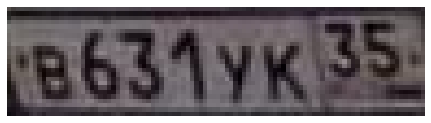

Rotated img:


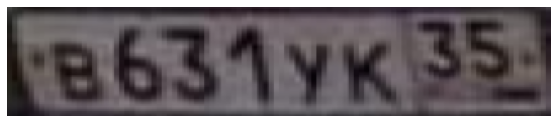

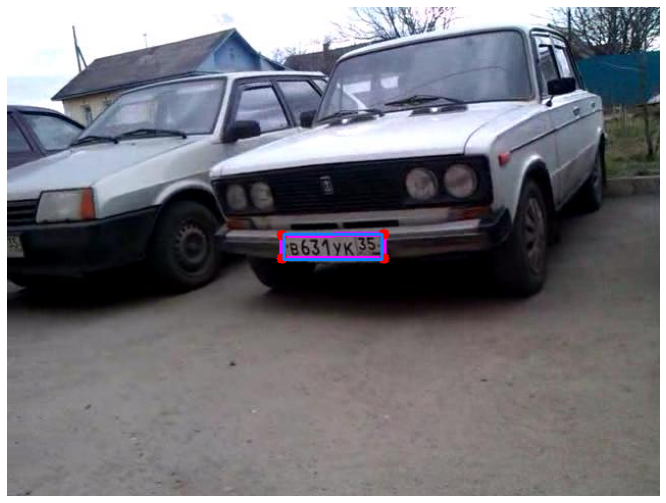

{'boxes': tensor([[271.3941, 223.5260, 367.6107, 248.0234]], device='cuda:0'),
 'labels': tensor([1], device='cuda:0'),
 'masks': tensor([[[[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           ...,
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.]]]], device='cuda:0'),
 'scores': tensor([0.9992], device='cuda:0')}

In [28]:
visualize_prediction_plate(np.random.choice(test_images), model, id_to_name={1: 'plate'}, thresh=0.95)


d) Предсказываем bounding box-ы и маску.



*   Маску превращаем в 4-угольный полигон. Сохраняем предсказания в json
*   Если маска не приближается 4-угольником (редко такое бывает, бинарный поиск по гиперпараметру не работает), то просто записываем координаты bounding box



In [29]:
THRESHOLD_SCORE = 0.93
TRESHOLD_MASK = 0.05

preds = []
model.eval()


for file in tqdm.tqdm(test_images, position=0, leave=False):

    img = Image.open(file).convert('RGB')
    img_tensor = my_transforms(img)
    with torch.no_grad():
        predictions = model([img_tensor.to(device)])
    prediction = predictions[0]

    pred = dict()
    pred['file'] = file
    pred['nums'] = []

    for i in range(len(prediction['boxes'])):
        x_min, y_min, x_max, y_max = map(int, prediction['boxes'][i].tolist())
        label = int(prediction['labels'][i].cpu())
        score = float(prediction['scores'][i].cpu())
        mask = prediction['masks'][i][0, :, :].cpu().numpy()

        if score > THRESHOLD_SCORE:      
            # В разных версиях opencv этот метод возвращает разное число параметров
            # Оставил для версии colab
            contours,_ = cv2.findContours((mask > TRESHOLD_MASK).astype(np.uint8), 1, 1)
#             _,contours,_ = cv2.findContours((mask > TRESHOLD_MASK).astype(np.uint8), 1, 1)
            approx = simplify_contour(contours[0], n_corners=4)
            
            if approx is None:
                x0, y0 = x_min, y_min
                x1, y1 = x_max, y_min
                x2, y2 = x_min, y_max
                x3, y3 = x_max, y_max
            else:
                x0, y0 = approx[0][0][0], approx[0][0][1]
                x1, y1 = approx[1][0][0], approx[1][0][1]
                x2, y2 = approx[2][0][0], approx[2][0][1]
                x3, y3 = approx[3][0][0], approx[3][0][1]
                
            points = [[x0, y0], [x2, y2], [x1, y1],[x3, y3]]

            pred['nums'].append({
                'box': points,
                'bbox': [x_min, y_min, x_max, y_max],
            })

    preds.append(pred)   

    
with open(os.path.join(DATA_PATH, 'test.json'), 'w') as json_file:
    json.dump(preds, json_file, cls=npEncoder)

  0%|          | 0/3188 [00:00<?, ?it/s]/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2854: UserWarning: The default behavior for interpolate/upsample with float scale_factor will change in 1.6.0 to align with other frameworks/libraries, and use scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor will change "
 23%|██▎       | 739/3188 [01:29<04:51,  8.39it/s]

simplify_contour didnt coverege


 32%|███▏      | 1010/3188 [02:02<04:02,  8.96it/s]

simplify_contour didnt coverege


2) Распознаем номера
a) Датасет для распознавания номеров
Из особенностей - на каждый номер мы генерируем bounding box + вырезаем по точкам и превращаем в прямоугольник наш 4-угольник по данным точкам. Т.е. 2 картинки на номер.

In [30]:
class OCRDataset(Dataset):
    def __init__(self, marks, img_folder, alphabet, transforms=None):
        ocr_marks = []
        for items in marks:
            file_path = items['file']
            for box in items['nums']:
                
                ocr_marks.append({
                    'file': file_path,
                    'box': np.clip(box['box'], 0, None).tolist(),
                    'text': box['text'],
                    'boxed': False,
                })
                            
                # Добавим точки, запакованные в BoundingBox. 
                # Вместо аугментации rotate. Датасет будет в 2 раза больше
                
                #Клипаем, ибо есть отрицательные координаты
                points = np.clip(box['box'], 0, None) 
                x0, y0 = np.min(points[:, 0]), np.min(points[:, 1])
                x2, y2 = np.max(points[:, 0]), np.max(points[:, 1])

                ocr_marks.append({
                    'file': file_path,
                    'box': [x0, y0, x2, y2],
                    'text': box['text'],
                    'boxed': True,
                })
                
        self.marks = ocr_marks
        self.img_folder = img_folder
        self.transforms = transforms
        self.alphabet = alphabet
        
    def __getitem__(self, idx):
        item = self.marks[idx]
        img_path = os.path.join(self.img_folder, item["file"])
        img = cv2.imread(img_path)

        if item['boxed']:
            x_min, y_min, x_max, y_max = item['box']
            img = img[y_min:y_max, x_min:x_max]
        else:
            points = np.clip(np.array(item['box']), 0, None)
            img = four_point_transform(img, points)
            
        text = item['text']
        seq = [self.alphabet.find(char) + 1 for char in text]
        seq_len = len(seq)
        
        if self.transforms is not None:
            img = self.transforms(img)

        output = {
            'img': img,
            'text': text,
            'seq': seq,
            'seq_len': seq_len
        }
        
        return output
    
    
    def __len__(self):
        return len(self.marks)
    
    
class Resize(object):
    def __init__(self, size=(320, 64)):
        self.size = size

    def __call__(self, img):

        w_from, h_from = img.shape[1], img.shape[0]
        w_to, h_to = self.size
        
        # Сделаем разную интерполяцию при увеличении и уменьшении
        # Если увеличиваем картинку, меняем интерполяцию
        interpolation = cv2.INTER_AREA
        if w_to > w_from:
            interpolation = cv2.INTER_CUBIC
        
        img = cv2.resize(img, dsize=self.size, interpolation=interpolation)
        return img
    
my_ocr_transforms = transforms.Compose([
    Resize(size=(320, 64)),
    transforms.ToTensor()
])

def get_vocab_from_marks(marks):
    train_texts = []
    for item in marks:
        for num in item['nums']:
            train_texts.append(num['text'])

    counts = Counter(''.join(train_texts))
    alphabet = ''.join(set(''.join(train_texts)))
    corted_counts = sorted(counts.items(), key=lambda x: x[1], reverse=True)
    char_to_idx = {item[0]: idx + 1 for idx, item in enumerate(corted_counts)}
    idx_to_char = {idx:char for char, idx in char_to_idx.items()}
    return char_to_idx, idx_to_char, alphabet

char_to_idx, idx_to_char, alphabet = get_vocab_from_marks(train_marks)

train_ocr_dataset = OCRDataset(
    marks=train_marks, 
    img_folder=DATA_PATH, 
    alphabet=alphabet,
    transforms=my_ocr_transforms
)
val_ocr_dataset = OCRDataset(
    marks=val_marks, 
    img_folder=DATA_PATH, 
    alphabet=alphabet,
    transforms=my_ocr_transforms
)

def collate_fn_ocr(batch):
    """Function for torch.utils.data.Dataloader for batch collecting.
    Accepts list of dataset __get_item__ return values (dicts).
    Returns dict with same keys but values are either torch.Tensors of batched images, sequences, and so.
    """
    images, seqs, seq_lens, texts = [], [], [], []
    for sample in batch:
        images.append(sample["img"])
        seqs.extend(sample["seq"])
        seq_lens.append(sample["seq_len"])
        texts.append(sample["text"])
    images = torch.stack(images)
    seqs = torch.Tensor(seqs).int()
    seq_lens = torch.Tensor(seq_lens).int()
    batch = {"image": images, "seq": seqs, "seq_len": seq_lens, "text": texts}
    return batch

train_ocr_loader = DataLoader(
    train_ocr_dataset, 
    batch_size=BATCH_SIZE_OCR, 
    drop_last=True,
    num_workers=0, # Почему-то у меня виснет DataLoader, если запустить несколько потоков
    collate_fn=collate_fn_ocr,
    timeout=0,
    shuffle=True # Чтобы повернутые дубли картинок не шли подряд
)

val_ocr_loader = DataLoader(
    val_ocr_dataset, 
    batch_size=BATCH_SIZE_OCR, 
    drop_last=False,
    num_workers=0,
    collate_fn=collate_fn_ocr, 
    timeout=0,
)

gc.collect()

0

b) Модель для распознования текста номера

In [31]:
class FeatureExtractor(nn.Module):
    
    def __init__(self, input_size=(64, 320), output_len=20):
        super(FeatureExtractor, self).__init__()
        
        h, w = input_size
        resnet = getattr(models, 'resnet18')(pretrained=True)
        self.cnn = nn.Sequential(*list(resnet.children())[:-2])
        
        self.pool = nn.AvgPool2d(kernel_size=(h // 32, 1))        
        self.proj = nn.Conv2d(w // 32, output_len, kernel_size=1)
  
        self.num_output_features = self.cnn[-1][-1].bn2.num_features    
    
    def apply_projection(self, x):
        """Use convolution to increase width of a features.
        Accepts tensor of features (shaped B x C x H x W).
        Returns new tensor of features (shaped B x C x H x W').
        """
        x = x.permute(0, 3, 2, 1).contiguous()
        x = self.proj(x)
        x = x.permute(0, 2, 3, 1).contiguous()
        return x
   
    def forward(self, x):
        # Apply conv layers
        features = self.cnn(x)
        
        # Pool to make height == 1
        features = self.pool(features)
        
        # Apply projection to increase width
        features = self.apply_projection(features)
        
        return features
    
class SequencePredictor(nn.Module):
    
    def __init__(self, input_size, hidden_size, num_layers, num_classes, dropout=0.3, bidirectional=False):
        super(SequencePredictor, self).__init__()
        
        self.num_classes = num_classes        
        self.rnn = nn.GRU(input_size=input_size,
                       hidden_size=hidden_size,
                       num_layers=num_layers,
                       dropout=dropout,
                       bidirectional=bidirectional)
        
        fc_in = hidden_size if not bidirectional else 2 * hidden_size
        self.fc = nn.Linear(in_features=fc_in,
                         out_features=num_classes)
    
    def _init_hidden_(self, batch_size):
        """Initialize new tensor of zeroes for RNN hidden state.
        Accepts batch size.
        Returns tensor of zeros shaped (num_layers * num_directions, batch, hidden_size).
        """
        num_directions = 2 if self.rnn.bidirectional else 1
        return torch.zeros(self.rnn.num_layers * num_directions, batch_size, self.rnn.hidden_size)
        
    def _prepare_features_(self, x):
        """Change dimensions of x to fit RNN expected input.
        Accepts tensor x shaped (B x (C=1) x H x W).
        Returns new tensor shaped (W x B x H).
        """
        x = x.squeeze(1)
        x = x.permute(2, 0, 1)
        return x
    
    def forward(self, x):
        x = self._prepare_features_(x)
        
        batch_size = x.size(1)
        h_0 = self._init_hidden_(batch_size)
        h_0 = h_0.to(x.device)
        x, h = self.rnn(x, h_0)
        
        x = self.fc(x)
        return x
    
class CRNN(nn.Module):
    
    def __init__(
        self, 
        alphabet=alphabet,
        cnn_input_size=(64, 320), 
        cnn_output_len=20,
        rnn_hidden_size=128, 
        rnn_num_layers=2, 
        rnn_dropout=0.3, 
        rnn_bidirectional=False
    ):
        super(CRNN, self).__init__()
        self.alphabet = alphabet
        
        self.features_extractor = FeatureExtractor(
            input_size=cnn_input_size, 
            output_len=cnn_output_len
        )
        
        self.sequence_predictor = SequencePredictor(
            input_size=self.features_extractor.num_output_features,
            hidden_size=rnn_hidden_size, 
            num_layers=rnn_num_layers,
            num_classes=(len(alphabet) + 1), 
            dropout=rnn_dropout,
            bidirectional=rnn_bidirectional
        )
    
    def forward(self, x):
        features = self.features_extractor(x)
        sequence = self.sequence_predictor(features)
        return sequence

c) Обучаем модель для распознавания текста номера

In [32]:
crnn = CRNN()
# crnn.load_state_dict(torch.load(OCR_MODEL_PATH))
crnn.to(device);

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/checkpoints/resnet18-5c106cde.pth


In [37]:
optimizer = torch.optim.Adam(crnn.parameters(), lr=3e-4, amsgrad=True, weight_decay=1e-5)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=10, factor=0.5, verbose=True)

In [39]:
# Здесь тоже оставил пока обучение без валидации. 
# Может, здесь и стоит валидировать. 
# Но опять же, 1-2 эпох хватает, а значит модель видит почти все данные 
# в первый раз и лосс на трейне вполне отражает реальность

crnn.train()
for epoch in range(5):
    epoch_losses = []
    print_loss = []
    
    for i, batch in enumerate(tqdm.tqdm(train_ocr_loader, total=len(train_ocr_loader), leave=False, position=0)):
        images = batch["image"].to(device)
        seqs_gt = batch["seq"]
        seq_lens_gt = batch["seq_len"]

        seqs_pred = crnn(images).cpu()
        log_probs = F.log_softmax(seqs_pred, dim=2)
        seq_lens_pred = torch.Tensor([seqs_pred.size(0)] * seqs_pred.size(1)).int()

        loss = F.ctc_loss(
            log_probs=log_probs,  # (T, N, C)
            targets=seqs_gt,  # N, S or sum(target_lengths)
            input_lengths=seq_lens_pred,  # N
            target_lengths=seq_lens_gt # N
        )  

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        print_loss.append(loss.item())
        if (i + 1) % 20 == 0:
            mean_loss = np.mean(print_loss)
            print(f'Loss: {mean_loss:.7f}')
            scheduler.step(mean_loss)
            print_loss = [] 
    
        epoch_losses.append(loss.item())

    print(i, np.mean(epoch_losses))

  1%|          | 20/2680 [00:05<12:44,  3.48it/s]

Loss: 2.7877483


  1%|▏         | 40/2680 [00:11<11:04,  3.98it/s]

Loss: 2.7546417


  2%|▏         | 60/2680 [00:16<11:25,  3.82it/s]

Loss: 2.6843844


  3%|▎         | 80/2680 [00:22<12:45,  3.40it/s]

Loss: 2.6052343


  4%|▎         | 100/2680 [00:28<12:45,  3.37it/s]

Loss: 2.6029618


  4%|▍         | 120/2680 [00:34<12:08,  3.51it/s]

Loss: 2.5798286


  5%|▌         | 140/2680 [00:39<11:31,  3.67it/s]

Loss: 2.4569564


  6%|▌         | 160/2680 [00:45<12:13,  3.44it/s]

Loss: 2.4096968


  7%|▋         | 180/2680 [00:51<12:01,  3.46it/s]

Loss: 2.3586828


  7%|▋         | 200/2680 [00:56<11:35,  3.56it/s]

Loss: 2.2670347


  8%|▊         | 220/2680 [01:02<11:59,  3.42it/s]

Loss: 2.2251389


  9%|▉         | 240/2680 [01:07<10:51,  3.75it/s]

Loss: 2.1255978


 10%|▉         | 260/2680 [01:13<12:10,  3.31it/s]

Loss: 2.0213762


 10%|█         | 280/2680 [01:19<11:25,  3.50it/s]

Loss: 1.9903105


 11%|█         | 300/2680 [01:24<10:30,  3.78it/s]

Loss: 1.9134615


 12%|█▏        | 320/2680 [01:30<10:31,  3.74it/s]

Loss: 1.8499692


 13%|█▎        | 340/2680 [01:35<11:41,  3.34it/s]

Loss: 1.7967636


 13%|█▎        | 360/2680 [01:41<10:33,  3.66it/s]

Loss: 1.7318290


 14%|█▍        | 380/2680 [01:47<11:21,  3.37it/s]

Loss: 1.6262694


 15%|█▍        | 400/2680 [01:52<10:11,  3.73it/s]

Loss: 1.5579199


 16%|█▌        | 420/2680 [01:58<11:41,  3.22it/s]

Loss: 1.5122423


 16%|█▋        | 440/2680 [02:04<10:11,  3.66it/s]

Loss: 1.4548967


 17%|█▋        | 460/2680 [02:10<10:45,  3.44it/s]

Loss: 1.4019822


 18%|█▊        | 480/2680 [02:15<09:40,  3.79it/s]

Loss: 1.4098249


 19%|█▊        | 500/2680 [02:21<10:01,  3.62it/s]

Loss: 1.3239547


 19%|█▉        | 520/2680 [02:27<09:40,  3.72it/s]

Loss: 1.2793685


 20%|██        | 540/2680 [02:32<08:52,  4.02it/s]

Loss: 1.2648254


 21%|██        | 560/2680 [02:38<10:24,  3.39it/s]

Loss: 1.1984091


 22%|██▏       | 580/2680 [02:44<09:12,  3.80it/s]

Loss: 1.2135544


 22%|██▏       | 600/2680 [02:50<11:05,  3.12it/s]

Loss: 1.1028982


 23%|██▎       | 620/2680 [02:55<09:56,  3.45it/s]

Loss: 1.0685995


 24%|██▍       | 640/2680 [03:01<09:32,  3.56it/s]

Loss: 1.0090451


 25%|██▍       | 660/2680 [03:07<11:27,  2.94it/s]

Loss: 0.9679801


 25%|██▌       | 680/2680 [03:13<09:04,  3.67it/s]

Loss: 0.9027648


 26%|██▌       | 700/2680 [03:19<09:28,  3.48it/s]

Loss: 0.8478078


 27%|██▋       | 720/2680 [03:25<09:19,  3.51it/s]

Loss: 0.7728273


 28%|██▊       | 740/2680 [03:30<09:03,  3.57it/s]

Loss: 0.7906319


 28%|██▊       | 760/2680 [03:36<10:09,  3.15it/s]

Loss: 0.6747538


 29%|██▉       | 780/2680 [03:42<07:42,  4.11it/s]

Loss: 0.6815091


 30%|██▉       | 800/2680 [03:47<09:32,  3.28it/s]

Loss: 0.6075113


 31%|███       | 821/2680 [03:53<07:31,  4.12it/s]

Loss: 0.5635426


 31%|███▏      | 840/2680 [03:59<08:26,  3.63it/s]

Loss: 0.5375127


 32%|███▏      | 860/2680 [04:04<09:00,  3.37it/s]

Loss: 0.4902044


 33%|███▎      | 880/2680 [04:10<08:21,  3.59it/s]

Loss: 0.5329228


 34%|███▎      | 900/2680 [04:15<09:27,  3.14it/s]

Loss: 0.5320552


 34%|███▍      | 920/2680 [04:21<08:47,  3.34it/s]

Loss: 0.4579397


 35%|███▌      | 940/2680 [04:27<07:47,  3.72it/s]

Loss: 0.4535215


 36%|███▌      | 960/2680 [04:32<08:12,  3.49it/s]

Loss: 0.4328176


 37%|███▋      | 980/2680 [04:38<08:00,  3.54it/s]

Loss: 0.3562061


 37%|███▋      | 1000/2680 [04:43<07:47,  3.60it/s]

Loss: 0.3945778


 38%|███▊      | 1020/2680 [04:49<07:45,  3.57it/s]

Loss: 0.3376797


 39%|███▉      | 1040/2680 [04:55<07:06,  3.85it/s]

Loss: 0.4041906


 40%|███▉      | 1060/2680 [05:00<07:55,  3.41it/s]

Loss: 0.4021739


 40%|████      | 1080/2680 [05:06<07:16,  3.67it/s]

Loss: 0.3844952


 41%|████      | 1100/2680 [05:11<06:30,  4.04it/s]

Loss: 0.3200513


 42%|████▏     | 1120/2680 [05:17<06:56,  3.75it/s]

Loss: 0.2890938


 43%|████▎     | 1140/2680 [05:23<08:00,  3.20it/s]

Loss: 0.3502216


 43%|████▎     | 1160/2680 [05:28<06:29,  3.91it/s]

Loss: 0.3301953


 44%|████▍     | 1180/2680 [05:34<07:35,  3.29it/s]

Loss: 0.3501619


 45%|████▍     | 1200/2680 [05:39<06:22,  3.87it/s]

Loss: 0.2963157


 46%|████▌     | 1220/2680 [05:45<07:23,  3.30it/s]

Loss: 0.3089858


 46%|████▋     | 1240/2680 [05:50<06:37,  3.62it/s]

Loss: 0.2880700


 47%|████▋     | 1260/2680 [05:56<06:12,  3.82it/s]

Loss: 0.3238207


 48%|████▊     | 1280/2680 [06:01<06:10,  3.78it/s]

Loss: 0.2937023


 49%|████▊     | 1300/2680 [06:07<06:31,  3.52it/s]

Loss: 0.2803984


 49%|████▉     | 1320/2680 [06:12<05:26,  4.17it/s]

Loss: 0.2654444


 50%|█████     | 1340/2680 [06:18<05:42,  3.92it/s]

Loss: 0.2375813


 51%|█████     | 1360/2680 [06:24<05:38,  3.89it/s]

Loss: 0.2491483


 51%|█████▏    | 1380/2680 [06:29<06:17,  3.44it/s]

Loss: 0.2257638


 52%|█████▏    | 1400/2680 [06:35<06:36,  3.23it/s]

Loss: 0.2388236


 53%|█████▎    | 1420/2680 [06:40<05:52,  3.57it/s]

Loss: 0.2751194


 54%|█████▎    | 1440/2680 [06:46<05:39,  3.65it/s]

Loss: 0.2305210


 54%|█████▍    | 1460/2680 [06:51<06:14,  3.25it/s]

Loss: 0.2434707


 55%|█████▌    | 1480/2680 [06:57<05:40,  3.52it/s]

Loss: 0.2220656


 56%|█████▌    | 1500/2680 [07:03<05:38,  3.48it/s]

Loss: 0.2291782


 57%|█████▋    | 1520/2680 [07:08<05:22,  3.60it/s]

Loss: 0.2465684


 57%|█████▋    | 1540/2680 [07:14<04:56,  3.84it/s]

Loss: 0.2645855


 58%|█████▊    | 1560/2680 [07:20<05:12,  3.59it/s]

Loss: 0.2136730


 59%|█████▉    | 1580/2680 [07:26<04:58,  3.69it/s]

Loss: 0.2407622


 60%|█████▉    | 1600/2680 [07:31<05:18,  3.39it/s]

Loss: 0.2301116


 60%|██████    | 1620/2680 [07:37<04:58,  3.56it/s]

Loss: 0.2111508


 61%|██████    | 1640/2680 [07:42<04:51,  3.57it/s]

Loss: 0.2207006


 62%|██████▏   | 1661/2680 [07:48<04:43,  3.59it/s]

Loss: 0.1928927


 63%|██████▎   | 1680/2680 [07:54<04:34,  3.65it/s]

Loss: 0.2706012


 63%|██████▎   | 1700/2680 [08:00<04:57,  3.29it/s]

Loss: 0.2010867


 64%|██████▍   | 1720/2680 [08:05<04:27,  3.59it/s]

Loss: 0.2392405


 65%|██████▍   | 1741/2680 [08:11<03:49,  4.09it/s]

Loss: 0.1933028


 66%|██████▌   | 1760/2680 [08:16<04:05,  3.74it/s]

Loss: 0.1824336


 66%|██████▋   | 1780/2680 [08:22<03:49,  3.91it/s]

Loss: 0.1901265


 67%|██████▋   | 1800/2680 [08:28<04:05,  3.59it/s]

Loss: 0.1835603


 68%|██████▊   | 1820/2680 [08:34<04:03,  3.53it/s]

Loss: 0.1976015


 69%|██████▊   | 1840/2680 [08:39<03:59,  3.51it/s]

Loss: 0.2106834


 69%|██████▉   | 1860/2680 [08:45<03:39,  3.74it/s]

Loss: 0.2231197


 70%|███████   | 1880/2680 [08:51<03:52,  3.43it/s]

Loss: 0.2326503


 71%|███████   | 1900/2680 [08:57<04:15,  3.05it/s]

Loss: 0.1982482


 72%|███████▏  | 1920/2680 [09:02<03:14,  3.90it/s]

Loss: 0.2355665


 72%|███████▏  | 1941/2680 [09:08<03:17,  3.74it/s]

Loss: 0.2028996


 73%|███████▎  | 1960/2680 [09:13<03:11,  3.76it/s]

Loss: 0.2490538


 74%|███████▍  | 1980/2680 [09:19<03:06,  3.75it/s]

Loss: 0.2179878
Epoch   109: reducing learning rate of group 0 to 1.5000e-04.


 75%|███████▍  | 2000/2680 [09:25<03:35,  3.15it/s]

Loss: 0.1921747


 75%|███████▌  | 2020/2680 [09:31<03:01,  3.64it/s]

Loss: 0.2493941


 76%|███████▌  | 2040/2680 [09:37<02:50,  3.75it/s]

Loss: 0.1667094


 77%|███████▋  | 2060/2680 [09:43<02:58,  3.47it/s]

Loss: 0.1819978


 78%|███████▊  | 2080/2680 [09:48<03:00,  3.32it/s]

Loss: 0.1675653


 78%|███████▊  | 2100/2680 [09:54<03:00,  3.21it/s]

Loss: 0.1882471


 79%|███████▉  | 2120/2680 [10:00<02:57,  3.16it/s]

Loss: 0.1961780


 80%|███████▉  | 2141/2680 [10:06<02:30,  3.58it/s]

Loss: 0.1923484


 81%|████████  | 2160/2680 [10:11<02:30,  3.45it/s]

Loss: 0.1798668


 81%|████████▏ | 2180/2680 [10:17<02:15,  3.70it/s]

Loss: 0.1906868


 82%|████████▏ | 2200/2680 [10:23<02:03,  3.88it/s]

Loss: 0.1769128


 83%|████████▎ | 2220/2680 [10:29<02:33,  3.00it/s]

Loss: 0.1614416


 84%|████████▎ | 2240/2680 [10:34<02:00,  3.65it/s]

Loss: 0.1209706


 84%|████████▍ | 2260/2680 [10:40<02:07,  3.28it/s]

Loss: 0.1370521


 85%|████████▌ | 2280/2680 [10:46<01:42,  3.89it/s]

Loss: 0.1795772


 86%|████████▌ | 2300/2680 [10:51<01:43,  3.66it/s]

Loss: 0.1442021


 87%|████████▋ | 2320/2680 [10:57<01:48,  3.33it/s]

Loss: 0.1094746


 87%|████████▋ | 2340/2680 [11:03<01:35,  3.57it/s]

Loss: 0.1514917


 88%|████████▊ | 2360/2680 [11:09<01:53,  2.82it/s]

Loss: 0.1545630


 89%|████████▉ | 2380/2680 [11:15<01:19,  3.76it/s]

Loss: 0.1546812


 90%|████████▉ | 2400/2680 [11:20<01:26,  3.25it/s]

Loss: 0.1786376


 90%|█████████ | 2420/2680 [11:26<01:11,  3.65it/s]

Loss: 0.1463924


 91%|█████████ | 2440/2680 [11:32<01:05,  3.66it/s]

Loss: 0.1407112


 92%|█████████▏| 2460/2680 [11:38<01:01,  3.57it/s]

Loss: 0.1577976


 93%|█████████▎| 2480/2680 [11:44<00:59,  3.37it/s]

Loss: 0.1667353


 93%|█████████▎| 2500/2680 [11:49<00:47,  3.81it/s]

Loss: 0.1847242


 94%|█████████▍| 2520/2680 [11:55<00:46,  3.42it/s]

Loss: 0.2202884


 95%|█████████▍| 2540/2680 [12:01<00:42,  3.28it/s]

Loss: 0.1588170
Epoch   137: reducing learning rate of group 0 to 7.5000e-05.


 96%|█████████▌| 2560/2680 [12:07<00:33,  3.59it/s]

Loss: 0.1500905


 96%|█████████▋| 2580/2680 [12:13<00:28,  3.55it/s]

Loss: 0.1820773


 97%|█████████▋| 2600/2680 [12:18<00:22,  3.57it/s]

Loss: 0.1442786


 98%|█████████▊| 2620/2680 [12:24<00:15,  3.97it/s]

Loss: 0.1455744


 99%|█████████▊| 2640/2680 [12:29<00:10,  3.67it/s]

Loss: 0.1448120


 99%|█████████▉| 2660/2680 [12:35<00:05,  3.39it/s]

Loss: 0.1447038


  0%|          | 0/2680 [00:00<?, ?it/s]

Loss: 0.1340991
2679 0.6642018474680164


  1%|          | 20/2680 [00:05<13:08,  3.37it/s]

Loss: 0.1310099


  1%|▏         | 40/2680 [00:11<13:25,  3.28it/s]

Loss: 0.1057921


  2%|▏         | 60/2680 [00:17<12:27,  3.50it/s]

Loss: 0.1406058


  3%|▎         | 80/2680 [00:23<13:07,  3.30it/s]

Loss: 0.1225479


  4%|▎         | 100/2680 [00:28<13:02,  3.30it/s]

Loss: 0.1026347


  4%|▍         | 120/2680 [00:34<12:43,  3.35it/s]

Loss: 0.1600718


  5%|▌         | 140/2680 [00:40<11:40,  3.62it/s]

Loss: 0.1394102


  6%|▌         | 160/2680 [00:46<12:27,  3.37it/s]

Loss: 0.1534111


  7%|▋         | 181/2680 [00:52<09:59,  4.17it/s]

Loss: 0.1602022


  7%|▋         | 200/2680 [00:57<11:22,  3.63it/s]

Loss: 0.1599649


  8%|▊         | 220/2680 [01:03<11:25,  3.59it/s]

Loss: 0.1158908


  9%|▉         | 240/2680 [01:09<12:02,  3.38it/s]

Loss: 0.1348666


 10%|▉         | 260/2680 [01:14<11:05,  3.64it/s]

Loss: 0.1242284


 10%|█         | 280/2680 [01:20<10:01,  3.99it/s]

Loss: 0.1601253


 11%|█         | 300/2680 [01:25<10:36,  3.74it/s]

Loss: 0.1747717


 12%|█▏        | 320/2680 [01:31<11:12,  3.51it/s]

Loss: 0.1664035
Epoch   160: reducing learning rate of group 0 to 3.7500e-05.


 13%|█▎        | 340/2680 [01:36<10:31,  3.71it/s]

Loss: 0.1282426


 13%|█▎        | 360/2680 [01:42<11:44,  3.29it/s]

Loss: 0.1475587


 14%|█▍        | 380/2680 [01:48<10:46,  3.56it/s]

Loss: 0.1258170


 15%|█▍        | 400/2680 [01:54<10:21,  3.67it/s]

Loss: 0.1131678


 16%|█▌        | 421/2680 [01:59<09:27,  3.98it/s]

Loss: 0.1452324


 16%|█▋        | 440/2680 [02:04<10:47,  3.46it/s]

Loss: 0.1278642


 17%|█▋        | 460/2680 [02:10<10:37,  3.48it/s]

Loss: 0.1467885


 18%|█▊        | 481/2680 [02:16<08:31,  4.30it/s]

Loss: 0.1186188


 19%|█▊        | 500/2680 [02:21<09:06,  3.99it/s]

Loss: 0.1468427


 19%|█▉        | 520/2680 [02:27<09:16,  3.88it/s]

Loss: 0.1282299


 20%|██        | 540/2680 [02:32<10:21,  3.45it/s]

Loss: 0.1249568
Epoch   171: reducing learning rate of group 0 to 1.8750e-05.


 21%|██        | 560/2680 [02:38<10:02,  3.52it/s]

Loss: 0.1303054


 22%|██▏       | 580/2680 [02:43<09:06,  3.84it/s]

Loss: 0.1189509


 22%|██▏       | 600/2680 [02:49<10:21,  3.35it/s]

Loss: 0.1432985


 23%|██▎       | 620/2680 [02:55<09:54,  3.46it/s]

Loss: 0.1549534


 24%|██▍       | 640/2680 [03:00<09:29,  3.58it/s]

Loss: 0.1038625


 25%|██▍       | 660/2680 [03:06<09:09,  3.68it/s]

Loss: 0.1144601


 25%|██▌       | 680/2680 [03:11<08:41,  3.84it/s]

Loss: 0.1239371


 26%|██▌       | 700/2680 [03:16<09:32,  3.46it/s]

Loss: 0.1621772


 27%|██▋       | 720/2680 [03:22<09:21,  3.49it/s]

Loss: 0.1454627


 28%|██▊       | 740/2680 [03:28<08:03,  4.01it/s]

Loss: 0.1350730


 28%|██▊       | 760/2680 [03:33<08:52,  3.60it/s]

Loss: 0.1253391
Epoch   182: reducing learning rate of group 0 to 9.3750e-06.


 29%|██▉       | 780/2680 [03:39<08:54,  3.56it/s]

Loss: 0.1147060


 30%|██▉       | 800/2680 [03:44<07:43,  4.06it/s]

Loss: 0.1495792


 31%|███       | 820/2680 [03:50<08:42,  3.56it/s]

Loss: 0.1305885


 31%|███▏      | 840/2680 [03:56<08:58,  3.42it/s]

Loss: 0.1666550


 32%|███▏      | 861/2680 [04:01<07:47,  3.89it/s]

Loss: 0.1328764


 33%|███▎      | 880/2680 [04:07<08:57,  3.35it/s]

Loss: 0.1189457


 34%|███▎      | 900/2680 [04:13<08:25,  3.52it/s]

Loss: 0.1501840


 34%|███▍      | 920/2680 [04:18<09:10,  3.20it/s]

Loss: 0.1421173


 35%|███▌      | 940/2680 [04:24<08:02,  3.61it/s]

Loss: 0.1232100


 36%|███▌      | 960/2680 [04:29<08:37,  3.32it/s]

Loss: 0.1159812


 37%|███▋      | 980/2680 [04:36<07:25,  3.81it/s]

Loss: 0.1362232
Epoch   193: reducing learning rate of group 0 to 4.6875e-06.


 37%|███▋      | 1000/2680 [04:41<07:11,  3.89it/s]

Loss: 0.1512750


 38%|███▊      | 1020/2680 [04:47<08:18,  3.33it/s]

Loss: 0.1447810


 39%|███▉      | 1041/2680 [04:53<07:43,  3.54it/s]

Loss: 0.1071992


 40%|███▉      | 1060/2680 [04:58<07:30,  3.59it/s]

Loss: 0.1538957


 40%|████      | 1080/2680 [05:04<07:57,  3.35it/s]

Loss: 0.1073907


 41%|████      | 1100/2680 [05:10<08:35,  3.07it/s]

Loss: 0.1223470


 42%|████▏     | 1120/2680 [05:15<08:08,  3.19it/s]

Loss: 0.1296589


 43%|████▎     | 1140/2680 [05:21<07:59,  3.21it/s]

Loss: 0.1271655


 43%|████▎     | 1161/2680 [05:27<06:33,  3.86it/s]

Loss: 0.1331448


 44%|████▍     | 1180/2680 [05:33<06:59,  3.58it/s]

Loss: 0.1214048


 45%|████▍     | 1200/2680 [05:39<08:18,  2.97it/s]

Loss: 0.1214392
Epoch   204: reducing learning rate of group 0 to 2.3437e-06.


 46%|████▌     | 1220/2680 [05:44<06:57,  3.49it/s]

Loss: 0.1165186


 46%|████▋     | 1240/2680 [05:50<07:44,  3.10it/s]

Loss: 0.0943065


 47%|████▋     | 1260/2680 [05:56<06:23,  3.71it/s]

Loss: 0.1102116


 48%|████▊     | 1281/2680 [06:01<05:43,  4.08it/s]

Loss: 0.1444677


 49%|████▊     | 1301/2680 [06:08<06:26,  3.57it/s]

Loss: 0.1240694


 49%|████▉     | 1320/2680 [06:13<07:22,  3.07it/s]

Loss: 0.1283584


 50%|█████     | 1340/2680 [06:19<05:55,  3.77it/s]

Loss: 0.1485523


 51%|█████     | 1360/2680 [06:24<06:04,  3.62it/s]

Loss: 0.1580912


 51%|█████▏    | 1380/2680 [06:30<05:42,  3.79it/s]

Loss: 0.1392117


 52%|█████▏    | 1400/2680 [06:35<05:50,  3.66it/s]

Loss: 0.1587412


 53%|█████▎    | 1420/2680 [06:41<05:55,  3.55it/s]

Loss: 0.1536043


 54%|█████▎    | 1440/2680 [06:46<05:07,  4.04it/s]

Loss: 0.1155169


 54%|█████▍    | 1460/2680 [06:52<05:39,  3.59it/s]

Loss: 0.1144339
Epoch   217: reducing learning rate of group 0 to 1.1719e-06.


 55%|█████▌    | 1480/2680 [06:58<04:58,  4.02it/s]

Loss: 0.1202171


 56%|█████▌    | 1500/2680 [07:04<05:29,  3.58it/s]

Loss: 0.1338186


 57%|█████▋    | 1521/2680 [07:09<05:19,  3.63it/s]

Loss: 0.1808210


 57%|█████▋    | 1540/2680 [07:15<05:37,  3.38it/s]

Loss: 0.1259128


 58%|█████▊    | 1560/2680 [07:20<05:37,  3.32it/s]

Loss: 0.1424142


 59%|█████▉    | 1580/2680 [07:26<04:34,  4.00it/s]

Loss: 0.1287392


 60%|█████▉    | 1600/2680 [07:32<06:17,  2.86it/s]

Loss: 0.1229282


 60%|██████    | 1620/2680 [07:37<04:25,  3.99it/s]

Loss: 0.1040797


 61%|██████    | 1640/2680 [07:43<04:49,  3.60it/s]

Loss: 0.1374133


 62%|██████▏   | 1660/2680 [07:48<04:47,  3.55it/s]

Loss: 0.1394279


 63%|██████▎   | 1680/2680 [07:54<04:15,  3.92it/s]

Loss: 0.1157365
Epoch   228: reducing learning rate of group 0 to 5.8594e-07.


 63%|██████▎   | 1700/2680 [07:59<04:36,  3.54it/s]

Loss: 0.1737782


 64%|██████▍   | 1720/2680 [08:05<05:12,  3.07it/s]

Loss: 0.1313010


 65%|██████▍   | 1740/2680 [08:11<04:59,  3.14it/s]

Loss: 0.1312241


 66%|██████▌   | 1760/2680 [08:17<03:51,  3.98it/s]

Loss: 0.1293971


 66%|██████▋   | 1780/2680 [08:22<03:56,  3.80it/s]

Loss: 0.1526699


 67%|██████▋   | 1800/2680 [08:27<03:47,  3.86it/s]

Loss: 0.1241268


 68%|██████▊   | 1820/2680 [08:33<04:03,  3.54it/s]

Loss: 0.1403883


 69%|██████▊   | 1840/2680 [08:39<03:27,  4.06it/s]

Loss: 0.1270644


 69%|██████▉   | 1860/2680 [08:45<03:41,  3.70it/s]

Loss: 0.1538929


 70%|███████   | 1880/2680 [08:50<03:44,  3.56it/s]

Loss: 0.1070001


 71%|███████   | 1900/2680 [08:56<03:21,  3.88it/s]

Loss: 0.1451667
Epoch   239: reducing learning rate of group 0 to 2.9297e-07.


 72%|███████▏  | 1920/2680 [09:01<03:29,  3.63it/s]

Loss: 0.1546577


 72%|███████▏  | 1940/2680 [09:07<03:49,  3.22it/s]

Loss: 0.1495891


 73%|███████▎  | 1960/2680 [09:12<03:26,  3.48it/s]

Loss: 0.1400350


 74%|███████▍  | 1980/2680 [09:18<03:12,  3.63it/s]

Loss: 0.1415774


 75%|███████▍  | 2000/2680 [09:24<02:55,  3.88it/s]

Loss: 0.1237605


 75%|███████▌  | 2020/2680 [09:30<03:16,  3.35it/s]

Loss: 0.1662229


 76%|███████▌  | 2040/2680 [09:36<03:07,  3.41it/s]

Loss: 0.1478959


 77%|███████▋  | 2060/2680 [09:41<03:09,  3.27it/s]

Loss: 0.1039044


 78%|███████▊  | 2080/2680 [09:47<03:02,  3.28it/s]

Loss: 0.1098008


 78%|███████▊  | 2100/2680 [09:52<02:34,  3.76it/s]

Loss: 0.1290015


 79%|███████▉  | 2120/2680 [09:58<02:28,  3.77it/s]

Loss: 0.1514753
Epoch   250: reducing learning rate of group 0 to 1.4648e-07.


 80%|███████▉  | 2140/2680 [10:03<02:47,  3.22it/s]

Loss: 0.1212293


 81%|████████  | 2160/2680 [10:09<02:26,  3.54it/s]

Loss: 0.1418075


 81%|████████▏ | 2180/2680 [10:15<02:12,  3.79it/s]

Loss: 0.1330808


 82%|████████▏ | 2200/2680 [10:21<02:31,  3.18it/s]

Loss: 0.1184510


 83%|████████▎ | 2220/2680 [10:26<01:59,  3.85it/s]

Loss: 0.1319633


 84%|████████▎ | 2240/2680 [10:32<02:13,  3.29it/s]

Loss: 0.1733557


 84%|████████▍ | 2260/2680 [10:38<01:58,  3.54it/s]

Loss: 0.1370039


 85%|████████▌ | 2281/2680 [10:43<01:40,  3.99it/s]

Loss: 0.1072263


 86%|████████▌ | 2300/2680 [10:49<01:44,  3.64it/s]

Loss: 0.1248641


 87%|████████▋ | 2320/2680 [10:54<01:46,  3.38it/s]

Loss: 0.1187568


 87%|████████▋ | 2340/2680 [11:00<01:23,  4.08it/s]

Loss: 0.1268812
Epoch   261: reducing learning rate of group 0 to 7.3242e-08.


 88%|████████▊ | 2360/2680 [11:05<01:27,  3.65it/s]

Loss: 0.1420571


 89%|████████▉ | 2380/2680 [11:11<01:32,  3.24it/s]

Loss: 0.1307273


 90%|████████▉ | 2400/2680 [11:17<01:16,  3.68it/s]

Loss: 0.1168089


 90%|█████████ | 2420/2680 [11:22<01:09,  3.76it/s]

Loss: 0.1221392


 91%|█████████ | 2440/2680 [11:28<01:11,  3.36it/s]

Loss: 0.1344820


 92%|█████████▏| 2460/2680 [11:33<01:04,  3.43it/s]

Loss: 0.1486461


 93%|█████████▎| 2480/2680 [11:39<00:56,  3.53it/s]

Loss: 0.1131043


 93%|█████████▎| 2500/2680 [11:45<00:54,  3.30it/s]

Loss: 0.1591246


 94%|█████████▍| 2520/2680 [11:50<00:44,  3.60it/s]

Loss: 0.1492176


 95%|█████████▍| 2540/2680 [11:56<00:38,  3.66it/s]

Loss: 0.1337820


 96%|█████████▌| 2560/2680 [12:02<00:33,  3.61it/s]

Loss: 0.1497989
Epoch   272: reducing learning rate of group 0 to 3.6621e-08.


 96%|█████████▋| 2580/2680 [12:08<00:29,  3.44it/s]

Loss: 0.1177461


 97%|█████████▋| 2600/2680 [12:13<00:21,  3.69it/s]

Loss: 0.1123077


 98%|█████████▊| 2620/2680 [12:19<00:16,  3.72it/s]

Loss: 0.1442920


 99%|█████████▊| 2640/2680 [12:25<00:12,  3.33it/s]

Loss: 0.1012432


 99%|█████████▉| 2660/2680 [12:30<00:05,  3.87it/s]

Loss: 0.1303081


  0%|          | 0/2680 [00:00<?, ?it/s]

Loss: 0.1119418
2679 0.13363965410433376


  1%|          | 20/2680 [00:05<12:41,  3.49it/s]

Loss: 0.1163850


  1%|▏         | 40/2680 [00:11<12:29,  3.52it/s]

Loss: 0.1318977


  2%|▏         | 60/2680 [00:16<12:10,  3.59it/s]

Loss: 0.1178135


  3%|▎         | 80/2680 [00:22<12:35,  3.44it/s]

Loss: 0.1537314


  4%|▎         | 100/2680 [00:28<13:08,  3.27it/s]

Loss: 0.1006239
Epoch   283: reducing learning rate of group 0 to 1.8311e-08.


  4%|▍         | 120/2680 [00:33<13:11,  3.23it/s]

Loss: 0.0858589


  5%|▌         | 140/2680 [00:39<10:31,  4.02it/s]

Loss: 0.1244528


  6%|▌         | 160/2680 [00:45<12:43,  3.30it/s]

Loss: 0.1390143


  7%|▋         | 180/2680 [00:51<12:38,  3.30it/s]

Loss: 0.1468797


  7%|▋         | 200/2680 [00:57<10:24,  3.97it/s]

Loss: 0.1306206


  8%|▊         | 220/2680 [01:03<10:33,  3.88it/s]

Loss: 0.1372708


  9%|▉         | 240/2680 [01:08<11:32,  3.52it/s]

Loss: 0.1297672


 10%|▉         | 260/2680 [01:14<12:45,  3.16it/s]

Loss: 0.1294819


 10%|█         | 280/2680 [01:19<12:00,  3.33it/s]

Loss: 0.1399739


 11%|█         | 300/2680 [01:25<11:07,  3.57it/s]

Loss: 0.1233551


 12%|█▏        | 320/2680 [01:31<12:24,  3.17it/s]

Loss: 0.1487815


 13%|█▎        | 340/2680 [01:37<11:14,  3.47it/s]

Loss: 0.1339209


 13%|█▎        | 360/2680 [01:42<10:26,  3.70it/s]

Loss: 0.1208975


 14%|█▍        | 380/2680 [01:48<10:31,  3.64it/s]

Loss: 0.1149590


 15%|█▍        | 400/2680 [01:54<10:27,  3.63it/s]

Loss: 0.1074781


 16%|█▌        | 420/2680 [01:59<11:07,  3.39it/s]

Loss: 0.0959623


 16%|█▋        | 440/2680 [02:05<11:47,  3.17it/s]

Loss: 0.1565758


 17%|█▋        | 460/2680 [02:10<09:05,  4.07it/s]

Loss: 0.1089887


 18%|█▊        | 480/2680 [02:16<10:34,  3.47it/s]

Loss: 0.1166722


 19%|█▊        | 500/2680 [02:22<09:40,  3.75it/s]

Loss: 0.1744816


 19%|█▉        | 520/2680 [02:28<11:00,  3.27it/s]

Loss: 0.1170028


 20%|██        | 540/2680 [02:34<10:19,  3.45it/s]

Loss: 0.1046819


 21%|██        | 560/2680 [02:40<08:59,  3.93it/s]

Loss: 0.1090715


 22%|██▏       | 580/2680 [02:46<10:40,  3.28it/s]

Loss: 0.1413482


 22%|██▏       | 600/2680 [02:51<08:20,  4.16it/s]

Loss: 0.1081132


 23%|██▎       | 620/2680 [02:57<10:06,  3.40it/s]

Loss: 0.1407051


 24%|██▍       | 640/2680 [03:02<08:46,  3.88it/s]

Loss: 0.1235165


 25%|██▍       | 660/2680 [03:08<09:24,  3.58it/s]

Loss: 0.0882046


 25%|██▌       | 680/2680 [03:14<09:55,  3.36it/s]

Loss: 0.1279302


 26%|██▌       | 700/2680 [03:20<09:13,  3.58it/s]

Loss: 0.1424140


 27%|██▋       | 720/2680 [03:25<08:40,  3.77it/s]

Loss: 0.1342787


 28%|██▊       | 740/2680 [03:31<10:30,  3.07it/s]

Loss: 0.1414647


 28%|██▊       | 760/2680 [03:37<09:12,  3.47it/s]

Loss: 0.1447031


 29%|██▉       | 780/2680 [03:42<08:42,  3.63it/s]

Loss: 0.1375873


 30%|██▉       | 800/2680 [03:48<09:16,  3.38it/s]

Loss: 0.0981289


 31%|███       | 820/2680 [03:54<09:38,  3.22it/s]

Loss: 0.1453368


 31%|███▏      | 840/2680 [03:59<08:20,  3.67it/s]

Loss: 0.0970171


 32%|███▏      | 860/2680 [04:05<08:12,  3.70it/s]

Loss: 0.1149411


 33%|███▎      | 880/2680 [04:10<09:00,  3.33it/s]

Loss: 0.1212030


 34%|███▎      | 900/2680 [04:16<08:43,  3.40it/s]

Loss: 0.1088285


 34%|███▍      | 920/2680 [04:21<07:39,  3.83it/s]

Loss: 0.1591714


 35%|███▌      | 940/2680 [04:27<07:33,  3.84it/s]

Loss: 0.1315380


 36%|███▌      | 960/2680 [04:32<08:18,  3.45it/s]

Loss: 0.1196954


 37%|███▋      | 980/2680 [04:38<07:53,  3.59it/s]

Loss: 0.1303435


 37%|███▋      | 1000/2680 [04:43<08:20,  3.36it/s]

Loss: 0.1344968


 38%|███▊      | 1020/2680 [04:49<08:52,  3.12it/s]

Loss: 0.1070481


 39%|███▉      | 1040/2680 [04:55<07:52,  3.47it/s]

Loss: 0.1547163


 40%|███▉      | 1060/2680 [05:00<07:30,  3.59it/s]

Loss: 0.1446476


 40%|████      | 1080/2680 [05:06<07:36,  3.51it/s]

Loss: 0.1132475


 41%|████      | 1100/2680 [05:12<07:00,  3.76it/s]

Loss: 0.1105582


 42%|████▏     | 1120/2680 [05:17<06:45,  3.85it/s]

Loss: 0.0906658


 43%|████▎     | 1140/2680 [05:23<06:53,  3.72it/s]

Loss: 0.0916894


 43%|████▎     | 1160/2680 [05:28<07:25,  3.41it/s]

Loss: 0.1303096


 44%|████▍     | 1180/2680 [05:34<07:44,  3.23it/s]

Loss: 0.1119541


 45%|████▍     | 1200/2680 [05:40<07:13,  3.42it/s]

Loss: 0.1319225


 46%|████▌     | 1220/2680 [05:46<07:15,  3.36it/s]

Loss: 0.1137253


 46%|████▋     | 1240/2680 [05:51<05:25,  4.43it/s]

Loss: 0.1108381


 47%|████▋     | 1260/2680 [05:57<06:24,  3.70it/s]

Loss: 0.1158827


 48%|████▊     | 1280/2680 [06:02<06:31,  3.57it/s]

Loss: 0.1097279


 49%|████▊     | 1300/2680 [06:08<05:52,  3.92it/s]

Loss: 0.1571403


 49%|████▉     | 1320/2680 [06:14<07:03,  3.21it/s]

Loss: 0.1418319


 50%|█████     | 1340/2680 [06:20<06:01,  3.71it/s]

Loss: 0.1035564


 51%|█████     | 1360/2680 [06:25<05:45,  3.82it/s]

Loss: 0.1619896


 51%|█████▏    | 1380/2680 [06:31<06:17,  3.44it/s]

Loss: 0.1191605


 52%|█████▏    | 1400/2680 [06:37<05:45,  3.71it/s]

Loss: 0.1087880


 53%|█████▎    | 1420/2680 [06:42<05:06,  4.11it/s]

Loss: 0.0898036


 54%|█████▍    | 1441/2680 [06:47<05:04,  4.07it/s]

Loss: 0.1463294


 54%|█████▍    | 1460/2680 [06:53<06:34,  3.09it/s]

Loss: 0.1415419


 55%|█████▌    | 1480/2680 [06:58<04:57,  4.04it/s]

Loss: 0.1157000


 56%|█████▌    | 1500/2680 [07:04<05:53,  3.34it/s]

Loss: 0.1379228


 57%|█████▋    | 1520/2680 [07:09<05:07,  3.77it/s]

Loss: 0.1501585


 57%|█████▋    | 1540/2680 [07:15<05:32,  3.43it/s]

Loss: 0.1375849


 58%|█████▊    | 1561/2680 [07:21<04:45,  3.91it/s]

Loss: 0.1292755


 59%|█████▉    | 1580/2680 [07:27<06:35,  2.78it/s]

Loss: 0.1214835


 60%|█████▉    | 1600/2680 [07:33<05:00,  3.60it/s]

Loss: 0.1444553


 60%|██████    | 1620/2680 [07:38<04:32,  3.89it/s]

Loss: 0.1278490


 61%|██████    | 1640/2680 [07:44<04:52,  3.55it/s]

Loss: 0.1503087


 62%|██████▏   | 1660/2680 [07:50<05:21,  3.17it/s]

Loss: 0.1228759


 63%|██████▎   | 1680/2680 [07:55<04:58,  3.35it/s]

Loss: 0.1176991


 63%|██████▎   | 1700/2680 [08:01<04:56,  3.31it/s]

Loss: 0.1294703


 64%|██████▍   | 1720/2680 [08:07<04:24,  3.63it/s]

Loss: 0.1191677


 65%|██████▍   | 1740/2680 [08:13<04:39,  3.36it/s]

Loss: 0.1468350


 66%|██████▌   | 1760/2680 [08:18<04:18,  3.56it/s]

Loss: 0.1534097


 66%|██████▋   | 1780/2680 [08:24<04:15,  3.53it/s]

Loss: 0.1646031


 67%|██████▋   | 1800/2680 [08:30<04:11,  3.49it/s]

Loss: 0.1308119


 68%|██████▊   | 1820/2680 [08:36<04:09,  3.45it/s]

Loss: 0.1716579


 69%|██████▊   | 1840/2680 [08:42<03:51,  3.62it/s]

Loss: 0.1320872


 69%|██████▉   | 1860/2680 [08:47<03:59,  3.43it/s]

Loss: 0.1636793


 70%|███████   | 1880/2680 [08:52<03:40,  3.63it/s]

Loss: 0.1379074


 71%|███████   | 1900/2680 [08:58<03:15,  4.00it/s]

Loss: 0.1107186


 72%|███████▏  | 1920/2680 [09:04<03:32,  3.58it/s]

Loss: 0.1182648


 72%|███████▏  | 1940/2680 [09:09<03:45,  3.28it/s]

Loss: 0.1418007


 73%|███████▎  | 1960/2680 [09:15<03:17,  3.65it/s]

Loss: 0.1345347


 74%|███████▍  | 1980/2680 [09:20<02:53,  4.04it/s]

Loss: 0.1340515


 75%|███████▍  | 2000/2680 [09:26<03:01,  3.75it/s]

Loss: 0.1305938


 75%|███████▌  | 2020/2680 [09:32<02:57,  3.71it/s]

Loss: 0.1246996


 76%|███████▌  | 2040/2680 [09:37<03:07,  3.41it/s]

Loss: 0.1290214


 77%|███████▋  | 2060/2680 [09:43<02:40,  3.86it/s]

Loss: 0.1485296


 78%|███████▊  | 2080/2680 [09:49<02:59,  3.34it/s]

Loss: 0.1462979


 78%|███████▊  | 2100/2680 [09:55<02:49,  3.41it/s]

Loss: 0.1365458


 79%|███████▉  | 2120/2680 [10:01<02:30,  3.73it/s]

Loss: 0.1385188


 80%|███████▉  | 2140/2680 [10:07<02:37,  3.42it/s]

Loss: 0.1755421


 81%|████████  | 2160/2680 [10:12<02:27,  3.52it/s]

Loss: 0.1290592


 81%|████████▏ | 2180/2680 [10:18<02:24,  3.45it/s]

Loss: 0.1419804


 82%|████████▏ | 2200/2680 [10:24<02:50,  2.82it/s]

Loss: 0.1118773


 83%|████████▎ | 2220/2680 [10:30<02:12,  3.46it/s]

Loss: 0.1539852


 84%|████████▎ | 2240/2680 [10:35<01:49,  4.03it/s]

Loss: 0.1062878


 84%|████████▍ | 2260/2680 [10:41<01:58,  3.56it/s]

Loss: 0.0988062


 85%|████████▌ | 2280/2680 [10:46<01:53,  3.54it/s]

Loss: 0.1276753


 86%|████████▌ | 2300/2680 [10:52<01:42,  3.70it/s]

Loss: 0.1553901


 87%|████████▋ | 2320/2680 [10:57<01:41,  3.56it/s]

Loss: 0.1586437


 87%|████████▋ | 2340/2680 [11:03<01:32,  3.69it/s]

Loss: 0.1376115


 88%|████████▊ | 2360/2680 [11:08<01:27,  3.66it/s]

Loss: 0.1173384


 89%|████████▉ | 2380/2680 [11:14<01:18,  3.84it/s]

Loss: 0.1642914


 90%|████████▉ | 2400/2680 [11:19<01:15,  3.71it/s]

Loss: 0.1199014


 90%|█████████ | 2420/2680 [11:25<01:08,  3.81it/s]

Loss: 0.1406875


 91%|█████████ | 2440/2680 [11:30<01:10,  3.39it/s]

Loss: 0.0912091


 92%|█████████▏| 2460/2680 [11:36<01:11,  3.06it/s]

Loss: 0.1324012


 93%|█████████▎| 2480/2680 [11:41<00:59,  3.36it/s]

Loss: 0.1161125


 93%|█████████▎| 2500/2680 [11:47<00:45,  3.96it/s]

Loss: 0.1187231


 94%|█████████▍| 2520/2680 [11:52<00:45,  3.52it/s]

Loss: 0.0854308


 95%|█████████▍| 2541/2680 [11:58<00:34,  4.03it/s]

Loss: 0.1357725


 96%|█████████▌| 2560/2680 [12:03<00:31,  3.84it/s]

Loss: 0.1462603


 96%|█████████▋| 2580/2680 [12:09<00:27,  3.67it/s]

Loss: 0.1493054


 97%|█████████▋| 2600/2680 [12:15<00:25,  3.15it/s]

Loss: 0.1353122


 98%|█████████▊| 2620/2680 [12:20<00:16,  3.60it/s]

Loss: 0.1432684


 99%|█████████▊| 2640/2680 [12:26<00:11,  3.49it/s]

Loss: 0.1674423


 99%|█████████▉| 2660/2680 [12:32<00:06,  3.17it/s]

Loss: 0.1205185


  0%|          | 0/2680 [00:00<?, ?it/s]

Loss: 0.1281911
2679 0.12927004500959458


  1%|          | 20/2680 [00:05<13:18,  3.33it/s]

Loss: 0.1333088


  1%|▏         | 40/2680 [00:11<11:35,  3.80it/s]

Loss: 0.0946968


  2%|▏         | 60/2680 [00:16<11:35,  3.77it/s]

Loss: 0.1293808


  3%|▎         | 80/2680 [00:22<12:25,  3.49it/s]

Loss: 0.1165058


  4%|▎         | 100/2680 [00:28<12:10,  3.53it/s]

Loss: 0.1391046


  4%|▍         | 120/2680 [00:34<12:38,  3.37it/s]

Loss: 0.1405404


  5%|▌         | 140/2680 [00:39<10:46,  3.93it/s]

Loss: 0.0988554


  6%|▌         | 160/2680 [00:45<10:59,  3.82it/s]

Loss: 0.1295323


  7%|▋         | 180/2680 [00:51<11:02,  3.77it/s]

Loss: 0.0975572


  7%|▋         | 200/2680 [00:57<10:58,  3.76it/s]

Loss: 0.1305560


  8%|▊         | 220/2680 [01:02<11:12,  3.66it/s]

Loss: 0.1360262


  9%|▉         | 240/2680 [01:08<11:37,  3.50it/s]

Loss: 0.1542483


 10%|▉         | 260/2680 [01:13<11:03,  3.65it/s]

Loss: 0.1300335


 10%|█         | 280/2680 [01:19<12:26,  3.22it/s]

Loss: 0.1078193


 11%|█         | 300/2680 [01:25<11:39,  3.40it/s]

Loss: 0.1087535


 12%|█▏        | 320/2680 [01:30<09:45,  4.03it/s]

Loss: 0.1243362


 13%|█▎        | 340/2680 [01:36<10:37,  3.67it/s]

Loss: 0.1437811


 13%|█▎        | 360/2680 [01:42<09:24,  4.11it/s]

Loss: 0.1621613


 14%|█▍        | 380/2680 [01:47<10:10,  3.77it/s]

Loss: 0.1047512


 15%|█▍        | 400/2680 [01:53<10:50,  3.50it/s]

Loss: 0.1306039


 16%|█▌        | 420/2680 [01:59<10:26,  3.61it/s]

Loss: 0.1111489


 16%|█▋        | 440/2680 [02:04<11:20,  3.29it/s]

Loss: 0.1178500


 17%|█▋        | 460/2680 [02:10<10:38,  3.48it/s]

Loss: 0.1299478


 18%|█▊        | 480/2680 [02:15<09:12,  3.98it/s]

Loss: 0.1329368


 19%|█▊        | 500/2680 [02:21<10:48,  3.36it/s]

Loss: 0.1270350


 19%|█▉        | 520/2680 [02:27<08:58,  4.01it/s]

Loss: 0.1357534


 20%|██        | 540/2680 [02:32<10:10,  3.51it/s]

Loss: 0.1464071


 21%|██        | 560/2680 [02:38<09:14,  3.82it/s]

Loss: 0.1208323


 22%|██▏       | 580/2680 [02:43<08:58,  3.90it/s]

Loss: 0.1149915


 22%|██▏       | 600/2680 [02:49<09:34,  3.62it/s]

Loss: 0.1746007


 23%|██▎       | 620/2680 [02:54<09:42,  3.54it/s]

Loss: 0.1351603


 24%|██▍       | 640/2680 [03:00<08:48,  3.86it/s]

Loss: 0.1320653


 25%|██▍       | 660/2680 [03:06<09:54,  3.40it/s]

Loss: 0.1336765


 25%|██▌       | 680/2680 [03:12<09:27,  3.53it/s]

Loss: 0.1686000


 26%|██▌       | 700/2680 [03:18<09:10,  3.60it/s]

Loss: 0.1215771


 27%|██▋       | 720/2680 [03:23<08:25,  3.88it/s]

Loss: 0.1104583


 28%|██▊       | 740/2680 [03:29<09:54,  3.26it/s]

Loss: 0.1023491


 28%|██▊       | 760/2680 [03:35<08:11,  3.91it/s]

Loss: 0.1311666


 29%|██▉       | 780/2680 [03:41<09:18,  3.40it/s]

Loss: 0.1037851


 30%|██▉       | 800/2680 [03:47<08:58,  3.49it/s]

Loss: 0.1138476


 31%|███       | 820/2680 [03:52<09:23,  3.30it/s]

Loss: 0.1236568


 31%|███▏      | 840/2680 [03:58<08:15,  3.71it/s]

Loss: 0.1377752


 32%|███▏      | 860/2680 [04:03<07:57,  3.81it/s]

Loss: 0.1150642


 33%|███▎      | 880/2680 [04:09<07:40,  3.91it/s]

Loss: 0.1266135


 34%|███▎      | 900/2680 [04:14<08:33,  3.47it/s]

Loss: 0.1449379


 34%|███▍      | 920/2680 [04:20<07:47,  3.76it/s]

Loss: 0.1261586


 35%|███▌      | 940/2680 [04:25<09:06,  3.19it/s]

Loss: 0.1218821


 36%|███▌      | 960/2680 [04:31<07:49,  3.66it/s]

Loss: 0.1026290


 37%|███▋      | 980/2680 [04:37<09:22,  3.02it/s]

Loss: 0.1307435


 37%|███▋      | 1000/2680 [04:42<07:28,  3.74it/s]

Loss: 0.1242185


 38%|███▊      | 1020/2680 [04:48<08:26,  3.28it/s]

Loss: 0.1104316


 39%|███▉      | 1040/2680 [04:54<08:13,  3.33it/s]

Loss: 0.1324945


 40%|███▉      | 1060/2680 [04:59<07:08,  3.78it/s]

Loss: 0.1138101


 40%|████      | 1080/2680 [05:05<06:42,  3.98it/s]

Loss: 0.1094408


 41%|████      | 1100/2680 [05:11<08:32,  3.09it/s]

Loss: 0.1259804


 42%|████▏     | 1120/2680 [05:16<07:22,  3.53it/s]

Loss: 0.1205490


 43%|████▎     | 1140/2680 [05:22<07:15,  3.54it/s]

Loss: 0.1495675


 43%|████▎     | 1160/2680 [05:27<06:27,  3.92it/s]

Loss: 0.1034385


 44%|████▍     | 1181/2680 [05:33<06:59,  3.57it/s]

Loss: 0.1310197


 45%|████▍     | 1200/2680 [05:38<06:37,  3.72it/s]

Loss: 0.0710226


 46%|████▌     | 1220/2680 [05:44<06:31,  3.73it/s]

Loss: 0.1771475


 46%|████▋     | 1240/2680 [05:50<06:27,  3.72it/s]

Loss: 0.1098026


 47%|████▋     | 1260/2680 [05:56<06:29,  3.65it/s]

Loss: 0.1222862


 48%|████▊     | 1280/2680 [06:01<06:24,  3.64it/s]

Loss: 0.1496307


 49%|████▊     | 1300/2680 [06:07<06:51,  3.35it/s]

Loss: 0.1359263


 49%|████▉     | 1320/2680 [06:13<06:50,  3.32it/s]

Loss: 0.1121793


 50%|█████     | 1340/2680 [06:18<06:11,  3.61it/s]

Loss: 0.1206214


 51%|█████     | 1360/2680 [06:24<07:15,  3.03it/s]

Loss: 0.1295798


 51%|█████▏    | 1380/2680 [06:30<06:18,  3.44it/s]

Loss: 0.1324281


 52%|█████▏    | 1400/2680 [06:36<06:08,  3.48it/s]

Loss: 0.1324067


 53%|█████▎    | 1420/2680 [06:42<05:43,  3.67it/s]

Loss: 0.0989384


 54%|█████▍    | 1441/2680 [06:47<05:12,  3.96it/s]

Loss: 0.1385468


 54%|█████▍    | 1460/2680 [06:52<04:58,  4.08it/s]

Loss: 0.1271392


 55%|█████▌    | 1480/2680 [06:58<05:23,  3.71it/s]

Loss: 0.1393941


 56%|█████▌    | 1500/2680 [07:04<06:16,  3.13it/s]

Loss: 0.1328850


 57%|█████▋    | 1520/2680 [07:09<05:03,  3.82it/s]

Loss: 0.1230491


 57%|█████▋    | 1540/2680 [07:15<05:17,  3.59it/s]

Loss: 0.1345949


 58%|█████▊    | 1560/2680 [07:20<05:02,  3.70it/s]

Loss: 0.1638894


 59%|█████▉    | 1580/2680 [07:26<05:37,  3.26it/s]

Loss: 0.1168015


 60%|█████▉    | 1600/2680 [07:32<05:18,  3.39it/s]

Loss: 0.1286020


 60%|██████    | 1620/2680 [07:37<04:22,  4.03it/s]

Loss: 0.1780448


 61%|██████    | 1640/2680 [07:43<05:01,  3.45it/s]

Loss: 0.0935389


 62%|██████▏   | 1660/2680 [07:49<04:59,  3.40it/s]

Loss: 0.1066925


 63%|██████▎   | 1680/2680 [07:54<04:55,  3.39it/s]

Loss: 0.1232966


 63%|██████▎   | 1700/2680 [08:00<04:35,  3.55it/s]

Loss: 0.1140453


 64%|██████▍   | 1720/2680 [08:06<04:14,  3.78it/s]

Loss: 0.1378207


 65%|██████▍   | 1740/2680 [08:11<03:39,  4.27it/s]

Loss: 0.1096051


 66%|██████▌   | 1760/2680 [08:16<04:07,  3.71it/s]

Loss: 0.1115138


 66%|██████▋   | 1780/2680 [08:23<05:08,  2.92it/s]

Loss: 0.1445669


 67%|██████▋   | 1800/2680 [08:28<03:58,  3.68it/s]

Loss: 0.1387184


 68%|██████▊   | 1820/2680 [08:34<03:59,  3.59it/s]

Loss: 0.1499180


 69%|██████▊   | 1840/2680 [08:39<03:51,  3.63it/s]

Loss: 0.1365292


 69%|██████▉   | 1860/2680 [08:45<04:08,  3.30it/s]

Loss: 0.1152866


 70%|███████   | 1880/2680 [08:50<03:48,  3.50it/s]

Loss: 0.1507589


 71%|███████   | 1900/2680 [08:56<03:19,  3.92it/s]

Loss: 0.1173503


 72%|███████▏  | 1920/2680 [09:02<04:18,  2.94it/s]

Loss: 0.1279311


 72%|███████▏  | 1940/2680 [09:07<04:04,  3.02it/s]

Loss: 0.1564215


 73%|███████▎  | 1960/2680 [09:13<03:39,  3.28it/s]

Loss: 0.1285715


 74%|███████▍  | 1980/2680 [09:18<03:29,  3.34it/s]

Loss: 0.1244563


 75%|███████▍  | 2000/2680 [09:24<03:24,  3.33it/s]

Loss: 0.0912450


 75%|███████▌  | 2020/2680 [09:30<03:06,  3.54it/s]

Loss: 0.1439931


 76%|███████▌  | 2040/2680 [09:36<02:48,  3.80it/s]

Loss: 0.1364198


 77%|███████▋  | 2061/2680 [09:41<02:26,  4.22it/s]

Loss: 0.1453582


 78%|███████▊  | 2080/2680 [09:47<02:42,  3.70it/s]

Loss: 0.1330024


 78%|███████▊  | 2100/2680 [09:53<02:49,  3.42it/s]

Loss: 0.1264524


 79%|███████▉  | 2120/2680 [09:59<02:36,  3.57it/s]

Loss: 0.1527927


 80%|███████▉  | 2140/2680 [10:04<02:19,  3.86it/s]

Loss: 0.1454101


 81%|████████  | 2160/2680 [10:10<02:52,  3.01it/s]

Loss: 0.1692581


 81%|████████▏ | 2180/2680 [10:15<02:26,  3.42it/s]

Loss: 0.1270958


 82%|████████▏ | 2200/2680 [10:21<02:25,  3.30it/s]

Loss: 0.1427906


 83%|████████▎ | 2220/2680 [10:27<01:50,  4.16it/s]

Loss: 0.1150909


 84%|████████▎ | 2240/2680 [10:32<01:52,  3.92it/s]

Loss: 0.1299496


 84%|████████▍ | 2260/2680 [10:37<01:49,  3.85it/s]

Loss: 0.1497194


 85%|████████▌ | 2280/2680 [10:43<01:57,  3.39it/s]

Loss: 0.1262733


 86%|████████▌ | 2300/2680 [10:48<01:47,  3.52it/s]

Loss: 0.1094939


 87%|████████▋ | 2320/2680 [10:54<01:36,  3.72it/s]

Loss: 0.1095307


 87%|████████▋ | 2340/2680 [10:59<01:48,  3.12it/s]

Loss: 0.1367388


 88%|████████▊ | 2360/2680 [11:05<01:30,  3.52it/s]

Loss: 0.1311125


 89%|████████▉ | 2380/2680 [11:11<01:28,  3.40it/s]

Loss: 0.1084116


 90%|████████▉ | 2400/2680 [11:16<01:26,  3.22it/s]

Loss: 0.1750744


 90%|█████████ | 2420/2680 [11:22<01:11,  3.64it/s]

Loss: 0.1401662


 91%|█████████ | 2440/2680 [11:28<01:15,  3.18it/s]

Loss: 0.1498158


 92%|█████████▏| 2460/2680 [11:34<00:58,  3.79it/s]

Loss: 0.1116250


 93%|█████████▎| 2480/2680 [11:39<01:00,  3.29it/s]

Loss: 0.1391054


 93%|█████████▎| 2500/2680 [11:45<00:51,  3.50it/s]

Loss: 0.1208936


 94%|█████████▍| 2520/2680 [11:51<00:40,  3.91it/s]

Loss: 0.1223389


 95%|█████████▍| 2540/2680 [11:56<00:38,  3.65it/s]

Loss: 0.1530821


 96%|█████████▌| 2560/2680 [12:02<00:32,  3.75it/s]

Loss: 0.1411185


 96%|█████████▋| 2580/2680 [12:08<00:24,  4.08it/s]

Loss: 0.1067714


 97%|█████████▋| 2600/2680 [12:13<00:24,  3.27it/s]

Loss: 0.1046944


 98%|█████████▊| 2620/2680 [12:20<00:19,  3.07it/s]

Loss: 0.1205517


 99%|█████████▊| 2640/2680 [12:25<00:11,  3.51it/s]

Loss: 0.1298639


 99%|█████████▉| 2660/2680 [12:31<00:05,  3.62it/s]

Loss: 0.1646905


  0%|          | 0/2680 [00:00<?, ?it/s]

Loss: 0.1385700
2679 0.12863874471843686


  1%|          | 20/2680 [00:05<13:20,  3.32it/s]

Loss: 0.1365255


  1%|▏         | 40/2680 [00:11<11:51,  3.71it/s]

Loss: 0.1509564


  2%|▏         | 60/2680 [00:17<14:50,  2.94it/s]

Loss: 0.1288263


  3%|▎         | 80/2680 [00:23<11:40,  3.71it/s]

Loss: 0.1247794


  4%|▎         | 100/2680 [00:28<13:07,  3.28it/s]

Loss: 0.1025984


  4%|▍         | 120/2680 [00:34<11:08,  3.83it/s]

Loss: 0.1243491


  5%|▌         | 140/2680 [00:40<12:14,  3.46it/s]

Loss: 0.1063570


  6%|▌         | 160/2680 [00:45<11:42,  3.59it/s]

Loss: 0.1276004


  7%|▋         | 180/2680 [00:51<11:28,  3.63it/s]

Loss: 0.1411176


  7%|▋         | 200/2680 [00:57<11:53,  3.48it/s]

Loss: 0.1146923


  8%|▊         | 220/2680 [01:03<12:18,  3.33it/s]

Loss: 0.1245276


  9%|▉         | 240/2680 [01:08<10:44,  3.79it/s]

Loss: 0.1149093


 10%|▉         | 260/2680 [01:14<11:40,  3.45it/s]

Loss: 0.1153625


 10%|█         | 280/2680 [01:20<11:13,  3.57it/s]

Loss: 0.1093648


 11%|█         | 300/2680 [01:25<10:19,  3.84it/s]

Loss: 0.1360489


 12%|█▏        | 320/2680 [01:31<10:44,  3.66it/s]

Loss: 0.1147116


 13%|█▎        | 340/2680 [01:36<10:46,  3.62it/s]

Loss: 0.1110126


 13%|█▎        | 360/2680 [01:42<10:33,  3.66it/s]

Loss: 0.1419359


 14%|█▍        | 380/2680 [01:47<11:11,  3.42it/s]

Loss: 0.1512181


 15%|█▍        | 400/2680 [01:53<10:22,  3.66it/s]

Loss: 0.1147665


 16%|█▌        | 421/2680 [01:59<09:02,  4.16it/s]

Loss: 0.1536120


 16%|█▋        | 440/2680 [02:04<10:40,  3.50it/s]

Loss: 0.1235565


 17%|█▋        | 460/2680 [02:10<09:43,  3.81it/s]

Loss: 0.1466008


 18%|█▊        | 480/2680 [02:16<13:13,  2.77it/s]

Loss: 0.1196505


 19%|█▊        | 500/2680 [02:21<08:49,  4.12it/s]

Loss: 0.1610286


 19%|█▉        | 520/2680 [02:27<10:59,  3.27it/s]

Loss: 0.1341865


 20%|██        | 540/2680 [02:33<10:27,  3.41it/s]

Loss: 0.1304674


 21%|██        | 560/2680 [02:38<09:59,  3.54it/s]

Loss: 0.0988387


 22%|██▏       | 580/2680 [02:44<08:32,  4.10it/s]

Loss: 0.1285712


 22%|██▏       | 600/2680 [02:49<09:39,  3.59it/s]

Loss: 0.1366789


 23%|██▎       | 620/2680 [02:55<08:11,  4.19it/s]

Loss: 0.1089647


 24%|██▍       | 640/2680 [03:00<09:42,  3.50it/s]

Loss: 0.1062945


 25%|██▍       | 660/2680 [03:06<09:45,  3.45it/s]

Loss: 0.1331236


 25%|██▌       | 680/2680 [03:11<09:13,  3.61it/s]

Loss: 0.1184563


 26%|██▌       | 700/2680 [03:17<10:16,  3.21it/s]

Loss: 0.1428212


 27%|██▋       | 720/2680 [03:23<08:50,  3.69it/s]

Loss: 0.1542570


 28%|██▊       | 740/2680 [03:28<07:35,  4.26it/s]

Loss: 0.1118768


 28%|██▊       | 760/2680 [03:34<09:20,  3.43it/s]

Loss: 0.1276092


 29%|██▉       | 780/2680 [03:40<08:21,  3.79it/s]

Loss: 0.1065411


 30%|██▉       | 800/2680 [03:46<10:19,  3.03it/s]

Loss: 0.1262734


 31%|███       | 820/2680 [03:52<08:47,  3.52it/s]

Loss: 0.1510627


 31%|███▏      | 840/2680 [03:57<08:59,  3.41it/s]

Loss: 0.1401577


 32%|███▏      | 860/2680 [04:03<09:02,  3.35it/s]

Loss: 0.1291990


 33%|███▎      | 880/2680 [04:08<07:17,  4.11it/s]

Loss: 0.1718153


 34%|███▎      | 900/2680 [04:14<08:46,  3.38it/s]

Loss: 0.1033396


 34%|███▍      | 920/2680 [04:19<07:38,  3.84it/s]

Loss: 0.1162795


 35%|███▌      | 940/2680 [04:26<08:49,  3.29it/s]

Loss: 0.1206273


 36%|███▌      | 961/2680 [04:32<07:28,  3.83it/s]

Loss: 0.1298646


 37%|███▋      | 980/2680 [04:37<07:39,  3.70it/s]

Loss: 0.1391765


 37%|███▋      | 1000/2680 [04:42<07:30,  3.73it/s]

Loss: 0.1142304


 38%|███▊      | 1020/2680 [04:48<09:02,  3.06it/s]

Loss: 0.1392770


 39%|███▉      | 1040/2680 [04:54<07:26,  3.67it/s]

Loss: 0.1186983


 40%|███▉      | 1060/2680 [04:59<06:49,  3.96it/s]

Loss: 0.1232456


 40%|████      | 1080/2680 [05:05<07:55,  3.36it/s]

Loss: 0.1206250


 41%|████      | 1100/2680 [05:10<06:42,  3.93it/s]

Loss: 0.1508169


 42%|████▏     | 1121/2680 [05:16<06:52,  3.78it/s]

Loss: 0.1433898


 43%|████▎     | 1140/2680 [05:21<07:06,  3.61it/s]

Loss: 0.1417851


 43%|████▎     | 1160/2680 [05:27<06:47,  3.73it/s]

Loss: 0.1075880


 44%|████▍     | 1180/2680 [05:32<07:23,  3.38it/s]

Loss: 0.1058555


 45%|████▍     | 1201/2680 [05:39<06:20,  3.88it/s]

Loss: 0.1160713


 46%|████▌     | 1220/2680 [05:44<05:30,  4.42it/s]

Loss: 0.1394674


 46%|████▋     | 1240/2680 [05:50<06:26,  3.73it/s]

Loss: 0.1339344


 47%|████▋     | 1260/2680 [05:55<07:17,  3.24it/s]

Loss: 0.1579484


 48%|████▊     | 1280/2680 [06:01<06:25,  3.63it/s]

Loss: 0.1031907


 49%|████▊     | 1300/2680 [06:07<06:59,  3.29it/s]

Loss: 0.1697482


 49%|████▉     | 1320/2680 [06:12<06:04,  3.73it/s]

Loss: 0.1210550


 50%|█████     | 1340/2680 [06:18<06:04,  3.68it/s]

Loss: 0.1418800


 51%|█████     | 1360/2680 [06:23<05:41,  3.86it/s]

Loss: 0.1158768


 51%|█████▏    | 1380/2680 [06:29<06:16,  3.45it/s]

Loss: 0.0938451


 52%|█████▏    | 1400/2680 [06:35<05:34,  3.82it/s]

Loss: 0.1385806


 53%|█████▎    | 1420/2680 [06:41<05:55,  3.55it/s]

Loss: 0.1029646


 54%|█████▍    | 1441/2680 [06:47<04:51,  4.25it/s]

Loss: 0.1686331


 54%|█████▍    | 1460/2680 [06:52<05:33,  3.65it/s]

Loss: 0.1311768


 55%|█████▌    | 1480/2680 [06:57<05:46,  3.46it/s]

Loss: 0.1255418


 56%|█████▌    | 1500/2680 [07:03<05:22,  3.66it/s]

Loss: 0.1605378


 57%|█████▋    | 1520/2680 [07:08<05:07,  3.77it/s]

Loss: 0.1154786


 57%|█████▋    | 1540/2680 [07:14<05:25,  3.50it/s]

Loss: 0.1040558


 58%|█████▊    | 1560/2680 [07:20<05:58,  3.13it/s]

Loss: 0.1364734


 59%|█████▉    | 1580/2680 [07:25<05:12,  3.51it/s]

Loss: 0.1306633


 60%|█████▉    | 1600/2680 [07:31<05:34,  3.23it/s]

Loss: 0.1424136


 60%|██████    | 1620/2680 [07:37<04:45,  3.71it/s]

Loss: 0.1188830


 61%|██████    | 1640/2680 [07:42<04:37,  3.75it/s]

Loss: 0.1216366


 62%|██████▏   | 1660/2680 [07:48<05:05,  3.34it/s]

Loss: 0.1292616


 63%|██████▎   | 1680/2680 [07:54<04:45,  3.51it/s]

Loss: 0.1363521


 63%|██████▎   | 1700/2680 [08:00<04:29,  3.63it/s]

Loss: 0.1323031


 64%|██████▍   | 1720/2680 [08:06<05:19,  3.00it/s]

Loss: 0.1176038


 65%|██████▍   | 1740/2680 [08:12<04:11,  3.73it/s]

Loss: 0.1317447


 66%|██████▌   | 1760/2680 [08:17<04:55,  3.11it/s]

Loss: 0.1472648


 66%|██████▋   | 1780/2680 [08:23<04:15,  3.52it/s]

Loss: 0.1341479


 67%|██████▋   | 1800/2680 [08:28<04:03,  3.61it/s]

Loss: 0.1006668


 68%|██████▊   | 1820/2680 [08:34<03:39,  3.91it/s]

Loss: 0.1057751


 69%|██████▊   | 1840/2680 [08:39<04:10,  3.36it/s]

Loss: 0.1253927


 69%|██████▉   | 1860/2680 [08:45<03:31,  3.87it/s]

Loss: 0.1500645


 70%|███████   | 1880/2680 [08:50<03:45,  3.55it/s]

Loss: 0.1385864


 71%|███████   | 1900/2680 [08:56<03:25,  3.79it/s]

Loss: 0.1393734


 72%|███████▏  | 1920/2680 [09:02<03:37,  3.49it/s]

Loss: 0.1519027


 72%|███████▏  | 1940/2680 [09:07<03:13,  3.82it/s]

Loss: 0.1398538


 73%|███████▎  | 1960/2680 [09:13<03:16,  3.67it/s]

Loss: 0.1735086


 74%|███████▍  | 1980/2680 [09:19<03:13,  3.63it/s]

Loss: 0.1148220


 75%|███████▍  | 2000/2680 [09:24<03:36,  3.15it/s]

Loss: 0.1293834


 75%|███████▌  | 2020/2680 [09:30<03:16,  3.36it/s]

Loss: 0.1838163


 76%|███████▌  | 2040/2680 [09:36<03:11,  3.35it/s]

Loss: 0.1299796


 77%|███████▋  | 2060/2680 [09:41<02:44,  3.77it/s]

Loss: 0.1439871


 78%|███████▊  | 2080/2680 [09:47<02:47,  3.58it/s]

Loss: 0.1435658


 78%|███████▊  | 2100/2680 [09:52<02:39,  3.63it/s]

Loss: 0.1017080


 79%|███████▉  | 2120/2680 [09:58<02:33,  3.65it/s]

Loss: 0.1314609


 80%|███████▉  | 2140/2680 [10:03<02:22,  3.79it/s]

Loss: 0.1458118


 81%|████████  | 2160/2680 [10:08<02:11,  3.94it/s]

Loss: 0.1160410


 81%|████████▏ | 2180/2680 [10:14<02:27,  3.40it/s]

Loss: 0.1230886


 82%|████████▏ | 2200/2680 [10:20<02:14,  3.57it/s]

Loss: 0.1333138


 83%|████████▎ | 2220/2680 [10:25<02:14,  3.41it/s]

Loss: 0.1318223


 84%|████████▎ | 2240/2680 [10:31<01:52,  3.90it/s]

Loss: 0.1312599


 84%|████████▍ | 2260/2680 [10:37<01:52,  3.72it/s]

Loss: 0.1376015


 85%|████████▌ | 2280/2680 [10:42<01:59,  3.35it/s]

Loss: 0.1347276


 86%|████████▌ | 2300/2680 [10:48<01:51,  3.41it/s]

Loss: 0.0758525


 87%|████████▋ | 2321/2680 [10:54<01:27,  4.09it/s]

Loss: 0.0942686


 87%|████████▋ | 2340/2680 [10:59<01:25,  3.96it/s]

Loss: 0.0956899


 88%|████████▊ | 2360/2680 [11:04<01:36,  3.32it/s]

Loss: 0.1530365


 89%|████████▉ | 2380/2680 [11:10<01:21,  3.66it/s]

Loss: 0.1189411


 90%|████████▉ | 2400/2680 [11:16<01:26,  3.24it/s]

Loss: 0.1387906


 90%|█████████ | 2420/2680 [11:21<01:15,  3.43it/s]

Loss: 0.1119045


 91%|█████████ | 2440/2680 [11:26<01:08,  3.48it/s]

Loss: 0.1000487


 92%|█████████▏| 2460/2680 [11:32<01:04,  3.43it/s]

Loss: 0.1409455


 93%|█████████▎| 2480/2680 [11:38<01:01,  3.26it/s]

Loss: 0.1408395


 93%|█████████▎| 2500/2680 [11:43<00:46,  3.88it/s]

Loss: 0.1032434


 94%|█████████▍| 2520/2680 [11:49<00:45,  3.49it/s]

Loss: 0.1203557


 95%|█████████▍| 2540/2680 [11:55<00:39,  3.58it/s]

Loss: 0.1329439


 96%|█████████▌| 2560/2680 [12:00<00:37,  3.21it/s]

Loss: 0.1476336


 96%|█████████▋| 2580/2680 [12:06<00:29,  3.43it/s]

Loss: 0.1420282


 97%|█████████▋| 2600/2680 [12:11<00:20,  3.86it/s]

Loss: 0.1145763


 98%|█████████▊| 2620/2680 [12:17<00:19,  3.01it/s]

Loss: 0.1211385


 99%|█████████▊| 2640/2680 [12:23<00:11,  3.36it/s]

Loss: 0.1258320


 99%|█████████▉| 2660/2680 [12:28<00:05,  3.95it/s]

Loss: 0.1165394


Loss: 0.1461675
2679 0.12869496858859464


d) Делаем предсказания

In [41]:
test_marks = load_json(os.path.join(DATA_PATH, 'test.json'))
crnn.eval()
resizer = Resize()

file_name_result = [] 
plates_string_result = []

for item in tqdm.tqdm(test_marks, leave=False, position=0):

    img_path = item["file"]
    img = cv2.imread(img_path)

    results_to_sort = []
    for box in item['nums']:
        x_min, y_min, x_max, y_max = box['bbox']
        img_bbox = resizer(img[y_min:y_max, x_min:x_max])
        img_bbox = my_transforms(img_bbox)
        img_bbox = img_bbox.unsqueeze(0)


        points = np.clip(np.array(box['box']), 0, None)
        img_polygon = resizer(four_point_transform(img, points))
        img_polygon = my_transforms(img_polygon)
        img_polygon = img_polygon.unsqueeze(0)

        preds_bbox = crnn(img_bbox.to(device)).cpu().detach()
        preds_poly = crnn(img_polygon.to(device)).cpu().detach()

        preds = preds_poly + preds_bbox
        num_text = decode(preds, alphabet)[0]

        results_to_sort.append((x_min, num_text))

    results = sorted(results_to_sort, key=lambda x: x[0])
    num_list = [x[1] for x in results]

    plates_string = ' '.join(num_list)
    file_name = img_path[img_path.find('test/'):]

    file_name_result.append(file_name)
    plates_string_result.append(plates_string)
    
df_submit = pd.DataFrame({'file_name': file_name_result, 'plates_string': plates_string_result})
df_submit.to_csv('submission.csv', index=False)

In [42]:
df_submit

,file_name,plates_string
0,test/881.jpg,A961O35
1,test/1151.bmp,B544HB35
2,test/588.jpg,M010OO42
3,test/2171.bmp,P209XP35 B158PA35
4,test/529.jpeg,H323HB125 O554YT77
...,...,...
3183,test/635.jpg,O520BE125
3184,test/216.bmp,E284EP35
3185,test/342.jpg,A042BH125
3186,test/1613.jpg,B494TT64 Y474YY64
